# The order in which the model was created
# 1. BiLSTM
# 2. PCA-STACKED-LSTM
# 3. REGULAR STACKED-LSTM
# 4. SINGLE-LAYERED-LSTM
# 5. GRU
# 6. VOTING REGRESSOR

# 1. Data and Library Loading

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline
import os
import shap
import yfinance as yf
from sklearn.model_selection import TimeSeriesSplit
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from keras.layers import Bidirectional
from sklearn.metrics import mean_squared_error,mean_absolute_error,mean_absolute_percentage_error
import shap
tf.compat.v1.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score

from itertools import cycle

# ! pip install plotly
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

In [3]:
df = yf.download('^GSPC', start='2012-01-01', end='2022-12-31')
#df = pd.read_csv("/Users/parkjs9416/Documents/Dissertation/Dissertation_project_code_and_data/Dataset/sp500_10year_data.csv")
df

[*********************100%***********************]  1 of 1 completed


Open         High          Low        Close    Adj Close  \
Date                                                                          
2012-01-03  1258.859985  1284.619995  1258.859985  1277.060059  1277.060059   
2012-01-04  1277.030029  1278.729980  1268.099976  1277.300049  1277.300049   
2012-01-05  1277.300049  1283.050049  1265.260010  1281.060059  1281.060059   
2012-01-06  1280.930054  1281.839966  1273.339966  1277.810059  1277.810059   
2012-01-09  1277.829956  1281.989990  1274.550049  1280.699951  1280.699951   
...                 ...          ...          ...          ...          ...   
2022-12-23  3815.110107  3845.800049  3797.010010  3844.820068  3844.820068   
2022-12-27  3843.340088  3846.649902  3813.219971  3829.250000  3829.250000   
2022-12-28  3829.560059  3848.320068  3780.780029  3783.219971  3783.219971   
2022-12-29  3805.449951  3858.189941  3805.449951  3849.280029  3849.280029   
2022-12-30  3829.060059  3839.850098  3800.340088  3839.500000  3839.500000   

                Volume  
Date                    
2012-01-03  3943710000  
2012-01-04  3592580000  
2012-01-05  4315950000  
2012-01-06  3656830000  
2012-01-09  3371600000  
...                ...  
2022-12-23  2819280000  
2022-12-27  3030300000  
2022-12-28  3083520000  
2022-12-29  3003680000  
2022-12-30  2979870000  

[2768 rows x 6 columns]

In [4]:
df1 = yf.download('^GSPC', start='2012-01-01', end='2022-12-31')
df1

[*********************100%***********************]  1 of 1 completed


Open         High          Low        Close    Adj Close  \
Date                                                                          
2012-01-03  1258.859985  1284.619995  1258.859985  1277.060059  1277.060059   
2012-01-04  1277.030029  1278.729980  1268.099976  1277.300049  1277.300049   
2012-01-05  1277.300049  1283.050049  1265.260010  1281.060059  1281.060059   
2012-01-06  1280.930054  1281.839966  1273.339966  1277.810059  1277.810059   
2012-01-09  1277.829956  1281.989990  1274.550049  1280.699951  1280.699951   
...                 ...          ...          ...          ...          ...   
2022-12-23  3815.110107  3845.800049  3797.010010  3844.820068  3844.820068   
2022-12-27  3843.340088  3846.649902  3813.219971  3829.250000  3829.250000   
2022-12-28  3829.560059  3848.320068  3780.780029  3783.219971  3783.219971   
2022-12-29  3805.449951  3858.189941  3805.449951  3849.280029  3849.280029   
2022-12-30  3829.060059  3839.850098  3800.340088  3839.500000  3839.500000   

                Volume  
Date                    
2012-01-03  3943710000  
2012-01-04  3592580000  
2012-01-05  4315950000  
2012-01-06  3656830000  
2012-01-09  3371600000  
...                ...  
2022-12-23  2819280000  
2022-12-27  3030300000  
2022-12-28  3083520000  
2022-12-29  3003680000  
2022-12-30  2979870000  

[2768 rows x 6 columns]

In [5]:
#This df1 has been made to visualise data together
#Making the percentage changes in each day
df1['Pct_change'] = df1['Close'].pct_change()
# data['Pct_change'] = np.log(1+data['Pct_change'])
df1['Pct_change'] = np.log1p(df1['Pct_change'])
# Choose the desired time periods for the moving averages
short_period = 12  # Short-term EMA period
long_period = 26  # Long-term EMA period
signal_period = 9  # Signal line EMA period

# Calculate the short-term EMA
df1['Short EMA'] = df1['Close'].ewm(span=short_period, adjust=False).mean()

# Calculate the long-term EMA
df1['Long EMA'] = df1['Close'].ewm(span=long_period, adjust=False).mean()

# Calculate the MACD line
df1['MACD'] = df1['Short EMA'] - df1['Long EMA']

# Calculate the signal line
df1['Signal Line'] = df1['MACD'].ewm(span=signal_period, adjust=False).mean()

# Calculate the MACD histogra
df1['MACD Histogram'] = df1['MACD'] - df1['Signal Line']
# Choose the desired time period for the moving average and standard deviation
window = 20  # Number of Trading days in a month
num_std = 2  
# 2 standard deviations above and below the middle band provides 
#a range that encompasses a large portion of typical price movements

# Calculate the logarithmic returns
df1['Log Returns'] = np.log(df1['Close'] / df1['Close'].shift(1))

# Calculate the volatility
df1['Volatility'] = df1['Log Returns'].rolling(window=20).std() * np.sqrt(252)

# Calculate the middle band (simple moving average)
df1['Middle Band'] = df1['Close'].rolling(window=window).mean()

# Calculate the standard deviation of the closing prices
df1['Std Dev'] = df1['Close'].rolling(window=window).std()

# Calculate the upper band and lower band
df1['Upper Band'] = df1['Middle Band'] + (num_std * df1['Std Dev'])
df1['Lower Band'] = df1['Middle Band'] - (num_std * df1['Std Dev'])

#Making Next day's close price column in each date.
df1['Next_day'] = df1['Close'].shift(-1)


# Display the updated DataFrame with the Bollinger Bands columns
df1 = df1.dropna()

# 2. Feature Engineering

In [6]:
#Making the percentage changes in each day
df['Pct_change'] = df['Close'].pct_change()
# data['Pct_change'] = np.log(1+data['Pct_change'])
df['Pct_change'] = np.log1p(df['Pct_change'])
# Choose the desired time periods for the moving averages
short_period = 12  # Short-term EMA period
long_period = 26  # Long-term EMA period
signal_period = 9  # Signal line EMA period

# Calculate the short-term EMA
df['Short EMA'] = df['Close'].ewm(span=short_period, adjust=False).mean()

# Calculate the long-term EMA
df['Long EMA'] = df['Close'].ewm(span=long_period, adjust=False).mean()

# Calculate the MACD line
df['MACD'] = df['Short EMA'] - df['Long EMA']

# Calculate the signal line
df['Signal Line'] = df['MACD'].ewm(span=signal_period, adjust=False).mean()

# Calculate the MACD histogram
df['MACD Histogram'] = df['MACD'] - df['Signal Line']
# Choose the desired time period for the moving average and standard deviation
window = 20  # Number of Trading days in a month
num_std = 2  
# 2 standard deviations above and below the middle band provides 
#a range that encompasses a large portion of typical price movements

# Calculate the logarithmic returns
df['Log Returns'] = np.log(df['Close'] / df['Close'].shift(1))

# Calculate the volatility
df['Volatility'] = df['Log Returns'].rolling(window=20).std() * np.sqrt(252)

# Calculate the middle band (simple moving average)
df['Middle Band'] = df['Close'].rolling(window=window).mean()

# Calculate the standard deviation of the closing prices
df['Std Dev'] = df['Close'].rolling(window=window).std()

# Calculate the upper band and lower band
df['Upper Band'] = df['Middle Band'] + (num_std * df['Std Dev'])
df['Lower Band'] = df['Middle Band'] - (num_std * df['Std Dev'])

#Making Next day's close price column in each date.
df['Next_day'] = df['Close'].shift(-1)

# Display the updated DataFrame with the Created features
df

Open         High          Low        Close    Adj Close  \
Date                                                                          
2012-01-03  1258.859985  1284.619995  1258.859985  1277.060059  1277.060059   
2012-01-04  1277.030029  1278.729980  1268.099976  1277.300049  1277.300049   
2012-01-05  1277.300049  1283.050049  1265.260010  1281.060059  1281.060059   
2012-01-06  1280.930054  1281.839966  1273.339966  1277.810059  1277.810059   
2012-01-09  1277.829956  1281.989990  1274.550049  1280.699951  1280.699951   
...                 ...          ...          ...          ...          ...   
2022-12-23  3815.110107  3845.800049  3797.010010  3844.820068  3844.820068   
2022-12-27  3843.340088  3846.649902  3813.219971  3829.250000  3829.250000   
2022-12-28  3829.560059  3848.320068  3780.780029  3783.219971  3783.219971   
2022-12-29  3805.449951  3858.189941  3805.449951  3849.280029  3849.280029   
2022-12-30  3829.060059  3839.850098  3800.340088  3839.500000  3839.500000   

                Volume  Pct_change    Short EMA     Long EMA       MACD  \
Date                                                                      
2012-01-03  3943710000         NaN  1277.060059  1277.060059   0.000000   
2012-01-04  3592580000    0.000188  1277.096980  1277.077836   0.019145   
2012-01-05  4315950000    0.002939  1277.706685  1277.372815   0.333869   
2012-01-06  3656830000   -0.002540  1277.722588  1277.405204   0.317385   
2012-01-09  3371600000    0.002259  1278.180644  1277.649259   0.531385   
...                ...         ...          ...          ...        ...   
2022-12-23  2819280000    0.005851  3888.259239  3910.292282 -22.033043   
2022-12-27  3030300000   -0.004058  3879.180894  3904.289150 -25.108255   
2022-12-28  3083520000   -0.012093  3864.417675  3895.321062 -30.903387   
2022-12-29  3003680000    0.017311  3862.088807  3891.910615 -29.821809   
2022-12-30  2979870000   -0.002544  3858.613606  3888.028348 -29.414742   

            Signal Line  MACD Histogram  Log Returns  Volatility  Middle Band  \
Date                                                                            
2012-01-03     0.000000        0.000000          NaN         NaN          NaN   
2012-01-04     0.003829        0.015316     0.000188         NaN          NaN   
2012-01-05     0.069837        0.264032     0.002939         NaN          NaN   
2012-01-06     0.119347        0.198038    -0.002540         NaN          NaN   
2012-01-09     0.201754        0.329631     0.002259         NaN          NaN   
...                 ...             ...          ...         ...          ...   
2022-12-23    -1.100197      -20.932846     0.005851    0.209846  3943.021497   
2022-12-27    -5.901809      -19.206447    -0.004058    0.204098  3936.287000   
2022-12-28   -10.902124      -20.001263    -0.012093    0.207383  3927.566504   
2022-12-29   -14.686061      -15.135747     0.017311    0.183737  3916.025000   
2022-12-30   -17.631797      -11.782945    -0.002544    0.183586  3904.171497   

              Std Dev   Upper Band   Lower Band     Next_day  
Date                                                          
2012-01-03        NaN          NaN          NaN  1277.300049  
2012-01-04        NaN          NaN          NaN  1281.060059  
2012-01-05        NaN          NaN          NaN  1277.810059  
2012-01-06        NaN          NaN          NaN  1280.699951  
2012-01-09        NaN          NaN          NaN  1292.079956  
...               ...          ...          ...          ...  
2022-12-23  85.123720  4113.268936  3772.774057  3829.250000  
2022-12-27  88.637110  4113.561220  3759.012779  3783.219971  
2022-12-28  94.792645  4117.151794  3737.981214  3849.280029  
2022-12-29  89.125092  4094.275185  3737.774815  3839.500000  
2022-12-30  82.140318  4068.452133  3739.890860          NaN  

[2768 rows x 19 columns]

In [7]:
df.isnull().sum()

Open               0
High               0
Low                0
Close              0
Adj Close          0
Volume             0
Pct_change         1
Short EMA          0
Long EMA           0
MACD               0
Signal Line        0
MACD Histogram     0
Log Returns        1
Volatility        20
Middle Band       19
Std Dev           19
Upper Band        19
Lower Band        19
Next_day           1
dtype: int64

In [8]:
df = df.dropna()
df

Open         High          Low        Close    Adj Close  \
Date                                                                          
2012-02-01  1312.449951  1330.520020  1312.449951  1324.089966  1324.089966   
2012-02-02  1324.239990  1329.189941  1321.569946  1325.540039  1325.540039   
2012-02-03  1326.209961  1345.339966  1326.209961  1344.900024  1344.900024   
2012-02-06  1344.319946  1344.359985  1337.520020  1344.329956  1344.329956   
2012-02-07  1344.329956  1349.239990  1335.920044  1347.050049  1347.050049   
...                 ...          ...          ...          ...          ...   
2022-12-22  3853.260010  3853.260010  3764.489990  3822.389893  3822.389893   
2022-12-23  3815.110107  3845.800049  3797.010010  3844.820068  3844.820068   
2022-12-27  3843.340088  3846.649902  3813.219971  3829.250000  3829.250000   
2022-12-28  3829.560059  3848.320068  3780.780029  3783.219971  3783.219971   
2022-12-29  3805.449951  3858.189941  3805.449951  3849.280029  3849.280029   

                Volume  Pct_change    Short EMA     Long EMA       MACD  \
Date                                                                      
2012-02-01  4504360000    0.008860  1312.233663  1302.000221  10.233442   
2012-02-02  4120920000    0.001095  1314.280798  1303.743912  10.536886   
2012-02-03  4608550000    0.014500  1318.991448  1306.792512  12.198936   
2012-02-06  3379700000   -0.000424  1322.889680  1309.573064  13.316616   
2012-02-07  3742460000    0.002021  1326.606660  1312.349137  14.257523   
...                ...         ...          ...          ...        ...   
2022-12-22  3956950000   -0.014557  3896.157270  3915.530059 -19.372789   
2022-12-23  2819280000    0.005851  3888.259239  3910.292282 -22.033043   
2022-12-27  3030300000   -0.004058  3879.180894  3904.289150 -25.108255   
2022-12-28  3083520000   -0.012093  3864.417675  3895.321062 -30.903387   
2022-12-29  3003680000    0.017311  3862.088807  3891.910615 -29.821809   

            Signal Line  MACD Histogram  Log Returns  Volatility  Middle Band  \
Date                                                                            
2012-02-01     9.327487        0.905955     0.008860    0.074587  1302.929510   
2012-02-02     9.569367        0.967520     0.001095    0.074395  1305.341510   
2012-02-03    10.095280        2.103655     0.014500    0.086900  1308.533508   
2012-02-06    10.739548        2.577069    -0.000424    0.085609  1311.859503   
2012-02-07    11.443143        2.814380     0.002021    0.085623  1315.177008   
...                 ...             ...          ...         ...          ...   
2022-12-22     4.133014      -23.505803    -0.014557    0.207804  3952.086499   
2022-12-23    -1.100197      -20.932846     0.005851    0.209846  3943.021497   
2022-12-27    -5.901809      -19.206447    -0.004058    0.204098  3936.287000   
2022-12-28   -10.902124      -20.001263    -0.012093    0.207383  3927.566504   
2022-12-29   -14.686061      -15.135747     0.017311    0.183737  3916.025000   

              Std Dev   Upper Band   Lower Band     Next_day  
Date                                                          
2012-02-01  16.282046  1335.493603  1270.365418  1325.540039  
2012-02-02  15.852955  1337.047420  1273.635600  1344.900024  
2012-02-03  17.085724  1342.704957  1274.362059  1344.329956  
2012-02-06  17.263786  1346.387076  1277.331930  1347.050049  
2012-02-07  17.335798  1349.848605  1280.505411  1349.959961  
...               ...          ...          ...          ...  
2022-12-22  83.758199  4119.602896  3784.570102  3844.820068  
2022-12-23  85.123720  4113.268936  3772.774057  3829.250000  
2022-12-27  88.637110  4113.561220  3759.012779  3783.219971  
2022-12-28  94.792645  4117.151794  3737.981214  3849.280029  
2022-12-29  89.125092  4094.275185  3737.774815  3839.500000  

[2747 rows x 19 columns]

In [9]:
df.isnull().sum()

Open              0
High              0
Low               0
Close             0
Adj Close         0
Volume            0
Pct_change        0
Short EMA         0
Long EMA          0
MACD              0
Signal Line       0
MACD Histogram    0
Log Returns       0
Volatility        0
Middle Band       0
Std Dev           0
Upper Band        0
Lower Band        0
Next_day          0
dtype: int64

In [10]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Pct_change',
       'Short EMA', 'Long EMA', 'MACD', 'Signal Line', 'MACD Histogram',
       'Log Returns', 'Volatility', 'Middle Band', 'Std Dev', 'Upper Band',
       'Lower Band', 'Next_day'],
      dtype='object')

## 2.1 Checking the Correlation of each variables

In [11]:
import seaborn as sns

<Axes: >

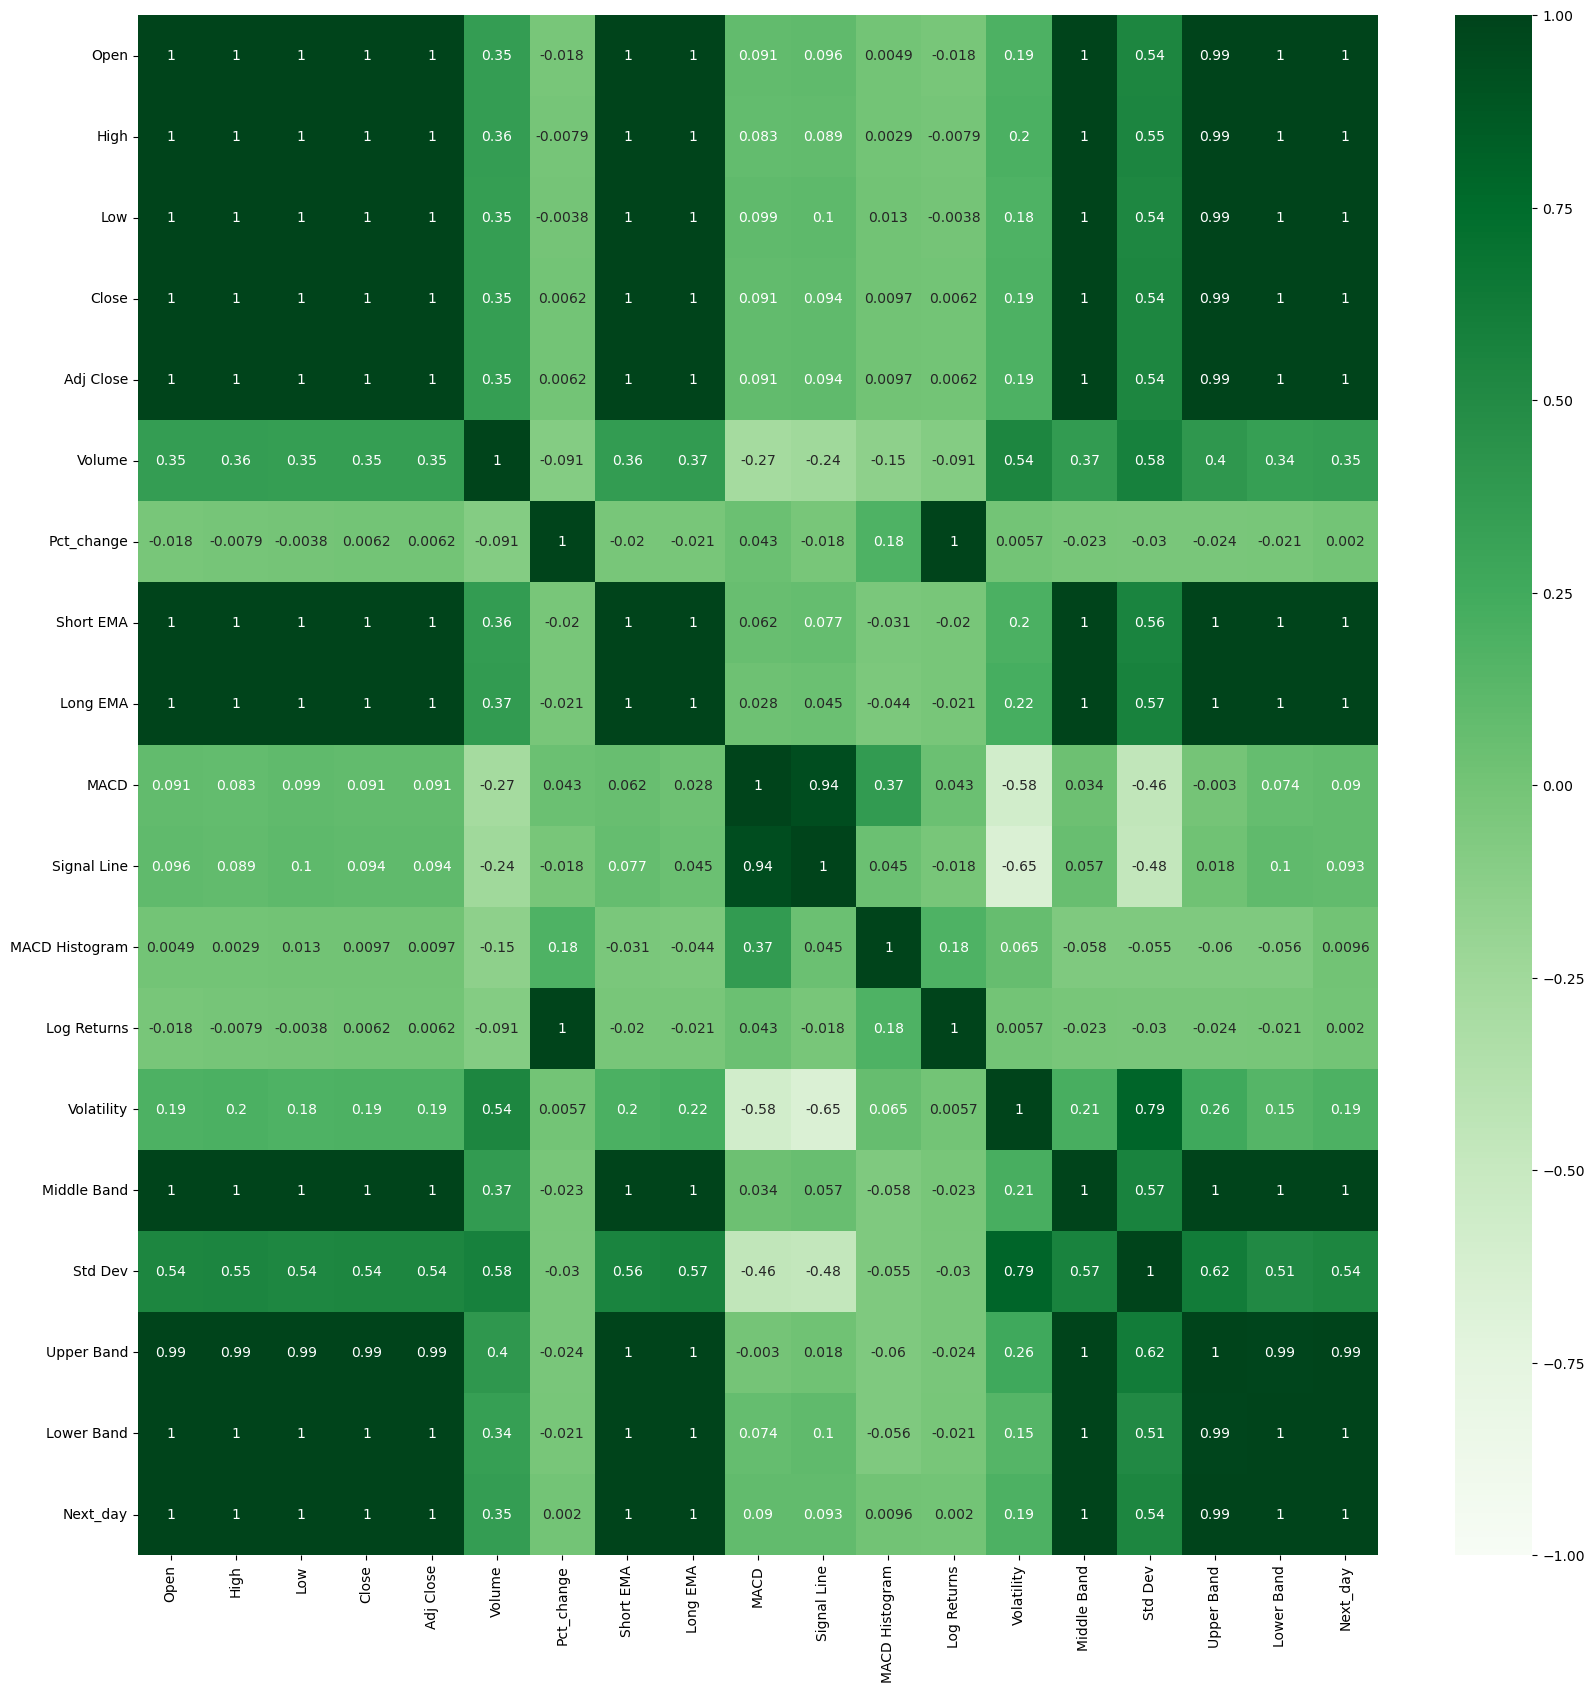

In [12]:
plt.rcParams["figure.figsize"] = (20,20)
sns.heatmap(df.corr(),
           annot = True, #Vaue on the heatmap
           cmap = 'Greens', #Colour
           vmin = -1, vmax=1 , #Boundary of Colour chart -1 ~ +1
          )

In [13]:
df1.corr()

Open      High       Low     Close  Adj Close    Volume  \
Open            1.000000  0.999852  0.999771  0.999610   0.999610  0.353807   
High            0.999852  1.000000  0.999692  0.999786   0.999786  0.358885   
Low             0.999771  0.999692  1.000000  0.999813   0.999813  0.345036   
Close           0.999610  0.999786  0.999813  1.000000   1.000000  0.351455   
Adj Close       0.999610  0.999786  0.999813  1.000000   1.000000  0.351455   
Volume          0.353807  0.358885  0.345036  0.351455   0.351455  1.000000   
Pct_change     -0.018161 -0.007863 -0.003762  0.006206   0.006206 -0.090585   
Short EMA       0.998987  0.999153  0.998456  0.998689   0.998689  0.364532   
Long EMA        0.997418  0.997824  0.996611  0.997103   0.997103  0.374474   
MACD            0.090508  0.083470  0.098560  0.090990   0.090990 -0.274924   
Signal Line     0.095616  0.088753  0.101593  0.094457   0.094457 -0.243282   
MACD Histogram  0.004941  0.002940  0.012531  0.009682   0.009682 -0.148305   
Log Returns    -0.018161 -0.007863 -0.003762  0.006206   0.006206 -0.090585   
Volatility      0.191272  0.198456  0.183881  0.191635   0.191635  0.544438   
Middle Band     0.997192  0.997553  0.996386  0.996836   0.996836  0.372514   
Std Dev         0.544717  0.550701  0.537925  0.544704   0.544704  0.583339   
Upper Band      0.993604  0.994408  0.992314  0.993263   0.993263  0.400326   
Lower Band      0.996545  0.996420  0.996274  0.996174   0.996174  0.340347   
Next_day        0.999081  0.999233  0.999267  0.999383   0.999383  0.351601   

                Pct_change  Short EMA  Long EMA      MACD  Signal Line  \
Open             -0.018161   0.998987  0.997418  0.090508     0.095616   
High             -0.007863   0.999153  0.997824  0.083470     0.088753   
Low              -0.003762   0.998456  0.996611  0.098560     0.101593   
Close             0.006206   0.998689  0.997103  0.090990     0.094457   
Adj Close         0.006206   0.998689  0.997103  0.090990     0.094457   
Volume           -0.090585   0.364532  0.374474 -0.274924    -0.243282   
Pct_change        1.000000  -0.019905 -0.021409  0.043167    -0.017658   
Short EMA        -0.019905   1.000000  0.999419  0.061606     0.077404   
Long EMA         -0.021409   0.999419  1.000000  0.027557     0.045274   
MACD              0.043167   0.061606  0.027557  1.000000     0.944494   
Signal Line      -0.017658   0.077404  0.045274  0.944494     1.000000   
MACD Histogram    0.181175  -0.031464 -0.044179  0.371005     0.045331   
Log Returns       1.000000  -0.019905 -0.021409  0.043167    -0.017658   
Volatility        0.005719   0.201275  0.221512 -0.583741    -0.651093   
Middle Band      -0.022825   0.999419  0.999785  0.033847     0.057049   
Std Dev          -0.029861   0.556699  0.573265 -0.460366    -0.475820   
Upper Band       -0.024077   0.996649  0.998269 -0.003025     0.017935   
Lower Band       -0.021348   0.997865  0.996856  0.074071     0.099622   
Next_day          0.001952   0.998168  0.996619  0.089887     0.093293   

                MACD Histogram  Log Returns  Volatility  Middle Band  \
Open                  0.004941    -0.018161    0.191272     0.997192   
High                  0.002940    -0.007863    0.198456     0.997553   
Low                   0.012531    -0.003762    0.183881     0.996386   
Close                 0.009682     0.006206    0.191635     0.996836   
Adj Close             0.009682     0.006206    0.191635     0.996836   
Volume               -0.148305    -0.090585    0.544438     0.372514   
Pct_change            0.181175     1.000000    0.005719    -0.022825   
Short EMA            -0.031464    -0.019905    0.201275     0.999419   
Long EMA             -0.044179    -0.021409    0.221512     0.999785   
MACD                  0.371005     0.043167   -0.583741     0.033847   
Signal Line           0.045331    -0.017658   -0.651093     0.057049   
MACD Histogram        1.000000     0.181175    0.065396    -0.058336   
Log Returns           

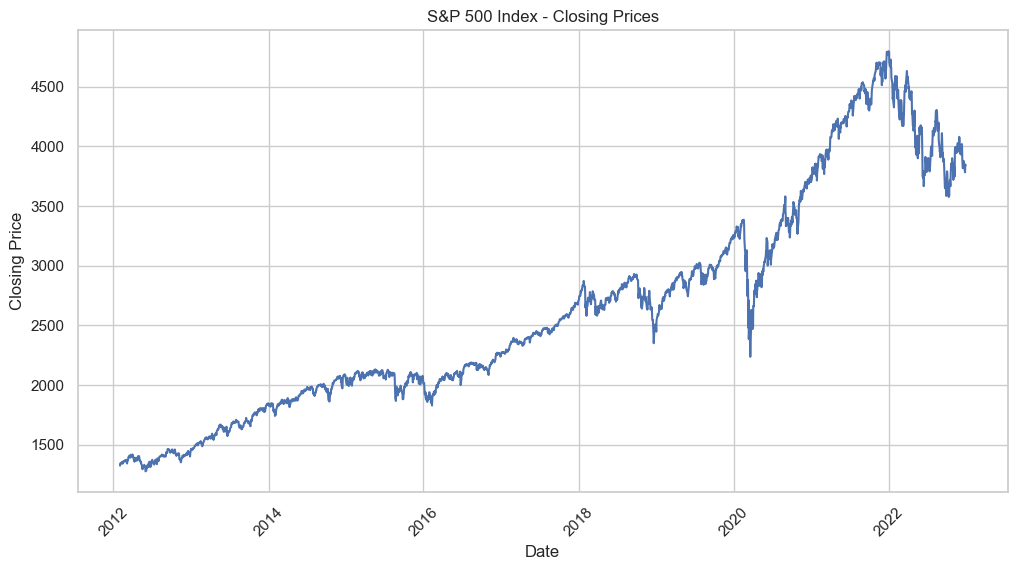

In [14]:
# Sort the DataFrame by date in ascending order
data = df.sort_values('Next_day')

# Set the Seaborn style
sns.set(style='whitegrid')

# Create the line plot using Seaborn
plt.figure(figsize=(12, 6))  # Adjust the figure size if needed
sns.lineplot(data=data, x='Date', y='Next_day')

# Set the plot title and axis labels
plt.title('S&P 500 Index - Closing Prices')
plt.xlabel('Date')
plt.ylabel('Closing Price')

# Rotate the x-axis labels
plt.xticks(rotation=45)

# Show the plot
plt.show()

<Axes: xlabel='Date'>

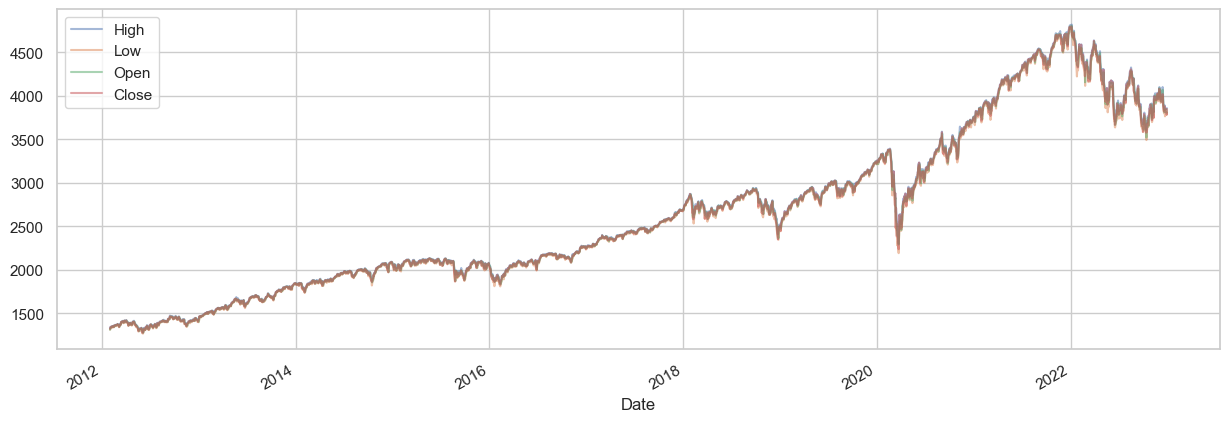

In [15]:
df[['High','Low','Open','Close']].plot(figsize = (15, 5), alpha = 0.5)

<Axes: xlabel='Date'>

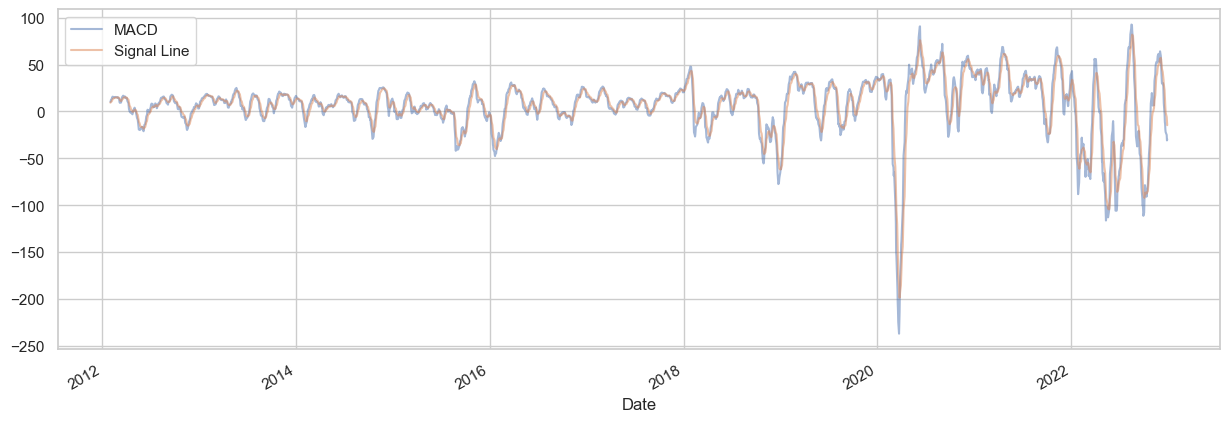

In [16]:
df[['MACD','Signal Line']].plot(figsize = (15, 5), alpha = 0.5)

Text(0.5, 1.0, 'Close Price trend with BollingerBand and the EMA')

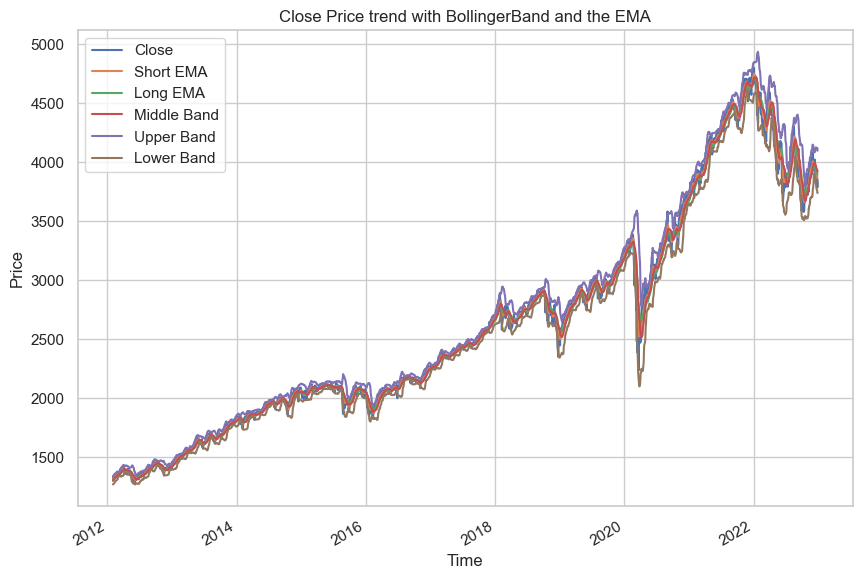

In [17]:
df[["Close","Short EMA", "Long EMA","Middle Band", 'Upper Band', 'Lower Band']].plot(figsize=(10,7))
plt.legend(loc="best")
plt.xlabel("Time")
plt.ylabel("Price")
plt.title("Close Price trend with BollingerBand and the EMA")

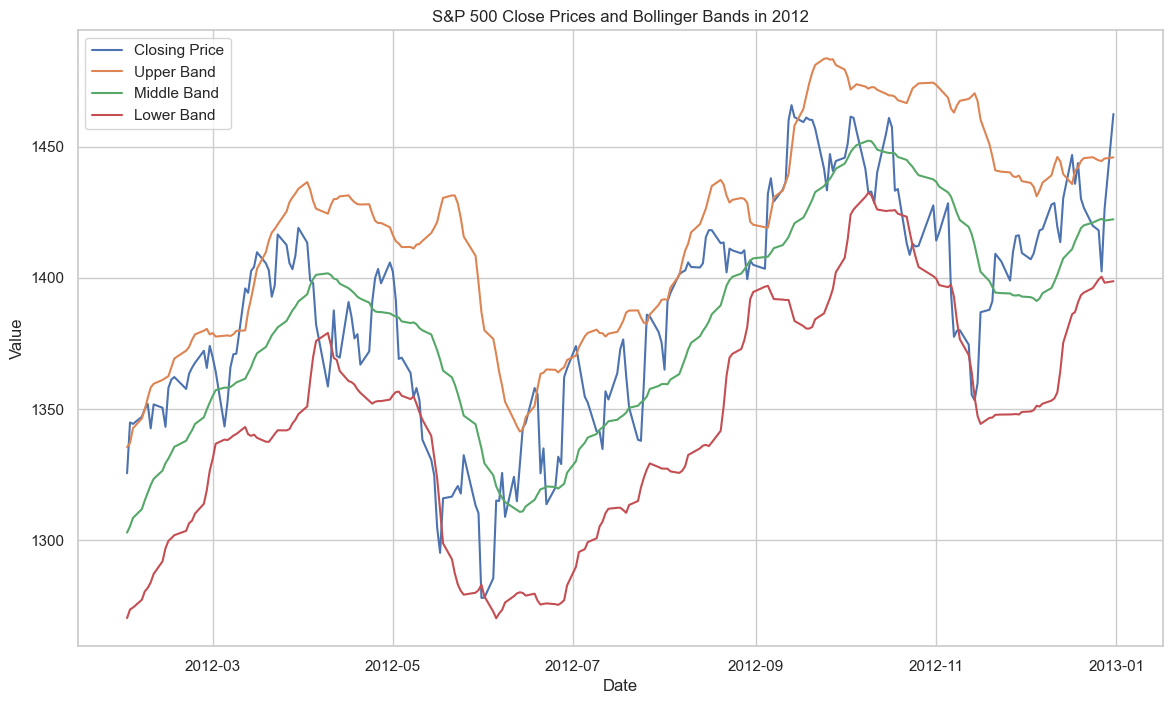

In [18]:
# Ensure the DataFrame's index is datetime
df.index = pd.to_datetime(df.index)

# Filter the data for the required range
mask = (df.index >= '2012-01-01') & (df.index <= '2012-12-31')
filtered_df = df.loc[mask]

# Plotting using seaborn
plt.figure(figsize=(14, 8))

# Plotting each column
sns.lineplot(data=filtered_df, x=filtered_df.index, y='Next_day', label='Closing Price')
sns.lineplot(data=filtered_df, x=filtered_df.index, y='Upper Band', label='Upper Band')
sns.lineplot(data=filtered_df, x=filtered_df.index, y='Middle Band', label='Middle Band')
sns.lineplot(data=filtered_df, x=filtered_df.index, y='Lower Band', label='Lower Band')

plt.title('S&P 500 Close Prices and Bollinger Bands in 2012')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

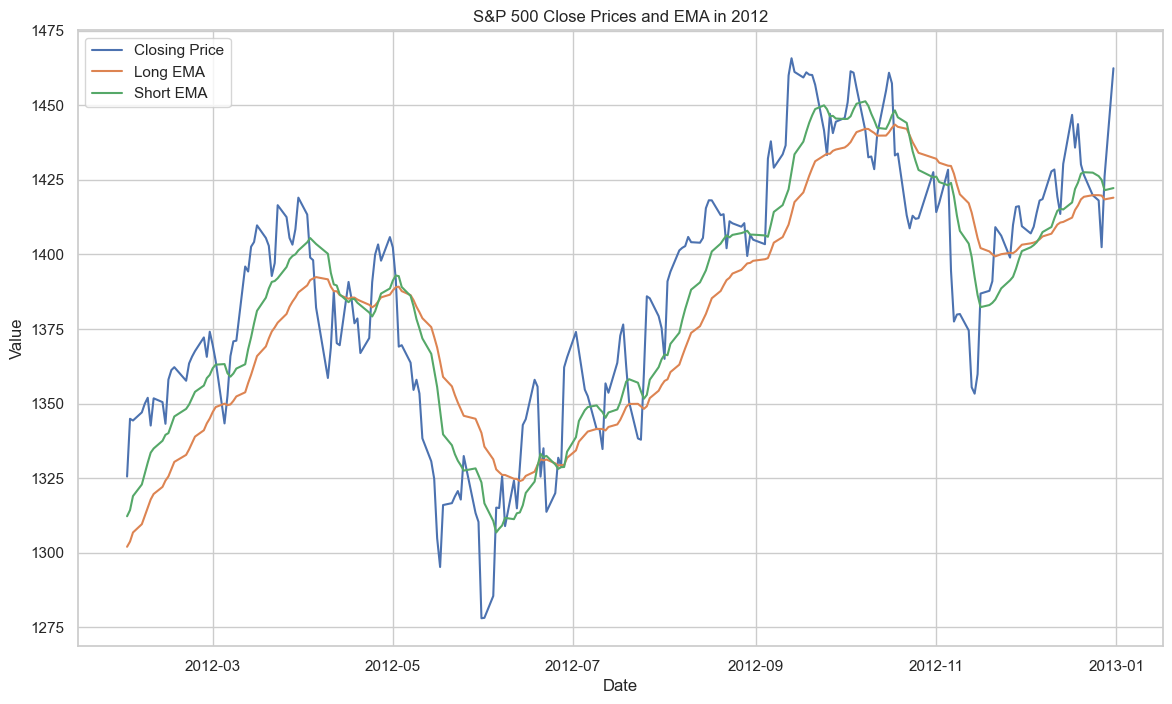

In [19]:
# Ensure the DataFrame's index is datetime
df.index = pd.to_datetime(df.index)

# Filter the data for the required range
mask = (df.index >= '2012-01-01') & (df.index <= '2012-12-31')
filtered_df = df.loc[mask]

# Plotting using seaborn
plt.figure(figsize=(14, 8))

# Plotting each column
sns.lineplot(data=filtered_df, x=filtered_df.index, y='Next_day', label='Closing Price')
sns.lineplot(data=filtered_df, x=filtered_df.index, y='Long EMA', label='Long EMA')
sns.lineplot(data=filtered_df, x=filtered_df.index, y='Short EMA', label='Short EMA')

plt.title('S&P 500 Close Prices and EMA in 2012')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

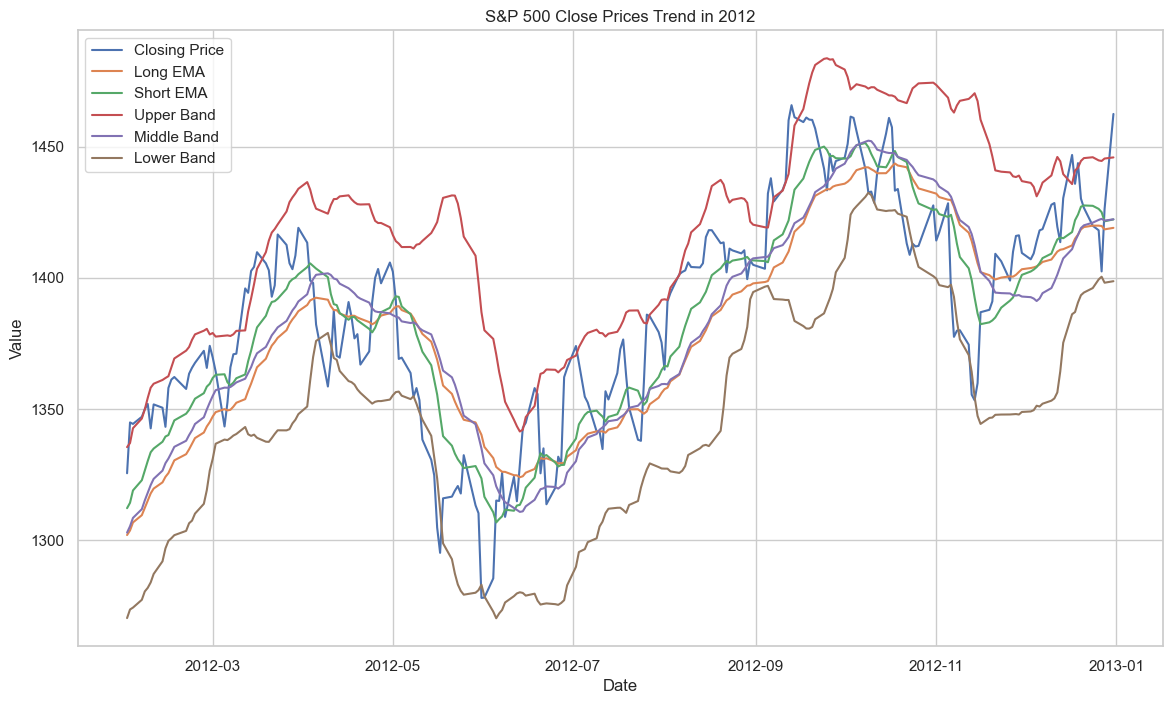

In [20]:
# Ensure the DataFrame's index is datetime
df.index = pd.to_datetime(df.index)

# Filter the data for the required range
mask = (df.index >= '2012-01-01') & (df.index <= '2012-12-31')
filtered_df1 = df1.loc[mask]

# Plotting using seaborn
plt.figure(figsize=(14, 8))

# Plotting each column
sns.lineplot(data=filtered_df, x=filtered_df.index, y='Next_day', label='Closing Price')
sns.lineplot(data=filtered_df, x=filtered_df.index, y='Long EMA', label='Long EMA')
sns.lineplot(data=filtered_df, x=filtered_df.index, y='Short EMA', label='Short EMA')
sns.lineplot(data=filtered_df, x=filtered_df.index, y='Upper Band', label='Upper Band')
sns.lineplot(data=filtered_df, x=filtered_df.index, y='Middle Band', label='Middle Band')
sns.lineplot(data=filtered_df, x=filtered_df.index, y='Lower Band', label='Lower Band')

plt.title('S&P 500 Close Prices Trend in 2012')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

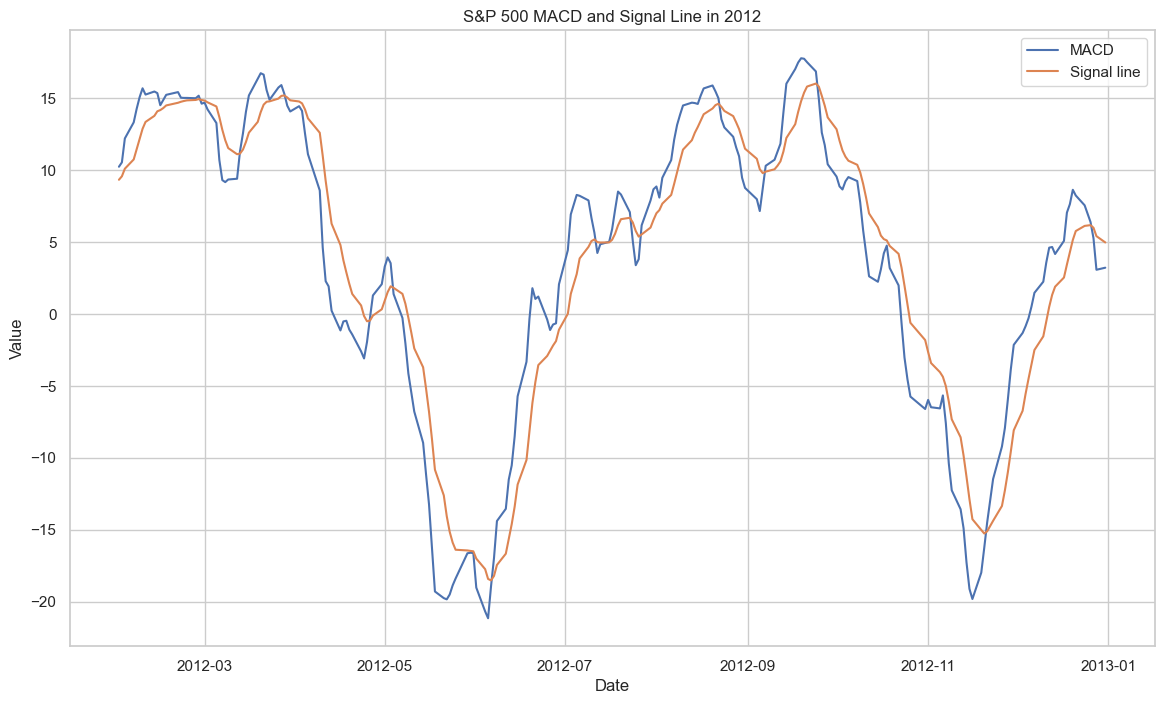

In [21]:
# Ensure the DataFrame's index is datetime
df.index = pd.to_datetime(df.index)

# Filter the data for the required range
mask = (df.index >= '2012-01-01') & (df.index <= '2012-12-31')
filtered_df = df.loc[mask]

# Plotting using seaborn
plt.figure(figsize=(14, 8))

# Plotting each column
sns.lineplot(data=filtered_df, x=filtered_df.index, y='MACD', label='MACD')
sns.lineplot(data=filtered_df, x=filtered_df.index, y='Signal Line', label='Signal line')

plt.title('S&P 500 MACD and Signal Line in 2012')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

# 2019

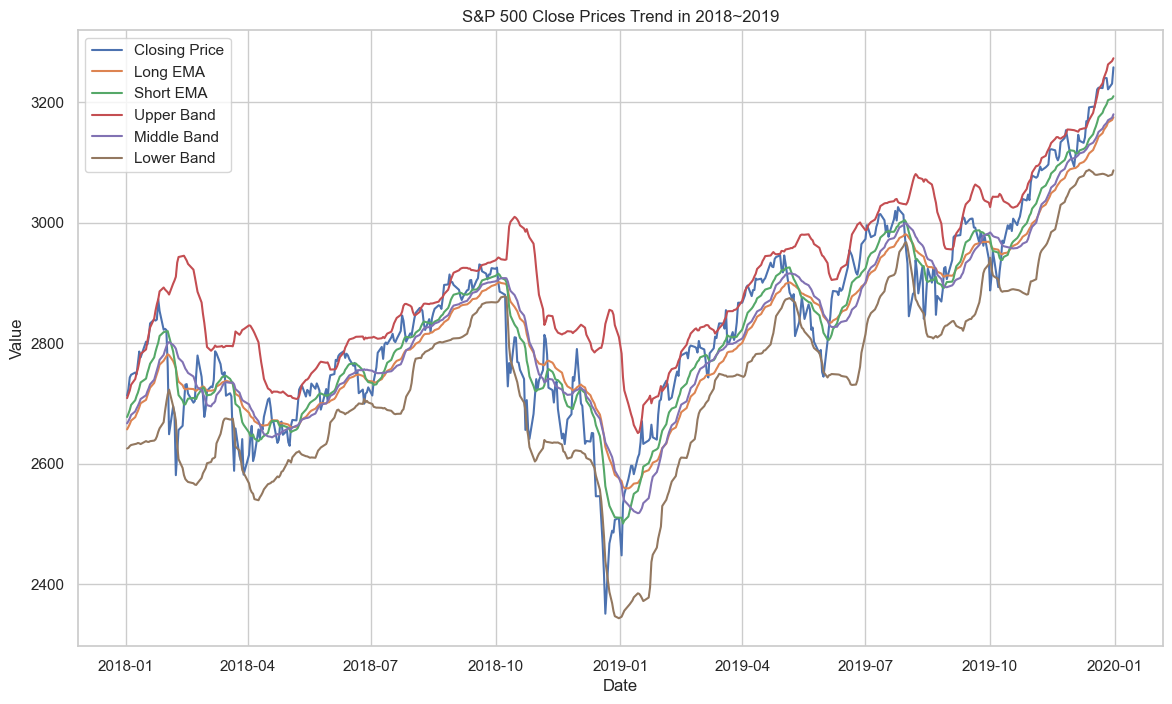

In [22]:
# Ensure the DataFrame's index is datetime
df1.index = pd.to_datetime(df.index)

# Filter the data for the required range
mask = (df.index >= '2018-01-01') & (df.index <= '2020-01-01')
filtered_df = df.loc[mask]

# Plotting using seaborn
plt.figure(figsize=(14, 8))

# Plotting each column
sns.lineplot(data=filtered_df, x=filtered_df.index, y='Next_day', label='Closing Price')
sns.lineplot(data=filtered_df, x=filtered_df.index, y='Long EMA', label='Long EMA')
sns.lineplot(data=filtered_df, x=filtered_df.index, y='Short EMA', label='Short EMA')
sns.lineplot(data=filtered_df, x=filtered_df.index, y='Upper Band', label='Upper Band')
sns.lineplot(data=filtered_df, x=filtered_df.index, y='Middle Band', label='Middle Band')
sns.lineplot(data=filtered_df, x=filtered_df.index, y='Lower Band', label='Lower Band')



plt.title('S&P 500 Close Prices Trend in 2018~2019')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

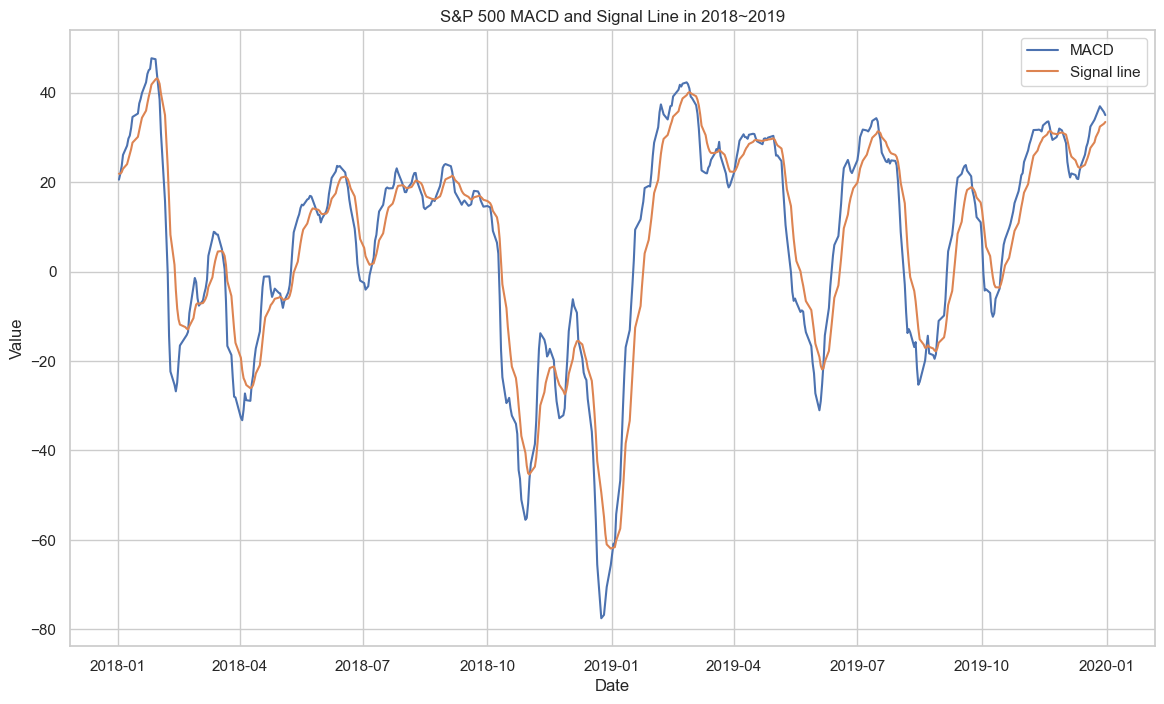

In [23]:
# Ensure the DataFrame's index is datetime
df.index = pd.to_datetime(df.index)

# Filter the data for the required range
mask = (df.index >= '2018-01-01') & (df.index <= '2020-01-01')
filtered_df = df.loc[mask]

# Plotting using seaborn
plt.figure(figsize=(14, 8))

# Plotting each column
sns.lineplot(data=filtered_df, x=filtered_df.index, y='MACD', label='MACD')
sns.lineplot(data=filtered_df, x=filtered_df.index, y='Signal Line', label='Signal line')

plt.title('S&P 500 MACD and Signal Line in 2018~2019')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

# August 2019 to June 2020 Graphs

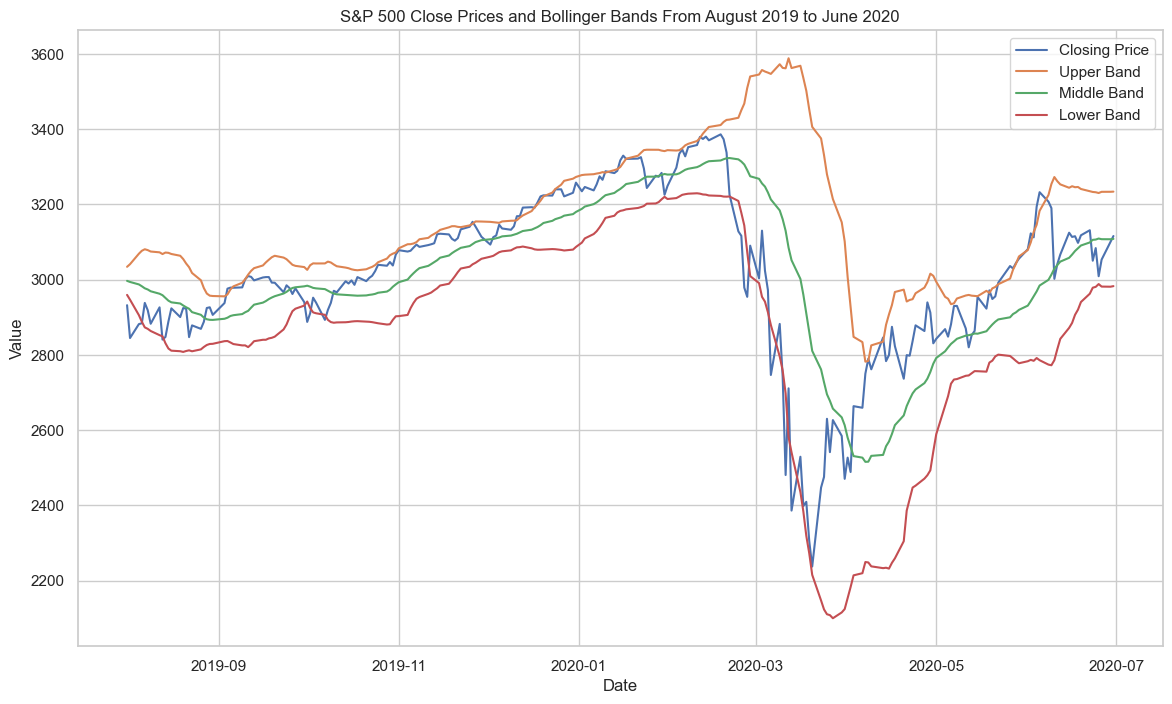

In [24]:
# Ensure the DataFrame's index is datetime
df.index = pd.to_datetime(df.index)

# Filter the data for the required range
mask = (df.index >= '2019-08-01') & (df.index <= '2020-06-30')
filtered_df = df.loc[mask]

# Plotting using seaborn
plt.figure(figsize=(14, 8))

# Plotting each column
sns.lineplot(data=filtered_df, x=filtered_df.index, y='Next_day', label='Closing Price')
sns.lineplot(data=filtered_df, x=filtered_df.index, y='Upper Band', label='Upper Band')
sns.lineplot(data=filtered_df, x=filtered_df.index, y='Middle Band', label='Middle Band')
sns.lineplot(data=filtered_df, x=filtered_df.index, y='Lower Band', label='Lower Band')

plt.title('S&P 500 Close Prices and Bollinger Bands From August 2019 to June 2020')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

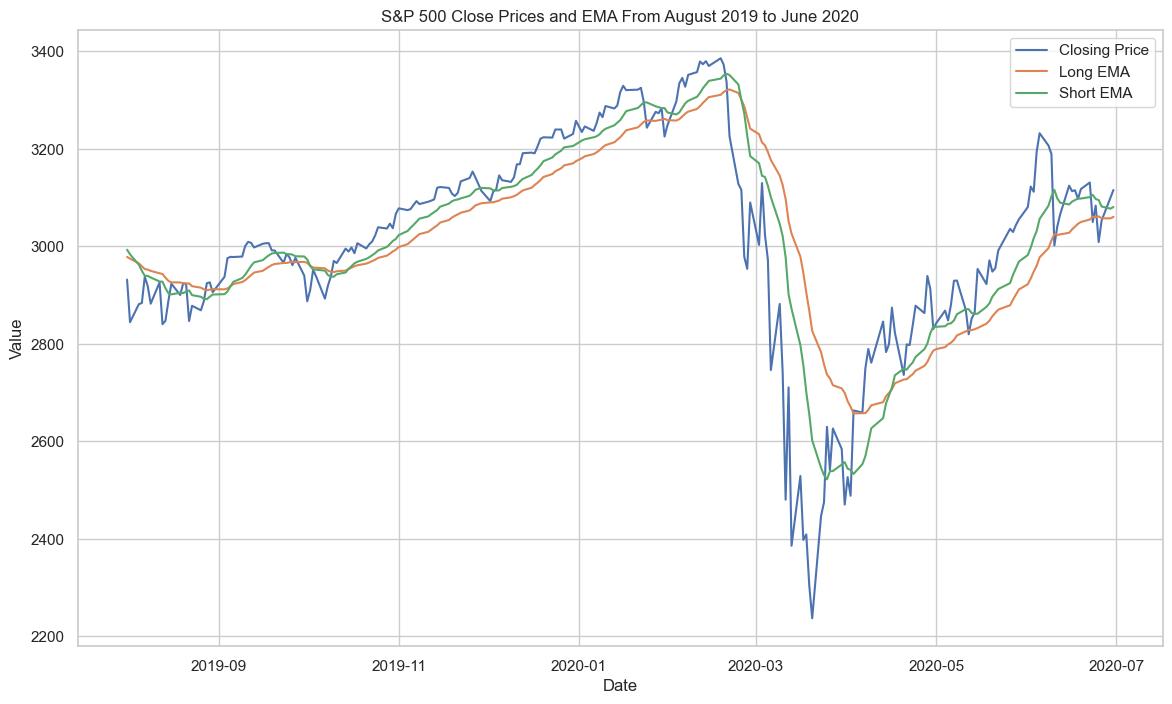

In [25]:
# Ensure the DataFrame's index is datetime
df1.index = pd.to_datetime(df.index)

# Filter the data for the required range
mask = (df.index >= '2019-08-01') & (df.index <= '2020-06-30')
filtered_df = df.loc[mask]

# Plotting using seaborn
plt.figure(figsize=(14, 8))

# Plotting each column
sns.lineplot(data=filtered_df, x=filtered_df.index, y='Next_day', label='Closing Price')
sns.lineplot(data=filtered_df, x=filtered_df.index, y='Long EMA', label='Long EMA')
sns.lineplot(data=filtered_df, x=filtered_df.index, y='Short EMA', label='Short EMA')

plt.title('S&P 500 Close Prices and EMA From August 2019 to June 2020')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

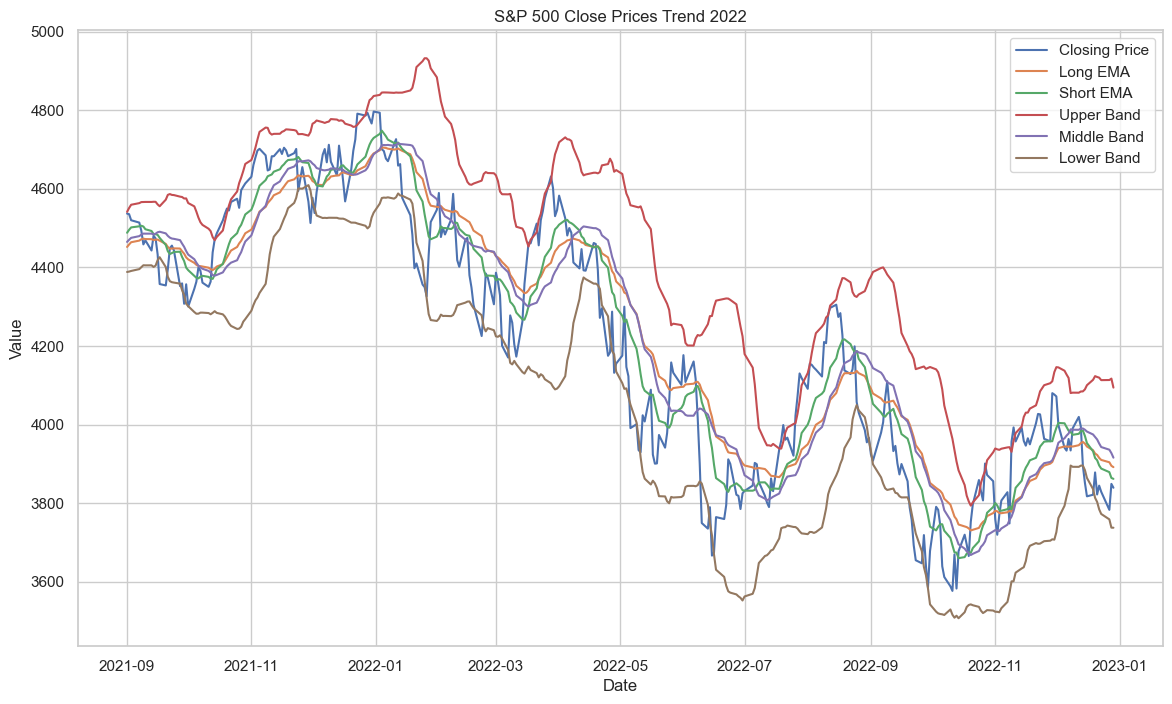

In [26]:
# Ensure the DataFrame's index is datetime
df1.index = pd.to_datetime(df.index)

# Filter the data for the required range
mask = (df.index >= '2021-09-01') & (df.index <= '2022-12-31')
filtered_df = df.loc[mask]

# Plotting using seaborn
plt.figure(figsize=(14, 8))

# Plotting each column
sns.lineplot(data=filtered_df, x=filtered_df.index, y='Next_day', label='Closing Price')
sns.lineplot(data=filtered_df, x=filtered_df.index, y='Long EMA', label='Long EMA')
sns.lineplot(data=filtered_df, x=filtered_df.index, y='Short EMA', label='Short EMA')
sns.lineplot(data=filtered_df, x=filtered_df.index, y='Upper Band', label='Upper Band')
sns.lineplot(data=filtered_df, x=filtered_df.index, y='Middle Band', label='Middle Band')
sns.lineplot(data=filtered_df, x=filtered_df.index, y='Lower Band', label='Lower Band')



plt.title('S&P 500 Close Prices Trend 2022')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

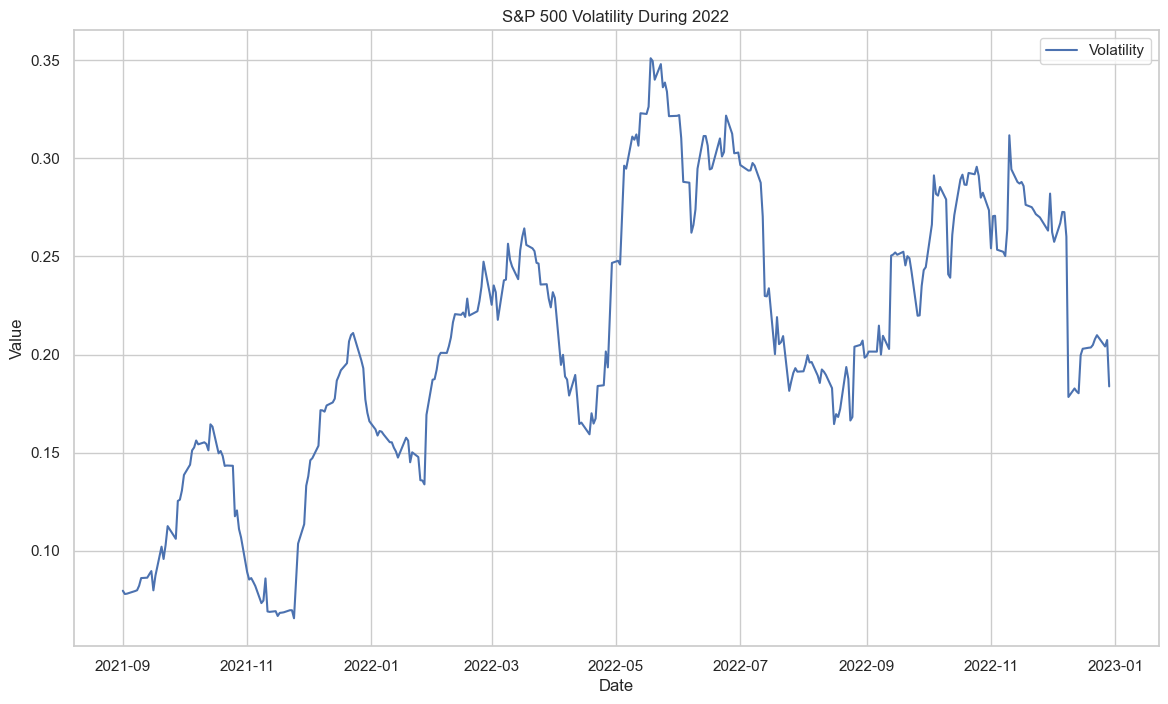

In [27]:
# Ensure the DataFrame's index is datetime
df.index = pd.to_datetime(df.index)

# Filter the data for the required range
mask = (df.index >= '2021-09-01') & (df.index <= '2022-12-31')
filtered_df = df.loc[mask]

# Plotting using seaborn
plt.figure(figsize=(14, 8))

# Plotting each column
sns.lineplot(data=filtered_df, x=filtered_df.index, y='Volatility', label='Volatility')

plt.title('S&P 500 Volatility During 2022')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

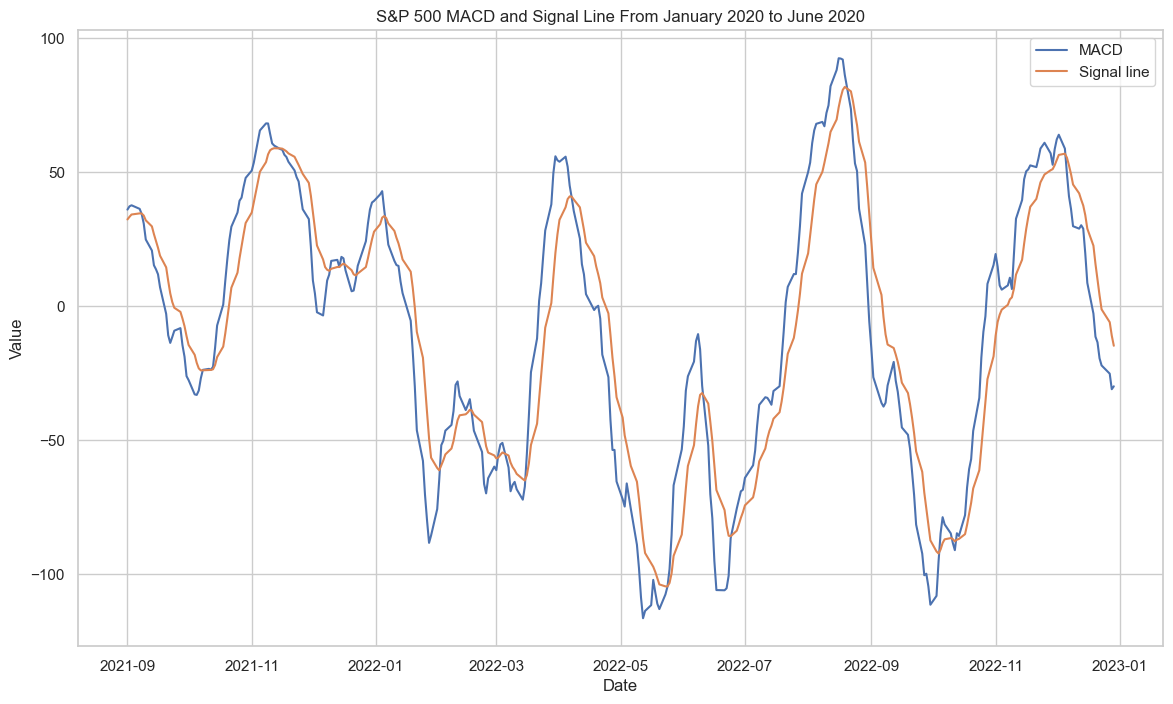

In [28]:
# Ensure the DataFrame's index is datetime
df.index = pd.to_datetime(df.index)

# Filter the data for the required range
mask = (df.index >= '2021-09-01') & (df.index <= '2022-12-31')
filtered_df = df.loc[mask]

# Plotting using seaborn
plt.figure(figsize=(14, 8))

# Plotting each column
sns.lineplot(data=filtered_df, x=filtered_df.index, y='MACD', label='MACD')
sns.lineplot(data=filtered_df, x=filtered_df.index, y='Signal Line', label='Signal line')

plt.title('S&P 500 MACD and Signal Line From January 2020 to June 2020')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

# Graph during 2020

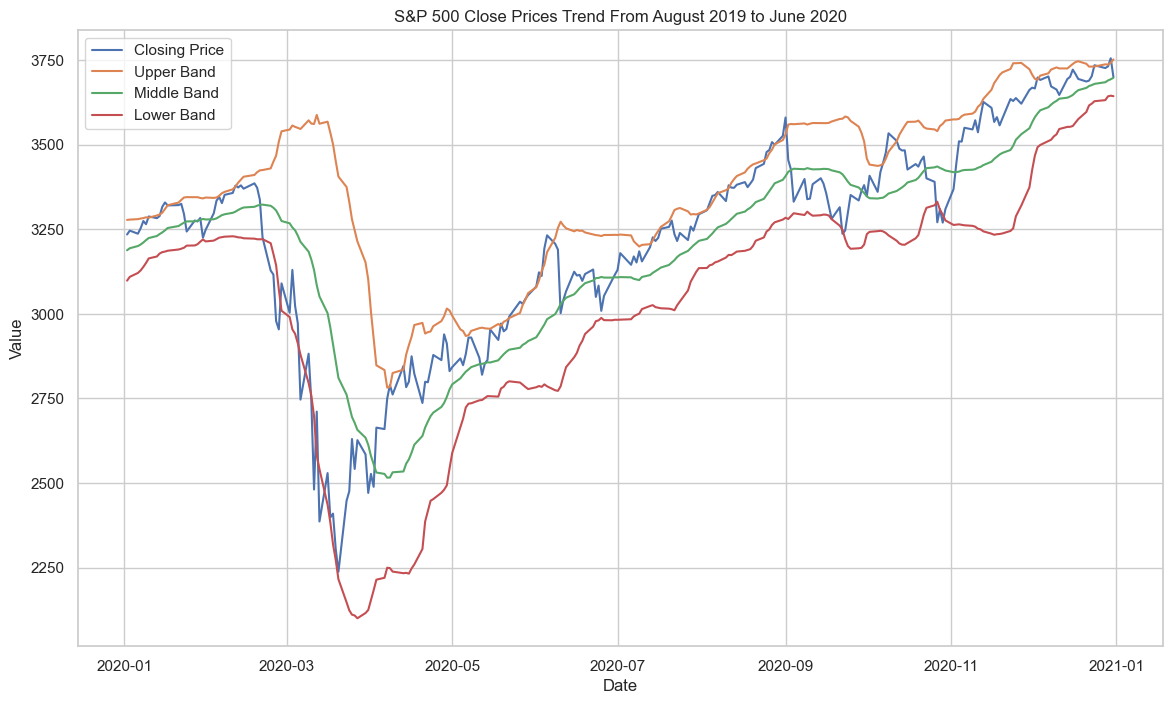

In [29]:
# Ensure the DataFrame's index is datetime
df.index = pd.to_datetime(df.index)

# Filter the data for the required range
mask = (df.index >= '2020-01-01') & (df.index <= '2020-12-31')
filtered_df = df.loc[mask]

# Plotting using seaborn
plt.figure(figsize=(14, 8))

# Plotting each column
sns.lineplot(data=filtered_df, x=filtered_df.index, y='Next_day', label='Closing Price')
sns.lineplot(data=filtered_df, x=filtered_df.index, y='Upper Band', label='Upper Band')
sns.lineplot(data=filtered_df, x=filtered_df.index, y='Middle Band', label='Middle Band')
sns.lineplot(data=filtered_df, x=filtered_df.index, y='Lower Band', label='Lower Band')

plt.title('S&P 500 Close Prices Trend From August 2019 to June 2020')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


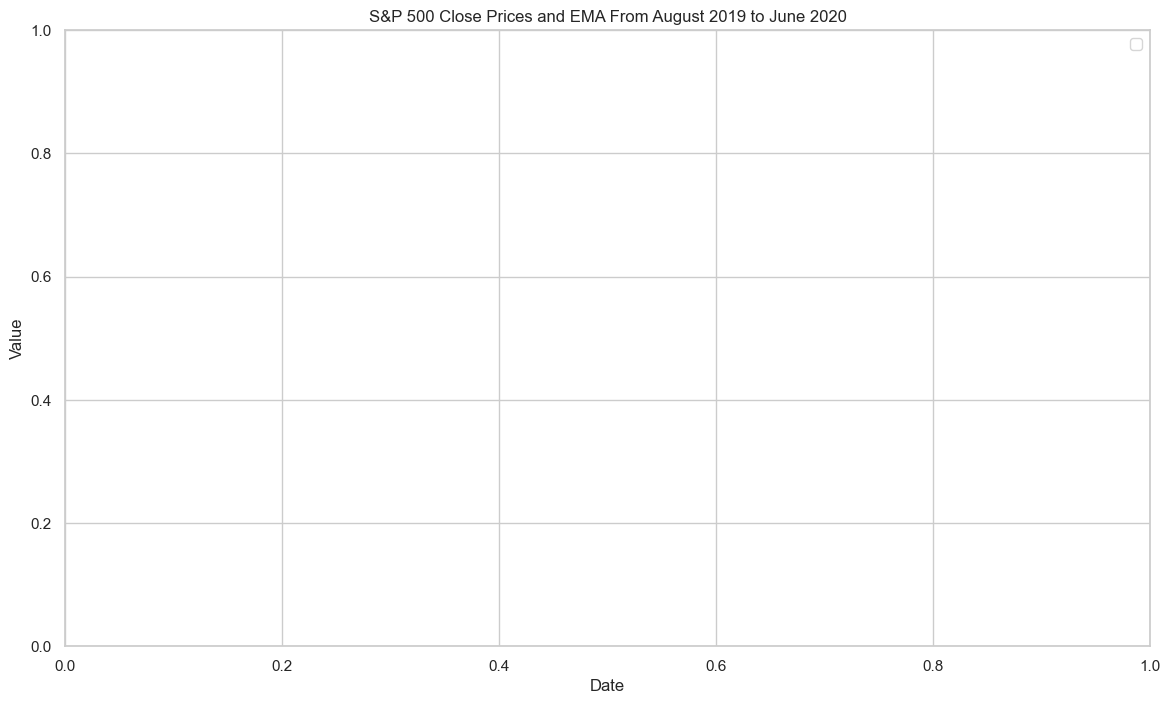

In [30]:
# Ensure the DataFrame's index is datetime
df1.index = pd.to_datetime(df.index)

# Filter the data for the required range
mask = (df.index >= '2021-01-01') & (df.index <= '2020-12-31')
filtered_df = df.loc[mask]

# Plotting using seaborn
plt.figure(figsize=(14, 8))

# Plotting each column
sns.lineplot(data=filtered_df, x=filtered_df.index, y='Next_day', label='Closing Price')
sns.lineplot(data=filtered_df, x=filtered_df.index, y='Long EMA', label='Long EMA')
sns.lineplot(data=filtered_df, x=filtered_df.index, y='Short EMA', label='Short EMA')

plt.title('S&P 500 Close Prices and EMA From August 2019 to June 2020')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

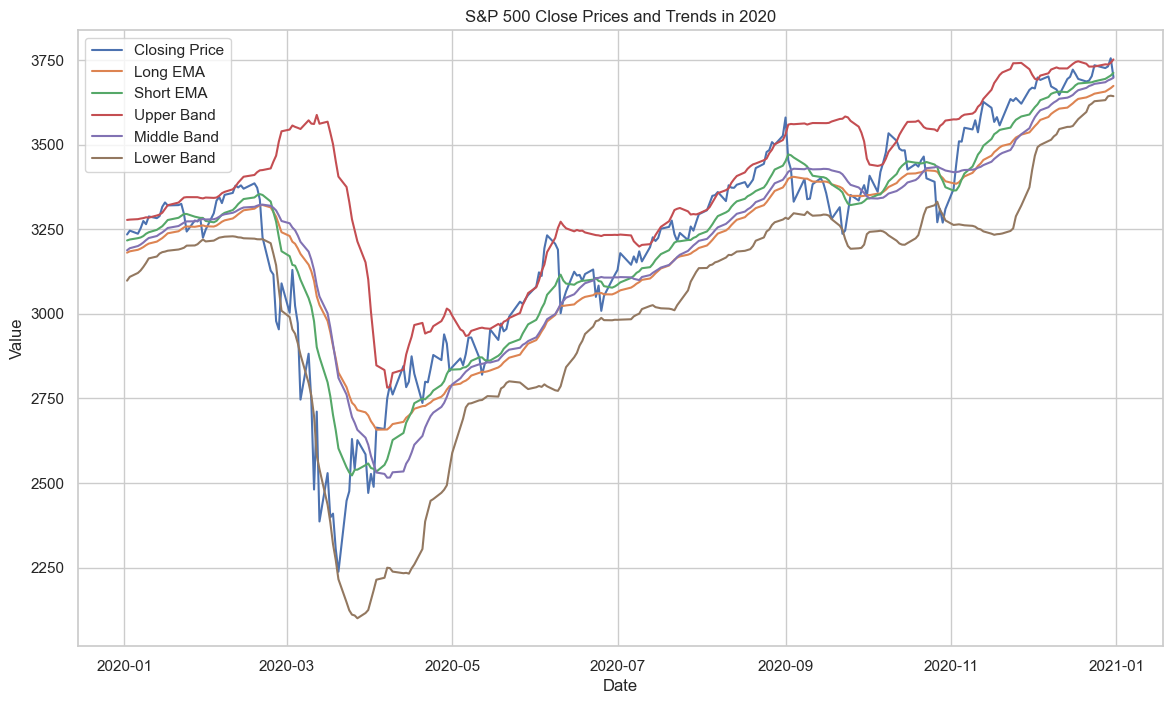

In [31]:
# Ensure the DataFrame's index is datetime
df.index = pd.to_datetime(df.index)

# Filter the data for the required range
mask = (df.index >= '2020-01-01') & (df.index <= '2020-12-31')
filtered_df = df.loc[mask]

# Plotting using seaborn
plt.figure(figsize=(14, 8))

# Plotting each column
sns.lineplot(data=filtered_df, x=filtered_df.index, y='Next_day', label='Closing Price')
sns.lineplot(data=filtered_df, x=filtered_df.index, y='Long EMA', label='Long EMA')
sns.lineplot(data=filtered_df, x=filtered_df.index, y='Short EMA', label='Short EMA')
sns.lineplot(data=filtered_df, x=filtered_df.index, y='Upper Band', label='Upper Band')
sns.lineplot(data=filtered_df, x=filtered_df.index, y='Middle Band', label='Middle Band')
sns.lineplot(data=filtered_df, x=filtered_df.index, y='Lower Band', label='Lower Band')



plt.title('S&P 500 Close Prices and Trends in 2020')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

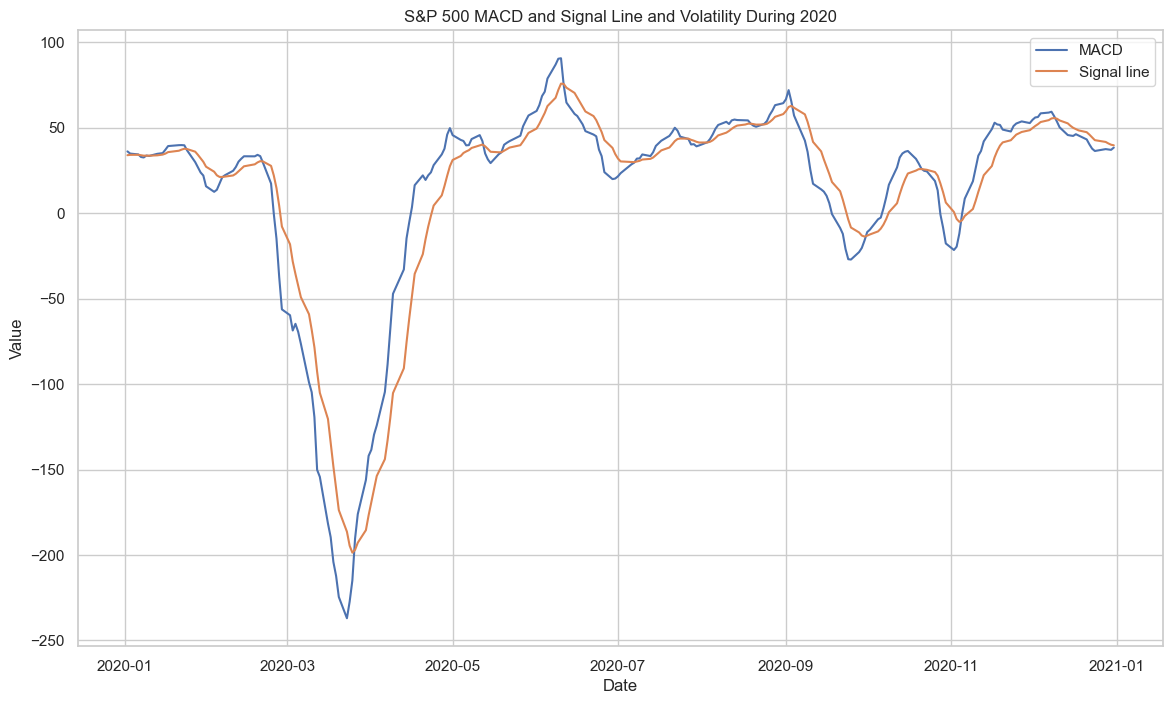

In [32]:
# Ensure the DataFrame's index is datetime
df.index = pd.to_datetime(df.index)

# Filter the data for the required range
mask = (df.index >= '2020-01-01') & (df.index <= '2020-12-31')
filtered_df = df.loc[mask]

# Plotting using seaborn
plt.figure(figsize=(14, 8))

# Plotting each column
sns.lineplot(data=filtered_df, x=filtered_df.index, y='MACD', label='MACD')
sns.lineplot(data=filtered_df, x=filtered_df.index, y='Signal Line', label='Signal line')

plt.title('S&P 500 MACD and Signal Line and Volatility During 2020')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

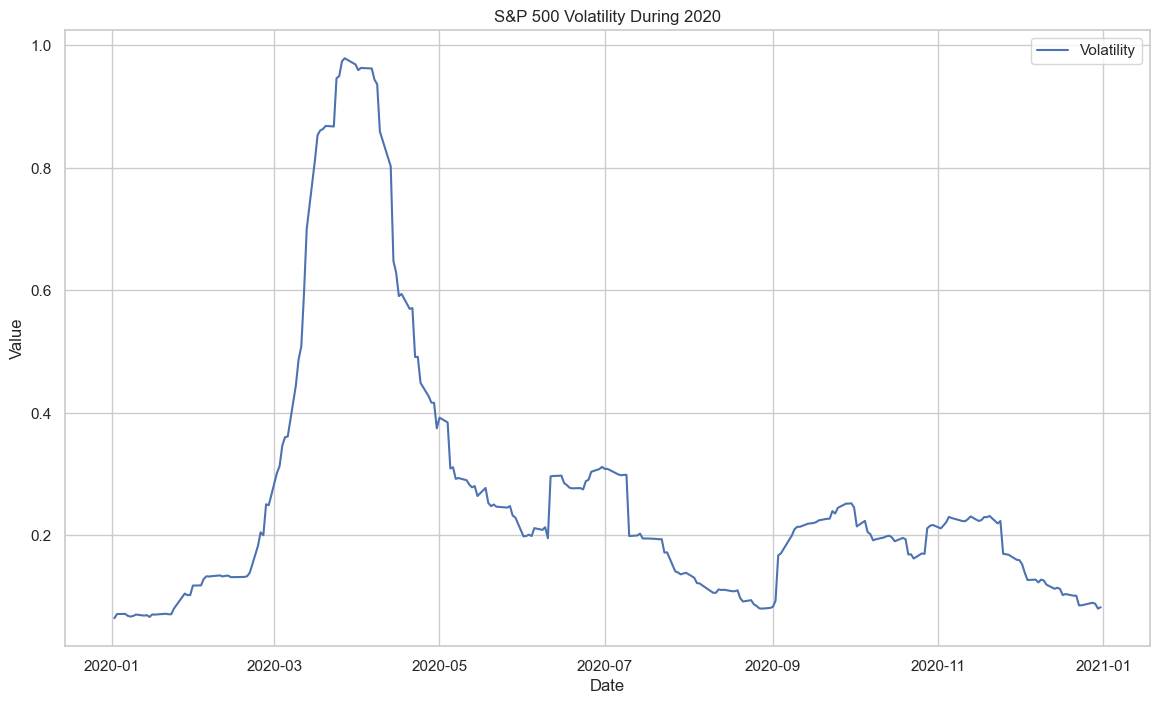

In [33]:
# Ensure the DataFrame's index is datetime
df.index = pd.to_datetime(df.index)

# Filter the data for the required range
mask = (df.index >= '2020-01-01') & (df.index <= '2020-12-31')
filtered_df = df.loc[mask]

# Plotting using seaborn
plt.figure(figsize=(14, 8))

# Plotting each column
sns.lineplot(data=filtered_df, x=filtered_df.index, y='Volatility', label='Volatility')

plt.title('S&P 500 Volatility During 2020')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

# Graph During 2020 APR~2021

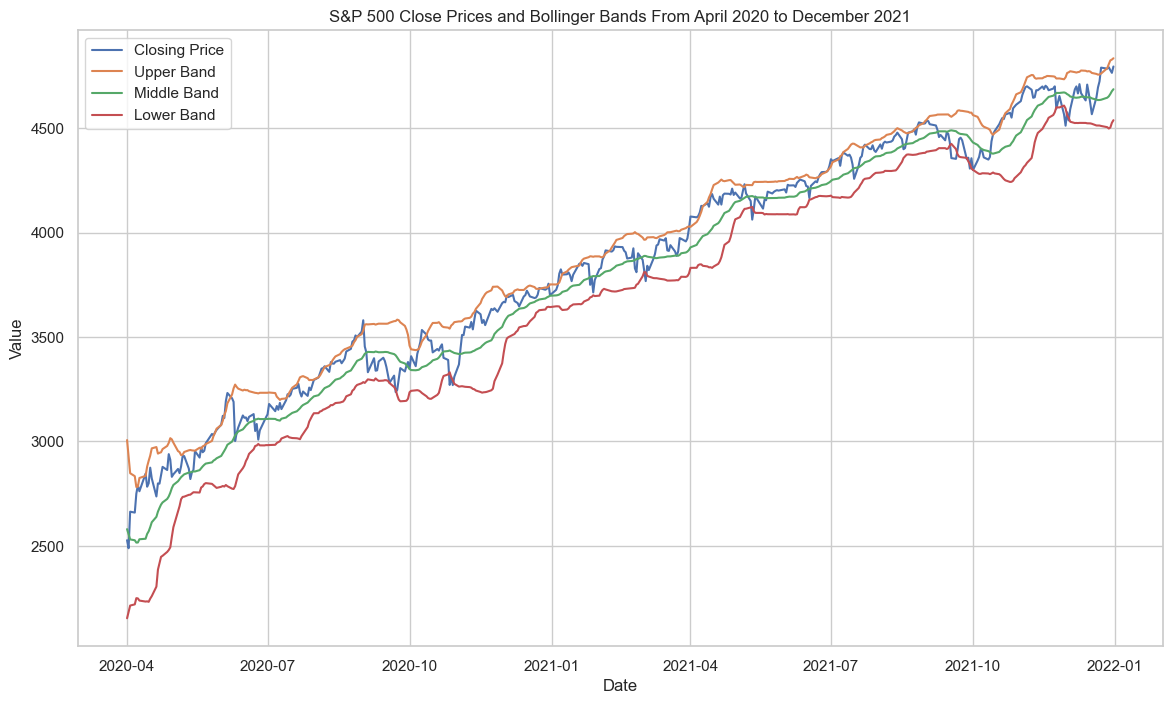

In [34]:
# Ensure the DataFrame's index is datetime
df.index = pd.to_datetime(df.index)

# Filter the data for the required range
mask = (df.index >= '2020-04-01') & (df.index <= '2022-01-01')
filtered_df = df.loc[mask]

# Plotting using seaborn
plt.figure(figsize=(14, 8))

# Plotting each column
sns.lineplot(data=filtered_df, x=filtered_df.index, y='Next_day', label='Closing Price')
sns.lineplot(data=filtered_df, x=filtered_df.index, y='Upper Band', label='Upper Band')
sns.lineplot(data=filtered_df, x=filtered_df.index, y='Middle Band', label='Middle Band')
sns.lineplot(data=filtered_df, x=filtered_df.index, y='Lower Band', label='Lower Band')

plt.title('S&P 500 Close Prices and Bollinger Bands From April 2020 to December 2021')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

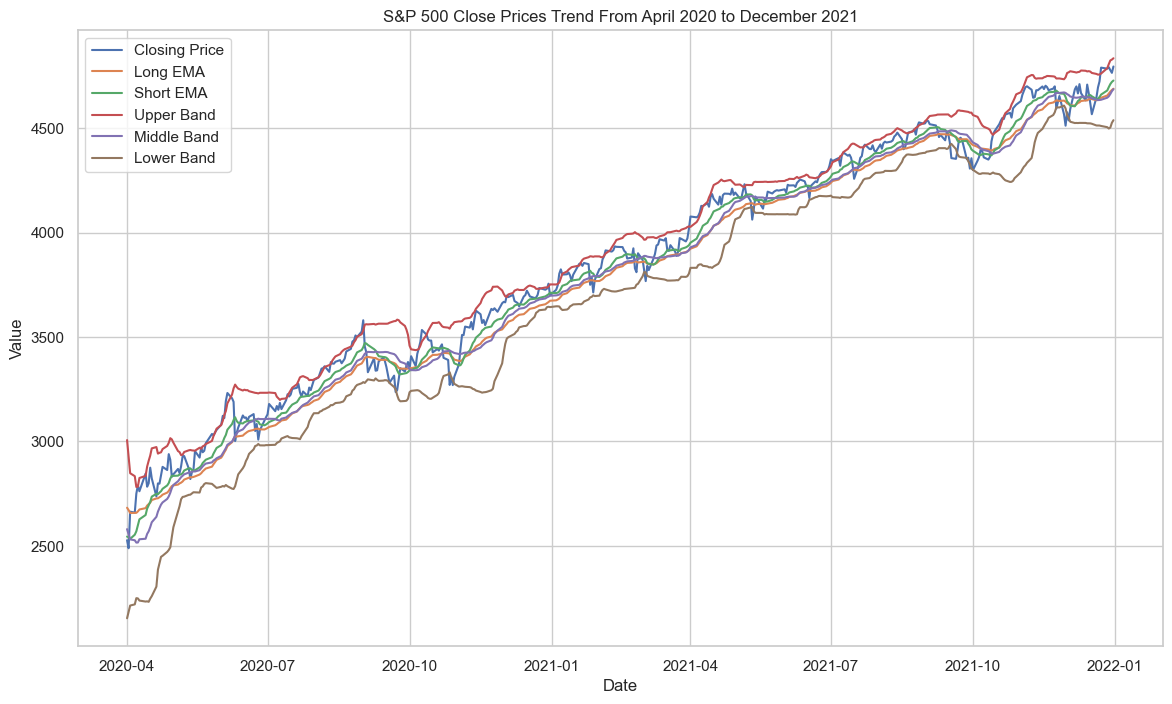

In [35]:
# Ensure the DataFrame's index is datetime
df.index = pd.to_datetime(df.index)

# Filter the data for the required range
mask = (df.index >= '2020-04-01') & (df.index <= '2022-01-01')
filtered_df = df.loc[mask]

# Plotting using seaborn
plt.figure(figsize=(14, 8))

# Plotting each column
sns.lineplot(data=filtered_df, x=filtered_df.index, y='Next_day', label='Closing Price')
sns.lineplot(data=filtered_df, x=filtered_df.index, y='Long EMA', label='Long EMA')
sns.lineplot(data=filtered_df, x=filtered_df.index, y='Short EMA', label='Short EMA')
sns.lineplot(data=filtered_df, x=filtered_df.index, y='Upper Band', label='Upper Band')
sns.lineplot(data=filtered_df, x=filtered_df.index, y='Middle Band', label='Middle Band')
sns.lineplot(data=filtered_df, x=filtered_df.index, y='Lower Band', label='Lower Band')



plt.title('S&P 500 Close Prices Trend From April 2020 to December 2021')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

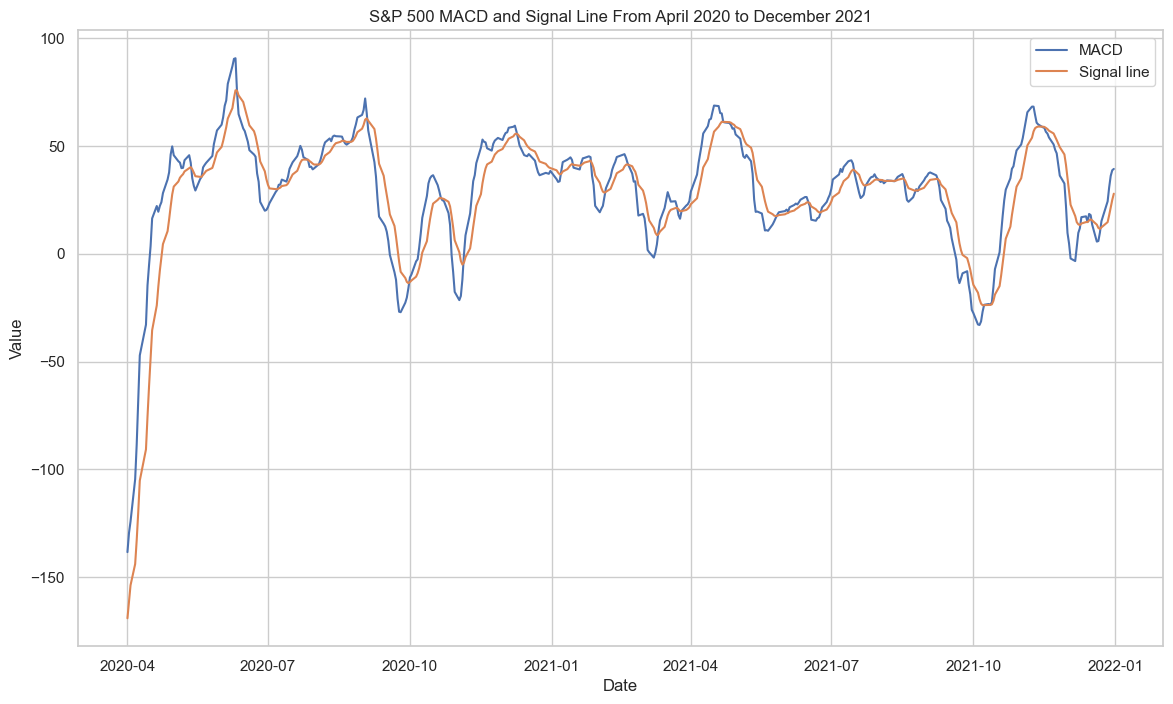

In [36]:
# Ensure the DataFrame's index is datetime
df.index = pd.to_datetime(df.index)

# Filter the data for the required range
mask = (df.index >= '2020-04-01') & (df.index <= '2022-01-01')
filtered_df = df.loc[mask]

# Plotting using seaborn
plt.figure(figsize=(14, 8))

# Plotting each column
sns.lineplot(data=filtered_df, x=filtered_df.index, y='MACD', label='MACD')
sns.lineplot(data=filtered_df, x=filtered_df.index, y='Signal Line', label='Signal line')

plt.title('S&P 500 MACD and Signal Line From April 2020 to December 2021')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

In [37]:
df

Open         High          Low        Close    Adj Close  \
Date                                                                          
2012-02-01  1312.449951  1330.520020  1312.449951  1324.089966  1324.089966   
2012-02-02  1324.239990  1329.189941  1321.569946  1325.540039  1325.540039   
2012-02-03  1326.209961  1345.339966  1326.209961  1344.900024  1344.900024   
2012-02-06  1344.319946  1344.359985  1337.520020  1344.329956  1344.329956   
2012-02-07  1344.329956  1349.239990  1335.920044  1347.050049  1347.050049   
...                 ...          ...          ...          ...          ...   
2022-12-22  3853.260010  3853.260010  3764.489990  3822.389893  3822.389893   
2022-12-23  3815.110107  3845.800049  3797.010010  3844.820068  3844.820068   
2022-12-27  3843.340088  3846.649902  3813.219971  3829.250000  3829.250000   
2022-12-28  3829.560059  3848.320068  3780.780029  3783.219971  3783.219971   
2022-12-29  3805.449951  3858.189941  3805.449951  3849.280029  3849.280029   

                Volume  Pct_change    Short EMA     Long EMA       MACD  \
Date                                                                      
2012-02-01  4504360000    0.008860  1312.233663  1302.000221  10.233442   
2012-02-02  4120920000    0.001095  1314.280798  1303.743912  10.536886   
2012-02-03  4608550000    0.014500  1318.991448  1306.792512  12.198936   
2012-02-06  3379700000   -0.000424  1322.889680  1309.573064  13.316616   
2012-02-07  3742460000    0.002021  1326.606660  1312.349137  14.257523   
...                ...         ...          ...          ...        ...   
2022-12-22  3956950000   -0.014557  3896.157270  3915.530059 -19.372789   
2022-12-23  2819280000    0.005851  3888.259239  3910.292282 -22.033043   
2022-12-27  3030300000   -0.004058  3879.180894  3904.289150 -25.108255   
2022-12-28  3083520000   -0.012093  3864.417675  3895.321062 -30.903387   
2022-12-29  3003680000    0.017311  3862.088807  3891.910615 -29.821809   

            Signal Line  MACD Histogram  Log Returns  Volatility  Middle Band  \
Date                                                                            
2012-02-01     9.327487        0.905955     0.008860    0.074587  1302.929510   
2012-02-02     9.569367        0.967520     0.001095    0.074395  1305.341510   
2012-02-03    10.095280        2.103655     0.014500    0.086900  1308.533508   
2012-02-06    10.739548        2.577069    -0.000424    0.085609  1311.859503   
2012-02-07    11.443143        2.814380     0.002021    0.085623  1315.177008   
...                 ...             ...          ...         ...          ...   
2022-12-22     4.133014      -23.505803    -0.014557    0.207804  3952.086499   
2022-12-23    -1.100197      -20.932846     0.005851    0.209846  3943.021497   
2022-12-27    -5.901809      -19.206447    -0.004058    0.204098  3936.287000   
2022-12-28   -10.902124      -20.001263    -0.012093    0.207383  3927.566504   
2022-12-29   -14.686061      -15.135747     0.017311    0.183737  3916.025000   

              Std Dev   Upper Band   Lower Band     Next_day  
Date                                                          
2012-02-01  16.282046  1335.493603  1270.365418  1325.540039  
2012-02-02  15.852955  1337.047420  1273.635600  1344.900024  
2012-02-03  17.085724  1342.704957  1274.362059  1344.329956  
2012-02-06  17.263786  1346.387076  1277.331930  1347.050049  
2012-02-07  17.335798  1349.848605  1280.505411  1349.959961  
...               ...          ...          ...          ...  
2022-12-22  83.758199  4119.602896  3784.570102  3844.820068  
2022-12-23  85.123720  4113.268936  3772.774057  3829.250000  
2022-12-27  88.637110  4113.561220  3759.012779  3783.219971  
2022-12-28  94.792645  4117.151794  3737.981214  3849.280029  
2022-12-29  89.125092  4094.275185  3737.774815  3839.500000  

[2747 rows x 19 columns]

Text(0.5, 1.0, 'Close Price trend with Bollinger Bands')

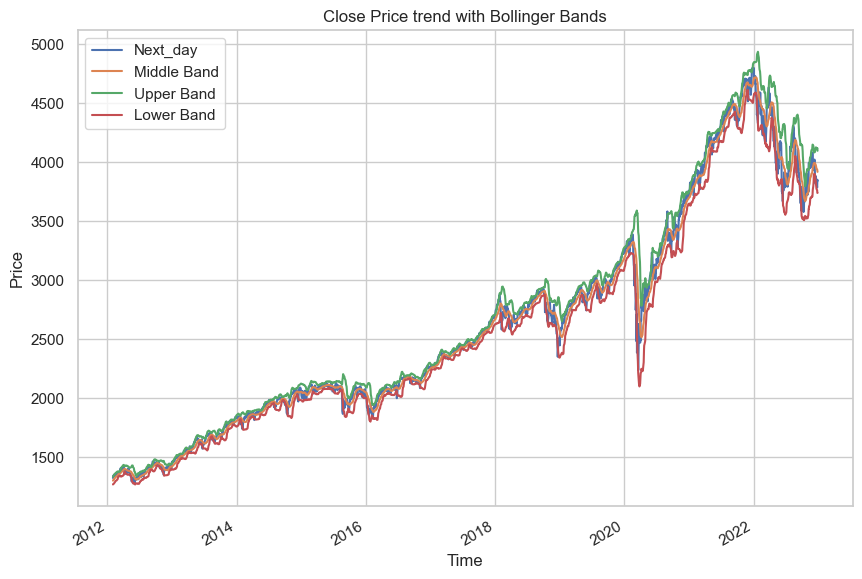

In [38]:
df[["Next_day","Middle Band", 'Upper Band', 'Lower Band']].plot(figsize=(10,7))
plt.legend(loc="best")
plt.xlabel("Time")
plt.ylabel("Price")
plt.title("Close Price trend with Bollinger Bands")

# 3. Data Scaling and Split to build LSTM
### Feature Engineering is done, Next_day column indicates the next day's close price of S&P 500, then this variable will be the target to predict.In next section, there will be an attempt to scale the original data and split this into test and train dataset for making LSTM model.

### Two methods.

### ==> Scale whole original dataset (df) and split into X and y and then split into test and train
### ==> Split and Scale X data only --> How does It work?


### 3.1 Data Dropping 

In [39]:
df = df.drop(["Adj Close","Volume","Close",'Short EMA', 'Log Returns','Long EMA', 'MACD Histogram'],axis = 1)

In [40]:
df

Open         High          Low  Pct_change       MACD  \
Date                                                                       
2012-02-01  1312.449951  1330.520020  1312.449951    0.008860  10.233442   
2012-02-02  1324.239990  1329.189941  1321.569946    0.001095  10.536886   
2012-02-03  1326.209961  1345.339966  1326.209961    0.014500  12.198936   
2012-02-06  1344.319946  1344.359985  1337.520020   -0.000424  13.316616   
2012-02-07  1344.329956  1349.239990  1335.920044    0.002021  14.257523   
...                 ...          ...          ...         ...        ...   
2022-12-22  3853.260010  3853.260010  3764.489990   -0.014557 -19.372789   
2022-12-23  3815.110107  3845.800049  3797.010010    0.005851 -22.033043   
2022-12-27  3843.340088  3846.649902  3813.219971   -0.004058 -25.108255   
2022-12-28  3829.560059  3848.320068  3780.780029   -0.012093 -30.903387   
2022-12-29  3805.449951  3858.189941  3805.449951    0.017311 -29.821809   

            Signal Line  Volatility  Middle Band    Std Dev   Upper Band  \
Date                                                                       
2012-02-01     9.327487    0.074587  1302.929510  16.282046  1335.493603   
2012-02-02     9.569367    0.074395  1305.341510  15.852955  1337.047420   
2012-02-03    10.095280    0.086900  1308.533508  17.085724  1342.704957   
2012-02-06    10.739548    0.085609  1311.859503  17.263786  1346.387076   
2012-02-07    11.443143    0.085623  1315.177008  17.335798  1349.848605   
...                 ...         ...          ...        ...          ...   
2022-12-22     4.133014    0.207804  3952.086499  83.758199  4119.602896   
2022-12-23    -1.100197    0.209846  3943.021497  85.123720  4113.268936   
2022-12-27    -5.901809    0.204098  3936.287000  88.637110  4113.561220   
2022-12-28   -10.902124    0.207383  3927.566504  94.792645  4117.151794   
2022-12-29   -14.686061    0.183737  3916.025000  89.125092  4094.275185   

             Lower Band     Next_day  
Date                                  
2012-02-01  1270.365418  1325.540039  
2012-02-02  1273.635600  1344.900024  
2012-02-03  1274.362059  1344.329956  
2012-02-06  1277.331930  1347.050049  
2012-02-07  1280.505411  1349.959961  
...                 ...          ...  
2022-12-22  3784.570102  3844.820068  
2022-12-23  3772.774057  3829.250000  
2022-12-27  3759.012779  3783.219971  
2022-12-28  3737.981214  3849.280029  
2022-12-29  3737.774815  3839.500000  

[2747 rows x 12 columns]

In [41]:
## normalize the dataset
#scaler = StandardScaler()
#scaler = scaler.fit(df)
#scaled_data = scaler.transform(df)

In [42]:
df.columns

Index(['Open', 'High', 'Low', 'Pct_change', 'MACD', 'Signal Line',
       'Volatility', 'Middle Band', 'Std Dev', 'Upper Band', 'Lower Band',
       'Next_day'],
      dtype='object')

### 3.2 Min-Max Scaling

In [43]:
scaler = MinMaxScaler()

scale_cols = ['Open', 'High', 'Low', 'Pct_change', 'MACD','Signal Line','Volatility','Middle Band', 'Std Dev',
       'Upper Band', 'Lower Band', 'Next_day']

scaled_df = scaler.fit_transform(df[scale_cols])

scaled_df = pd.DataFrame(scaled_df, columns=scale_cols)

print(scaled_df)

          Open      High       Low  Pct_change      MACD  Signal Line  \
0     0.009819  0.013566  0.013011    0.628119  0.750154     0.741354   
1     0.013162  0.013190  0.015606    0.592387  0.751075     0.742216   
2     0.013721  0.017757  0.016927    0.654067  0.756117     0.744091   
3     0.018856  0.017480  0.020146    0.585400  0.759508     0.746388   
4     0.018859  0.018860  0.019691    0.596652  0.762363     0.748896   
...        ...       ...       ...         ...       ...          ...   
2742  0.730271  0.726996  0.710941    0.520371  0.660330     0.722837   
2743  0.719454  0.724887  0.720198    0.614272  0.652259     0.704182   
2744  0.727458  0.725127  0.724811    0.568680  0.642929     0.687065   
2745  0.723551  0.725599  0.715578    0.531707  0.625347     0.669241   
2746  0.716715  0.728391  0.722600    0.667000  0.628628     0.655752   

      Volatility  Middle Band   Std Dev  Upper Band  Lower Band  Next_day  
0       0.044128     0.000000  0.035595    0.00

### 3.3 Data Scaling

In [44]:
features  = df.columns[:-1]

### 3.4 Making Sequence Data 

In [45]:
df.shape

(2747, 12)

In [46]:
# Split original data into input sequences and target values
lookback = 10 # Using past 10 days' daily data of below columns' data to predict the 'Next_day' price
data_columns = ['Open', 'High', 'Low', 'Pct_change', 'MACD', 'Signal Line', 'Volatility', 'Middle Band', 'Std Dev',
                'Upper Band', 'Lower Band']
target_columns = ['Next_day']

df_reset = df.reset_index(drop=True)

X = []
y = []

for i in range(len(df_reset) - lookback):
    X.append(df_reset.loc[i:i+lookback-1, data_columns].values)  # to select only the columns specified in data_columns
    y.append(df_reset.loc[i+lookback, target_columns].values[0])  # select the target value

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)


In [47]:
# Scale the input sequences (X)
scaler = MinMaxScaler()
#X = scaler.fit_transform(X_pca.reshape(X.shape[0], -1))
X = scaler.fit_transform(X.reshape(X.shape[0], -1))

# Scale the target variable (y)
y_scaler = MinMaxScaler()
y = y_scaler.fit_transform(y.reshape(-1, 1))

In [48]:
tscv = TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=200)
for train_index, test_index in tscv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

In [49]:
X_train = X_train.reshape((X_train.shape[0], lookback, -1))
X_test = X_test.reshape((X_test.shape[0], lookback, -1))

In [50]:
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(2537, 10, 11) (200, 10, 11)
(2537, 1) (200, 1)


# Building an LSTM Model

In [51]:
def build_bilstm_model(input_shape):
    model = Sequential()
    model.add(Bidirectional(LSTM(128, return_sequences=False), input_shape=input_shape))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [52]:
input_shape = (X_train.shape[1], X_train.shape[2])
bilstm_model = build_bilstm_model(input_shape)

#Setup Early stopping
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min')

# Train the model
history = bilstm_model.fit(X_train, y_train, epochs=50, batch_size=32, 
                           validation_data=(X_test, y_test), callbacks=[early_stopping])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Train on 2537 samples, validate on 200 samples
Epoch 1/50
 384/2537 [===>..........................] - ETA: 1s - loss: 0.0949 

2024-01-28 09:28:06.428796: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:375] MLIR V1 optimization pass is not enabled
2024-01-28 09:28:06.447474: W tensorflow/c/c_api.cc:304] Operation '{name:'training/Adam/dense_1/kernel/v/Assign' id:1125 op device:{requested: '', assigned: ''} def:{{{node training/Adam/dense_1/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/dense_1/kernel/v, training/Adam/dense_1/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


2537/2537 [==============================] - 1s 234us/sample - loss: 0.0171 - val_loss: 0.0019
Epoch 2/50
 576/2537 [=====>........................] - ETA: 0s - loss: 3.6034e-04

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
2024-01-28 09:28:06.975456: W tensorflow/c/c_api.cc:304] Operation '{name:'loss/mul' id:384 op device:{requested: '', assigned: ''} def:{{{node loss/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss/mul/x, loss/dense_1_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


2537/2537 [==============================] - 1s 222us/sample - loss: 3.6149e-04 - val_loss: 0.0016
Epoch 3/50
2537/2537 [==============================] - 1s 231us/sample - loss: 3.0826e-04 - val_loss: 0.0014
Epoch 4/50
2537/2537 [==============================] - 1s 271us/sample - loss: 2.6909e-04 - val_loss: 0.0013
Epoch 5/50
2537/2537 [==============================] - 1s 242us/sample - loss: 2.5085e-04 - val_loss: 0.0012
Epoch 6/50
2537/2537 [==============================] - 1s 244us/sample - loss: 2.2766e-04 - val_loss: 0.0015
Epoch 7/50
2537/2537 [==============================] - 1s 247us/sample - loss: 2.4551e-04 - val_loss: 0.0011
Epoch 8/50
2537/2537 [==============================] - 1s 248us/sample - loss: 2.2117e-04 - val_loss: 0.0011
Epoch 9/50
2537/2537 [==============================] - 1s 243us/sample - loss: 2.1810e-04 - val_loss: 0.0011
Epoch 10/50
2537/2537 [==============================] - 1s 265us/sample - loss: 2.0905e-04 - val_loss: 9.8801e-04
Epoch 11/50
2537

In [53]:
bilstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 256)               143360    
 al)                                                             
                                                                 
 dense (Dense)               (None, 25)                6425      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 149811 (585.20 KB)
Trainable params: 149811 (585.20 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
2024-01-28 09:28:36.846264: W tensorflow/c/c_api.cc:304] Operation '{name:'dense_1/BiasAdd' id:366 op device:{requested: '', assigned: ''} def:{{{node dense_1/BiasAdd}} = BiasAdd[T=DT_FLOAT, _has_manual_control_dependencies=true, data_format="NHWC"](dense_1/MatMul, dense_1/BiasAdd/ReadVariableOp)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


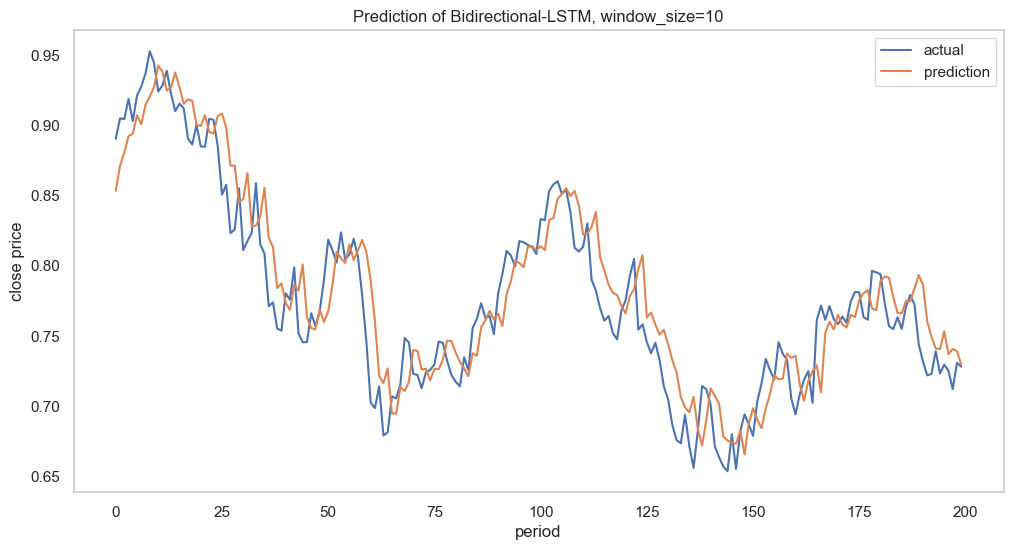

In [54]:
pred = bilstm_model.predict(X_test)
plt.figure(figsize=(12, 6))
plt.title('Prediction of Bidirectional-LSTM, window_size=10')
plt.ylabel('close price')
plt.xlabel('period')
plt.plot(y_test, label='actual')
plt.plot(pred, label='prediction')
plt.grid()
plt.legend(loc='best')

plt.show()
#Graph with scaled X and y

In [55]:
# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_test, pred))
mae = mean_absolute_error(y_test, pred)
mape = mean_absolute_percentage_error(y_test, pred)

print("RMSE:", rmse)
print("MAE:", mae)
print("MAPE :", mape)

RMSE: 0.02667660372021478
MAE: 0.021439239008386755
MAPE : 0.028031185951853076


In [56]:
#Inverse transformation to extract the real value from the scaled value
y_pred_original = y_scaler.inverse_transform(pred)
y_test_original = y_scaler.inverse_transform(y_test)

In [57]:
y_pred_original

array([[4281.272 ],
       [4343.938 ],
       [4377.2524],
       [4418.557 ],
       [4424.0513],
       [4471.097 ],
       [4447.9775],
       [4497.4673],
       [4518.2734],
       [4541.246 ],
       [4595.3955],
       [4580.474 ],
       [4532.901 ],
       [4540.979 ],
       [4578.1675],
       [4541.4604],
       [4499.4897],
       [4511.0073],
       [4507.2847],
       [4447.235 ],
       [4443.8447],
       [4470.51  ],
       [4429.481 ],
       [4424.9146],
       [4469.0737],
       [4474.712 ],
       [4439.5103],
       [4344.1465],
       [4344.191 ],
       [4250.7866],
       [4260.8545],
       [4325.614 ],
       [4192.21  ],
       [4193.597 ],
       [4216.7104],
       [4288.9175],
       [4163.652 ],
       [4139.8325],
       [4036.929 ],
       [4048.901 ],
       [3999.5583],
       [3981.9446],
       [4045.0195],
       [4031.1133],
       [4096.0747],
       [3964.081 ],
       [3936.3699],
       [3933.6655],
       [3983.6294],
       [3951.484 ],


In [58]:
y_test_original

array([[4411.66992188],
       [4463.12011719],
       [4461.18017578],
       [4511.60986328],
       [4456.24023438],
       [4520.16015625],
       [4543.06005859],
       [4575.52001953],
       [4631.60009766],
       [4602.45019531],
       [4530.41015625],
       [4545.85986328],
       [4582.64013672],
       [4525.12011719],
       [4481.14990234],
       [4500.20996094],
       [4488.27978516],
       [4412.52978516],
       [4397.45019531],
       [4446.58984375],
       [4392.58984375],
       [4391.68994141],
       [4462.20996094],
       [4459.45019531],
       [4393.66015625],
       [4271.77978516],
       [4296.12011719],
       [4175.20019531],
       [4183.95996094],
       [4287.5       ],
       [4131.93017578],
       [4155.37988281],
       [4175.47998047],
       [4300.16992188],
       [4146.87011719],
       [4123.33984375],
       [3991.23999023],
       [4001.05004883],
       [3935.17993164],
       [3930.08007812],
       [4023.88989258],
       [4008.010

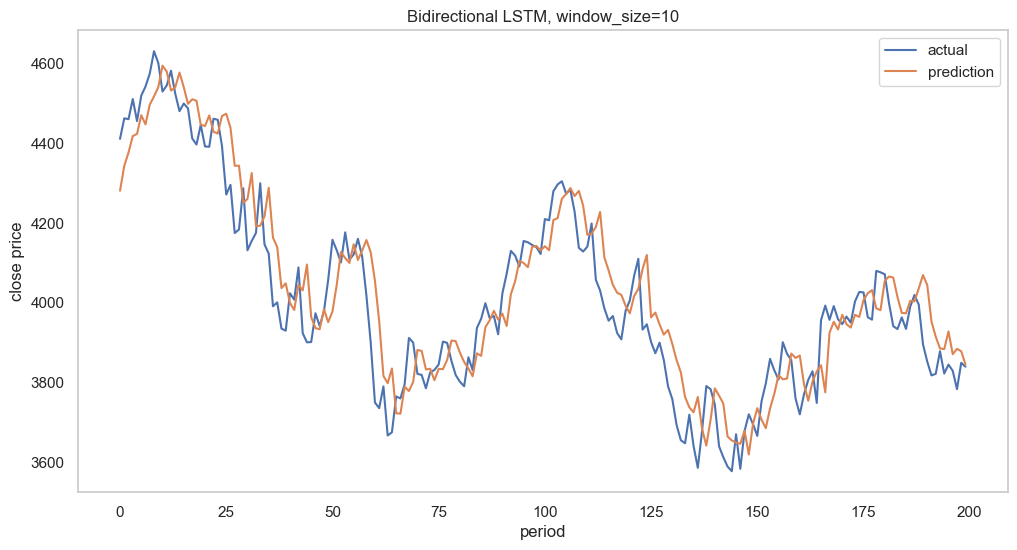

In [64]:
#Real values of prediction
plt.figure(figsize=(12, 6))
plt.title('Bidirectional LSTM, window_size=10')
plt.ylabel('close price')
plt.xlabel('period')
plt.plot(y_test_original, label='actual')
plt.plot(y_pred_original, label='prediction')
plt.grid()
plt.legend(loc='best')

plt.show()

In [65]:
# Calculate metrics with the real number value
real_rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
real_mae = mean_absolute_error(y_test_original, y_pred_original)
real_mape = mean_absolute_percentage_error(y_test_original, y_pred_original)
#Print each value
print("RMSE:", real_rmse)
print("MAE:",real_mae)
print("MAPE :", real_mape)

RMSE: 93.86219096003198
MAE: 75.43440795898437
MAPE : 0.018973989614554976


In [66]:
df_reset = df.reset_index()

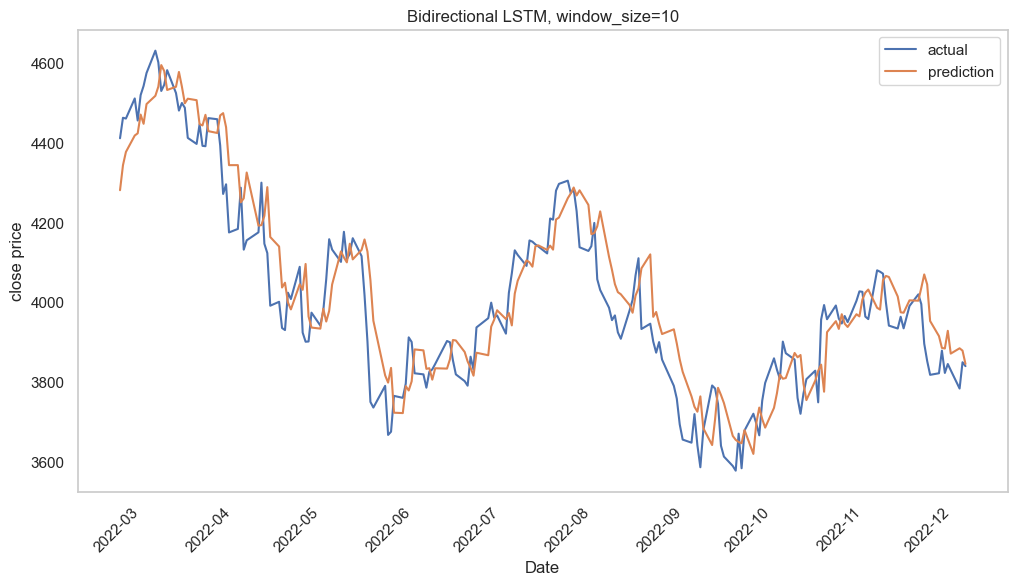

In [67]:
# 4. Extract the "Date" values for the test set
date_values_bi = df_reset['Date'].iloc[test_index].values

# Plotting
plt.figure(figsize=(12, 6))
plt.title('Bidirectional LSTM, window_size=10')
plt.ylabel('close price')
plt.xlabel('Date')
plt.plot(date_values_bi, y_test_original, label='actual')
plt.plot(date_values_bi, y_pred_original, label='prediction')
plt.xticks(rotation=45)  # Rotate date values for better visualization
plt.grid()
plt.legend(loc='best')
plt.show()


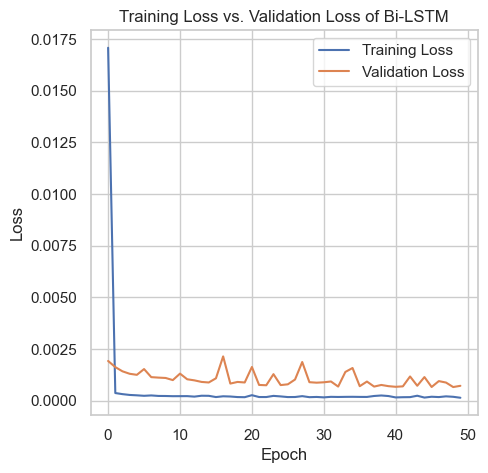

In [68]:
# Plot the training loss and validation loss over the epochs when X,y scaled
plt.figure(figsize=(5, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training Loss vs. Validation Loss of Bi-LSTM')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.show()

# 5. SHAP

In [69]:
# Use the training data for deep explainer => can use fewer instances
explainer_stock = shap.DeepExplainer(bilstm_model, X_train)
shap_values_stock = explainer_stock.shap_values(X_test)

keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


In [70]:
shap.initjs()

In [71]:
shap_values_stock[0][0].shape

(10, 11)

In [72]:
X_test.shape

(200, 10, 11)

In [73]:
shap_values_2D = shap_values_stock[0].reshape(-1,11)
X_test_2D = X_test.reshape(-1,11)


shap_values_2D.shape, X_test_2D.shape

((2000, 11), (2000, 11))

In [74]:
features  = df.columns[:-1]
#features = df.columns
XX = df[features]

In [75]:
mapping_dict = {f: column_name for f, column_name in zip(features, XX.columns)}

actual_column_names = [mapping_dict[feature_name] for feature_name in features]

In [76]:
x_test_2d = pd.DataFrame(data=X_test_2D, columns = actual_column_names)

In [78]:
x_test_2d.corr()

Open      High       Low  Pct_change      MACD  Signal Line  \
Open         1.000000  0.993463  0.991245   -0.069767  0.486932     0.458735   
High         0.993463  1.000000  0.992919    0.018367  0.468126     0.434606   
Low          0.991245  0.992919  1.000000    0.033052  0.513494     0.471656   
Pct_change  -0.069767  0.018367  0.033052    1.000000  0.014699    -0.062443   
MACD         0.486932  0.468126  0.513494    0.014699  1.000000     0.930220   
Signal Line  0.458735  0.434606  0.471656   -0.062443  0.930220     1.000000   
Volatility  -0.447310 -0.435075 -0.456711    0.043207 -0.583074    -0.692488   
Middle Band  0.845949  0.847265  0.822489   -0.103793  0.089107     0.220596   
Std Dev     -0.051137 -0.044757 -0.058849   -0.008428 -0.402367    -0.363553   
Upper Band   0.775244  0.778101  0.751409   -0.098880 -0.019879     0.112586   
Lower Band   0.860340  0.859901  0.838987   -0.101532  0.199655     0.320559   

             Volatility  Middle Band   Std Dev  Upper Band  Lower Band  
Open          -0.447310     0.845949 -0.051137    0.775244    0.860340  
High          -0.435075     0.847265 -0.044757    0.778101    0.859901  
Low           -0.456711     0.822489 -0.058849    0.751409    0.838987  
Pct_change     0.043207    -0.103793 -0.008428   -0.098880   -0.101532  
MACD          -0.583074     0.089107 -0.402367   -0.019879    0.199655  
Signal Line   -0.692488     0.220596 -0.363553    0.112586    0.320559  
Volatility     1.000000    -0.368907  0.376346   -0.247523   -0.472444  
Middle Band   -0.368907     1.000000  0.138797    0.967385    0.962302  
Std Dev        0.376346     0.138797  1.000000    0.385127   -0.135774  
Upper Band    -0.247523     0.967385  0.385127    1.000000    0.862026  
Lower Band    -0.472444     0.962302 -0.135774    0.862026    1.000000

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


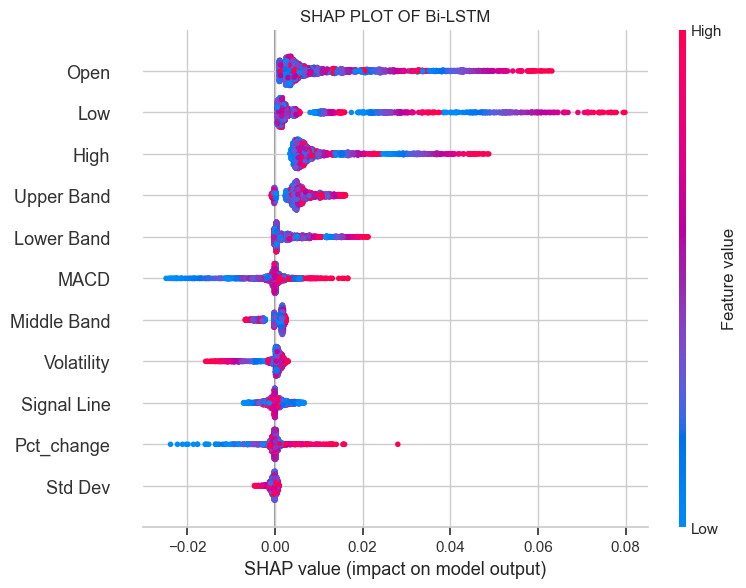

In [79]:
shap.summary_plot(shap_values_2D, x_test_2d, show = False)
plt.title("SHAP PLOT OF Bi-LSTM", loc='center')
plt.show()

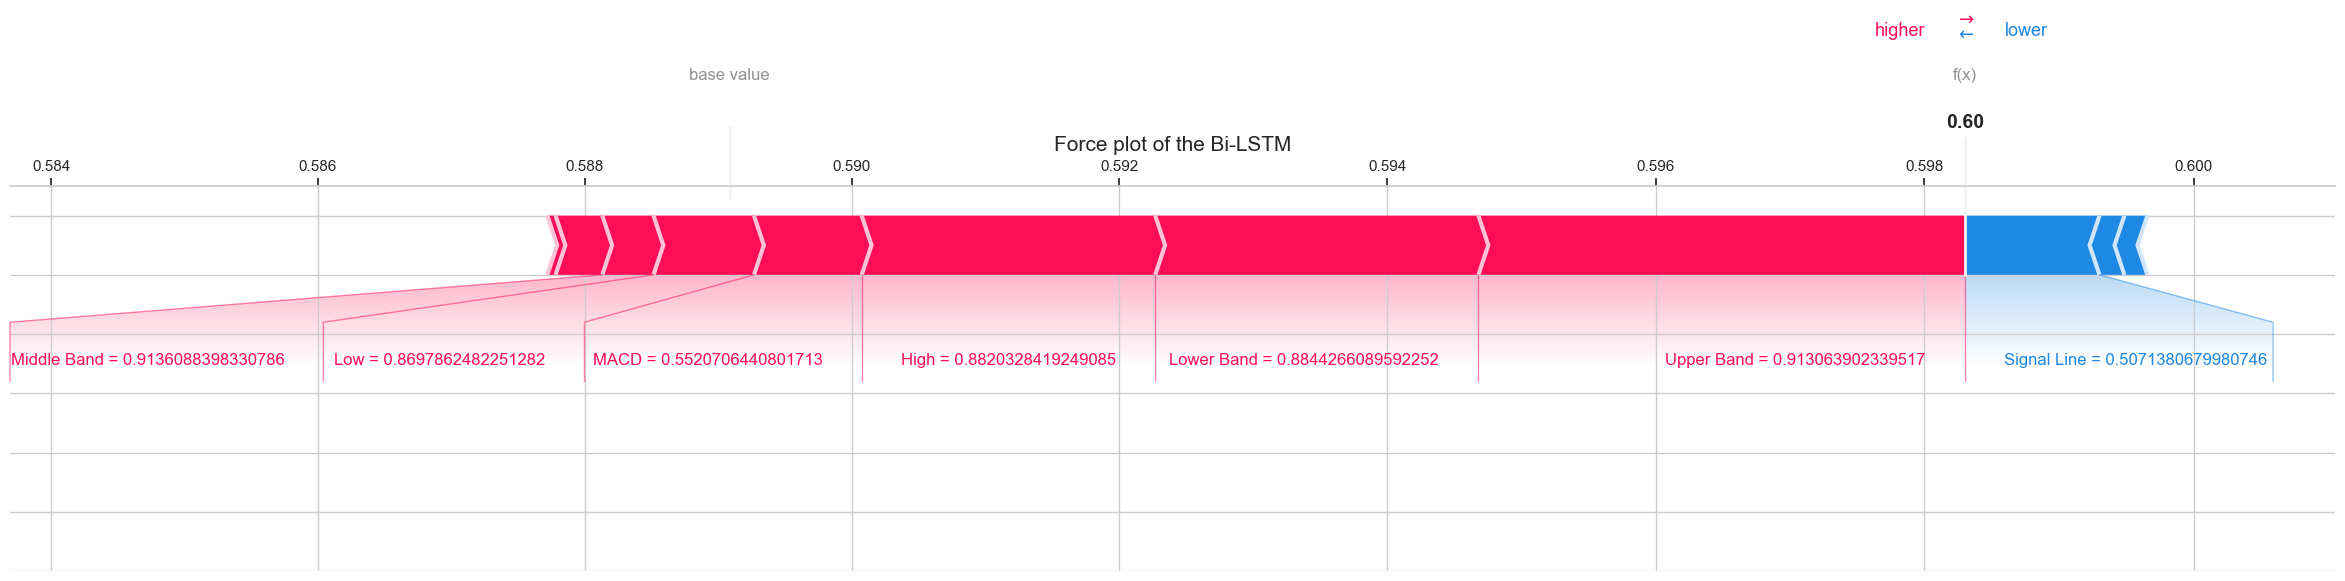

In [80]:
#Obtain Force Plot
expected_value_bi = explainer_stock.expected_value[0]

instance_index = 0 

shap.force_plot(expected_value_bi, shap_values_2D[instance_index], x_test_2d.iloc[instance_index],
                link='logit', matplotlib=True, show = False,figsize=(30,5))

plt.title("Force plot of the Bi-LSTM",fontsize=15)
plt.show()

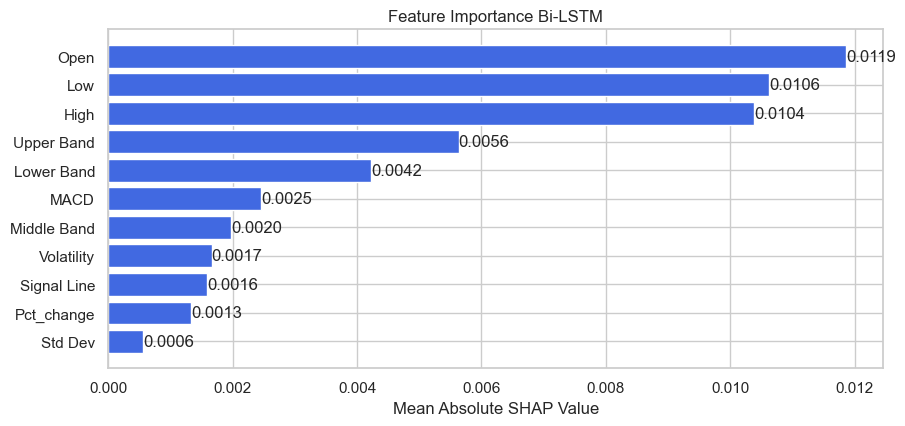

In [88]:
# Compute the mean absolute SHAP values for each feature
mean_shap_values_bi = np.abs(shap_values_2D).mean(axis=0)

# Sorting the features based on their mean absolute SHAP values
sorted_indices_bi = np.argsort(mean_shap_values_bi)[::-1]
sorted_features_bi = x_test_2d.columns[sorted_indices_bi]
sorted_shap_values_bi = mean_shap_values_bi[sorted_indices_bi]

# Create the bar plot
plt.figure(figsize=(10, len(sorted_features_bi) * 0.4))
plt.barh(sorted_features_bi, sorted_shap_values_bi, color='royalblue')
plt.xlabel('Mean Absolute SHAP Value')
plt.title('Feature Importance Bi-LSTM')

# Annotate each bar with its exact value
for index, value in enumerate(sorted_shap_values_bi):
    plt.text(value, index, f'{value:.4f}', va='center')

plt.gca().invert_yaxis()  # To display the most important feature at the top
plt.show()

Open      High       Low  Pct_change      MACD  Signal Line  \
0  0.863342  0.882033  0.869786     0.67234  0.552071     0.507138   

   Volatility  Middle Band   Std Dev  Upper Band  Lower Band  
0    0.213921     0.913609  0.309962    0.913064    0.884427

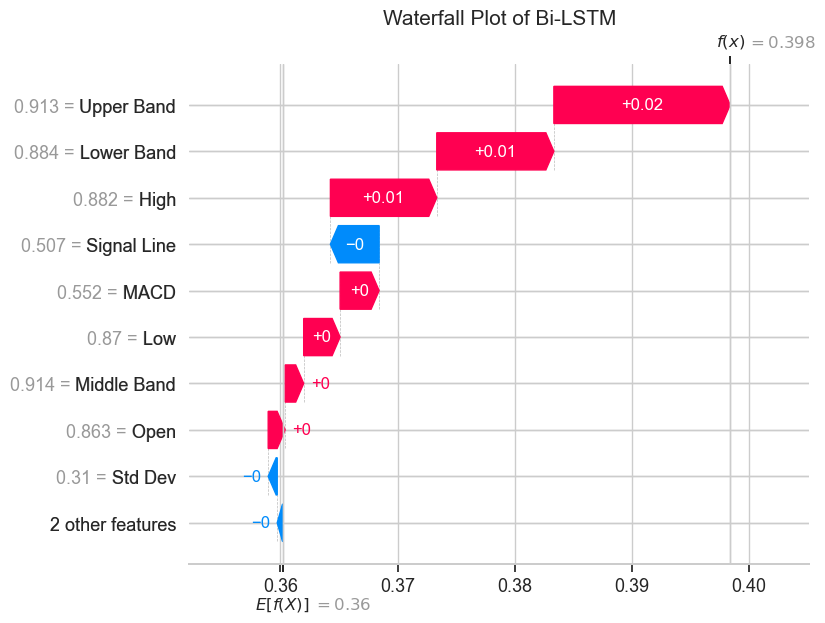

In [127]:
display(x_test_2d.loc[[0]])
shap_values_instance = shap_values_2D[0]
features_instance = x_test_2d.iloc[0]

# Create an Explanation object
explanation = shap.Explanation(values=shap_values_instance, base_values=expected_value_bi, data=features_instance)

# Use the shap.plots.waterfall function with the Explanation object
shap.plots.waterfall(explanation,show = False)

plt.title("Waterfall Plot of Bi-LSTM",fontsize=15)
plt.show()

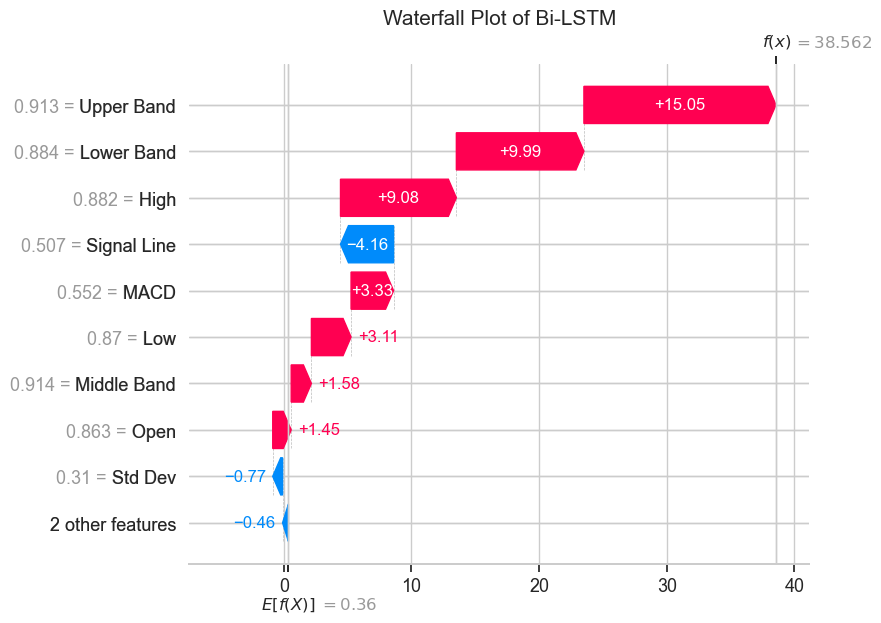

In [204]:
# Instance index you want to explain
instance_index_bi = 0

# Extract SHAP values and features for the selected instance
shap_values_instance_bi = shap_values_2D[instance_index_bi]
features_instance_bi = x_test_2d.iloc[instance_index_bi]

# Scale or round the SHAP values
shap_values_instance_bi_scaled = shap_values_instance_bi * 1000
shap_values_instance_bi_rounded = np.round(shap_values_instance_bi, 4)

# Create an Explanation object
expected_value_bi = explainer_stock.expected_value[0]
explanation_bi = shap.Explanation(values=shap_values_instance_bi_scaled, 
                                      base_values=expected_value_bi, data=features_instance_bi)

# Use the shap.waterfall_plot function with the Explanation object
shap.waterfall_plot(explanation_bi, show=False)

# Add the title
plt.title("Waterfall Plot of Bi-LSTM", fontsize=15)

# Show the plot
plt.show()


# Building Single Layered LSTM model

In [105]:
def build_single_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(128, return_sequences=False, input_shape= input_shape))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [106]:
input_shape = (X_train.shape[1], X_train.shape[2])
single_lstm_model = build_single_lstm_model(input_shape)
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min')
# Train the model

single_history = single_lstm_model.fit(X_train, y_train, epochs=50, batch_size=32, 
                    validation_data=(X_test, y_test), callbacks=[early_stopping])

Train on 2537 samples, validate on 200 samples
Epoch 1/50
 352/2537 [===>..........................] - ETA: 1s - loss: 0.1191 

2024-01-28 09:49:28.671901: W tensorflow/c/c_api.cc:304] Operation '{name:'training_2/Adam/dense_2/kernel/m/Assign' id:2743 op device:{requested: '', assigned: ''} def:{{{node training_2/Adam/dense_2/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_2/Adam/dense_2/kernel/m, training_2/Adam/dense_2/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


2537/2537 [==============================] - 1s 205us/sample - loss: 0.0188 - val_loss: 0.0021
Epoch 2/50
 800/2537 [========>.....................] - ETA: 0s - loss: 4.0930e-04

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
2024-01-28 09:49:29.117139: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_1/mul' id:2358 op device:{requested: '', assigned: ''} def:{{{node loss_1/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_1/mul/x, loss_1/dense_3_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


2537/2537 [==============================] - 0s 136us/sample - loss: 3.7341e-04 - val_loss: 0.0018
Epoch 3/50
2537/2537 [==============================] - 0s 139us/sample - loss: 2.9996e-04 - val_loss: 0.0014
Epoch 4/50
2537/2537 [==============================] - 0s 137us/sample - loss: 2.5672e-04 - val_loss: 0.0013
Epoch 5/50
2537/2537 [==============================] - 0s 141us/sample - loss: 2.2361e-04 - val_loss: 0.0011
Epoch 6/50
2537/2537 [==============================] - 0s 158us/sample - loss: 2.0702e-04 - val_loss: 0.0011
Epoch 7/50
2537/2537 [==============================] - 0s 153us/sample - loss: 1.9809e-04 - val_loss: 0.0011
Epoch 8/50
2537/2537 [==============================] - 0s 163us/sample - loss: 2.0314e-04 - val_loss: 0.0012
Epoch 9/50
2537/2537 [==============================] - 0s 144us/sample - loss: 1.9569e-04 - val_loss: 0.0010
Epoch 10/50
2537/2537 [==============================] - 0s 139us/sample - loss: 1.9887e-04 - val_loss: 0.0010
Epoch 11/50
2537/253

In [107]:
single_lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 128)               71680     
                                                                 
 dense_2 (Dense)             (None, 25)                3225      
                                                                 
 dense_3 (Dense)             (None, 1)                 26        
                                                                 
Total params: 74931 (292.70 KB)
Trainable params: 74931 (292.70 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
2024-01-28 09:49:44.740797: W tensorflow/c/c_api.cc:304] Operation '{name:'dense_3/BiasAdd' id:2340 op device:{requested: '', assigned: ''} def:{{{node dense_3/BiasAdd}} = BiasAdd[T=DT_FLOAT, _has_manual_control_dependencies=true, data_format="NHWC"](dense_3/MatMul, dense_3/BiasAdd/ReadVariableOp)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


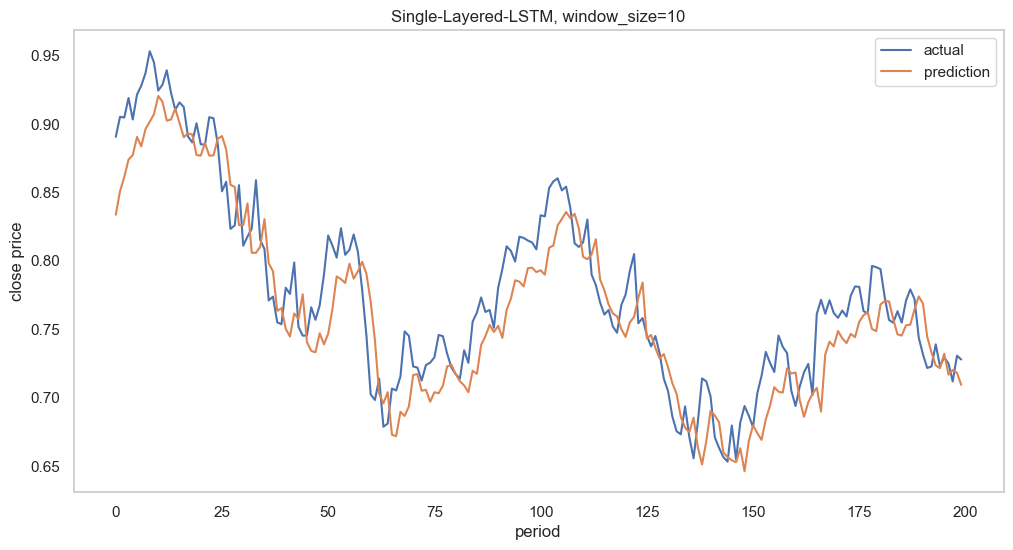

In [108]:
single_pred = single_lstm_model.predict(X_test)
plt.figure(figsize=(12, 6))
plt.title('Single-Layered-LSTM, window_size=10')
plt.ylabel('close price')
plt.xlabel('period')
plt.plot(y_test, label='actual')
plt.plot(single_pred, label='prediction')
plt.grid()
plt.legend(loc='best')

plt.show()


In [109]:
y_single_pred_original = y_scaler.inverse_transform(single_pred)
y_single_test_original = y_scaler.inverse_transform(y_test)

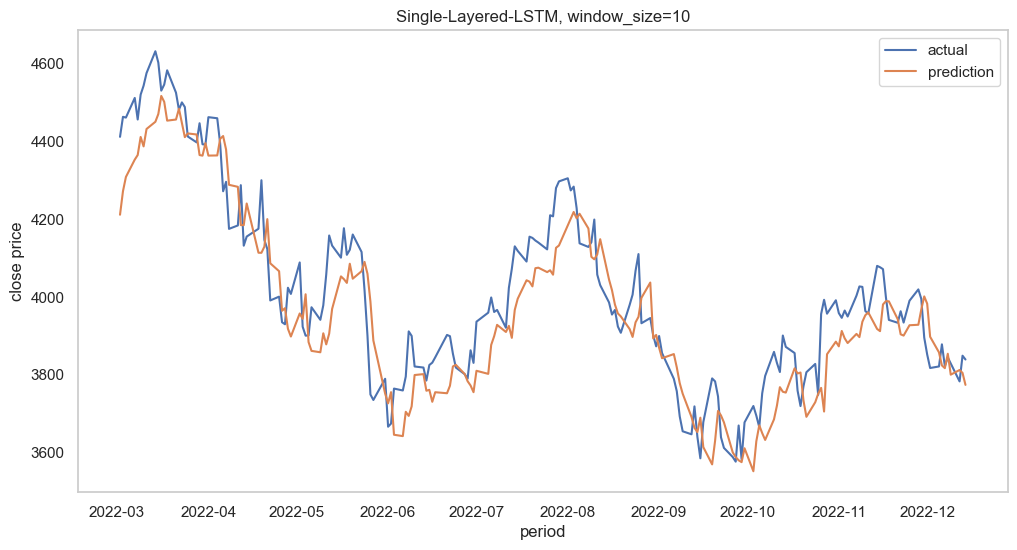

In [110]:
## Real values of prediction
plt.figure(figsize=(12, 6))
plt.title('Single-Layered-LSTM, window_size=10')
plt.ylabel('close price')
plt.xlabel('period')
plt.plot(date_values_bi,y_single_test_original, label='actual')
plt.plot(date_values_bi,y_single_pred_original, label='prediction')
plt.grid()
plt.legend(loc='best')

plt.show()

In [111]:
# Calculate error metrics
real_rmse_single = np.sqrt(mean_squared_error(y_single_test_original, y_single_pred_original))
real_mae_single = mean_absolute_error(y_single_test_original, y_single_pred_original)
real_mape_single = mean_absolute_percentage_error(y_single_test_original, y_single_pred_original)

# Print each value
print("RMSE of Single-Layered-LSTM :", real_rmse_single)
print("MAE of Single-Layered-LSTM :", real_mae_single)
print("MAPE of Single-Layered-LSTM :", real_mape_single)

RMSE of Single-Layered-LSTM : 101.43010432286614
MAE of Single-Layered-LSTM : 84.4316845703125
MAPE of Single-Layered-LSTM : 0.020961128515828792


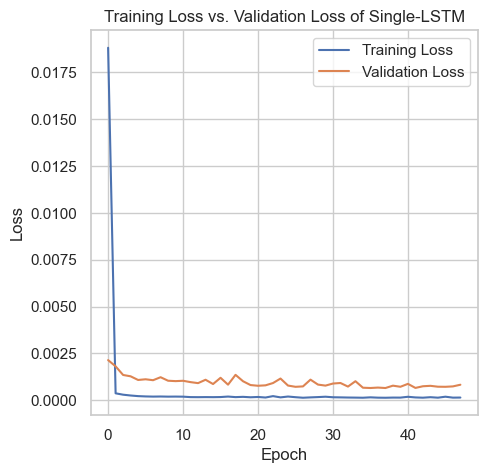

In [112]:
# Plot the training loss and validation loss over the epochs
plt.figure(figsize=(5, 5))
plt.plot(single_history.history['loss'])
plt.plot(single_history.history['val_loss'])
plt.title('Training Loss vs. Validation Loss of Single-LSTM')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.show()

# SHAP for Single Layer

In [113]:
# Use the training data for deep explainer
explainer_stock_single = shap.DeepExplainer(single_lstm_model, X_train)
shap_values_stock_single = explainer_stock_single.shap_values(X_test)

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


In [114]:
shap_values_stock_single[0][0].shape

(10, 11)

In [115]:
shap_values_single_2D = shap_values_stock_single[0].reshape(-1,11)
X_test_single_2D = X_test.reshape(-1,11)

shap_values_single_2D.shape, X_test_single_2D.shape

((2000, 11), (2000, 11))

In [116]:
X_test_single_2D

array([[0.86334219, 0.88203284, 0.86978625, ..., 0.30996219, 0.9130639 ,
        0.88442661],
       [0.88567191, 0.88635962, 0.8763328 , ..., 0.28487082, 0.90567632,
        0.88557521],
       [0.86888848, 0.86524588, 0.85908973, ..., 0.2858141 , 0.90365043,
        0.88318017],
       ...,
       [0.71945373, 0.72488665, 0.72019753, ..., 0.26393065, 0.77193776,
        0.7494452 ],
       [0.7274584 , 0.72512699, 0.72481142, ..., 0.27558394, 0.77201916,
        0.74532395],
       [0.72355105, 0.72559932, 0.71557795, ..., 0.29600074, 0.77301912,
        0.73902538]])

In [117]:
features  = df.columns[:-1]
#features = df.columns
XX = df[features]

In [118]:
mapping_dict = {f: column_name for f, column_name in zip(features, XX.columns)}
actual_column_names = [mapping_dict[feature_name] for feature_name in features]

In [119]:
x_test_single_2d = pd.DataFrame(data=X_test_single_2D, columns = actual_column_names)

In [120]:
actual_column_names

['Open',
 'High',
 'Low',
 'Pct_change',
 'MACD',
 'Signal Line',
 'Volatility',
 'Middle Band',
 'Std Dev',
 'Upper Band',
 'Lower Band']

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


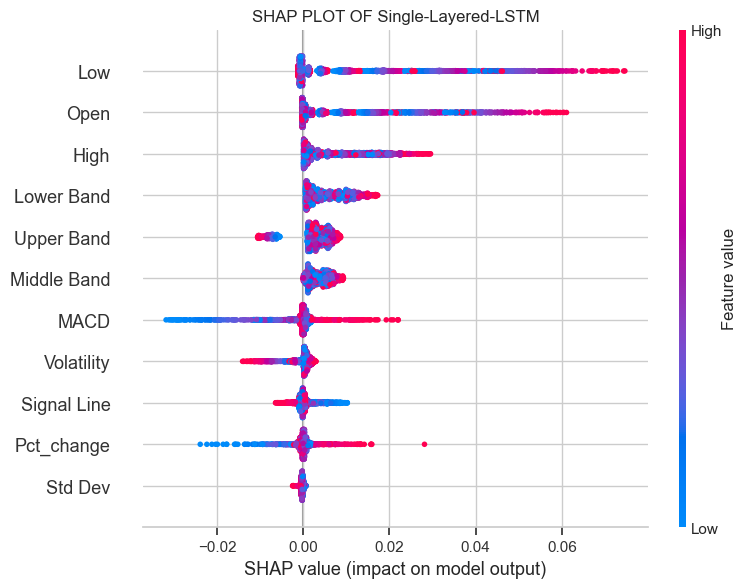

In [121]:
shap.summary_plot(shap_values_single_2D, x_test_single_2d, show = False)
plt.title("SHAP PLOT OF Single-Layered-LSTM", loc='center')
plt.show()

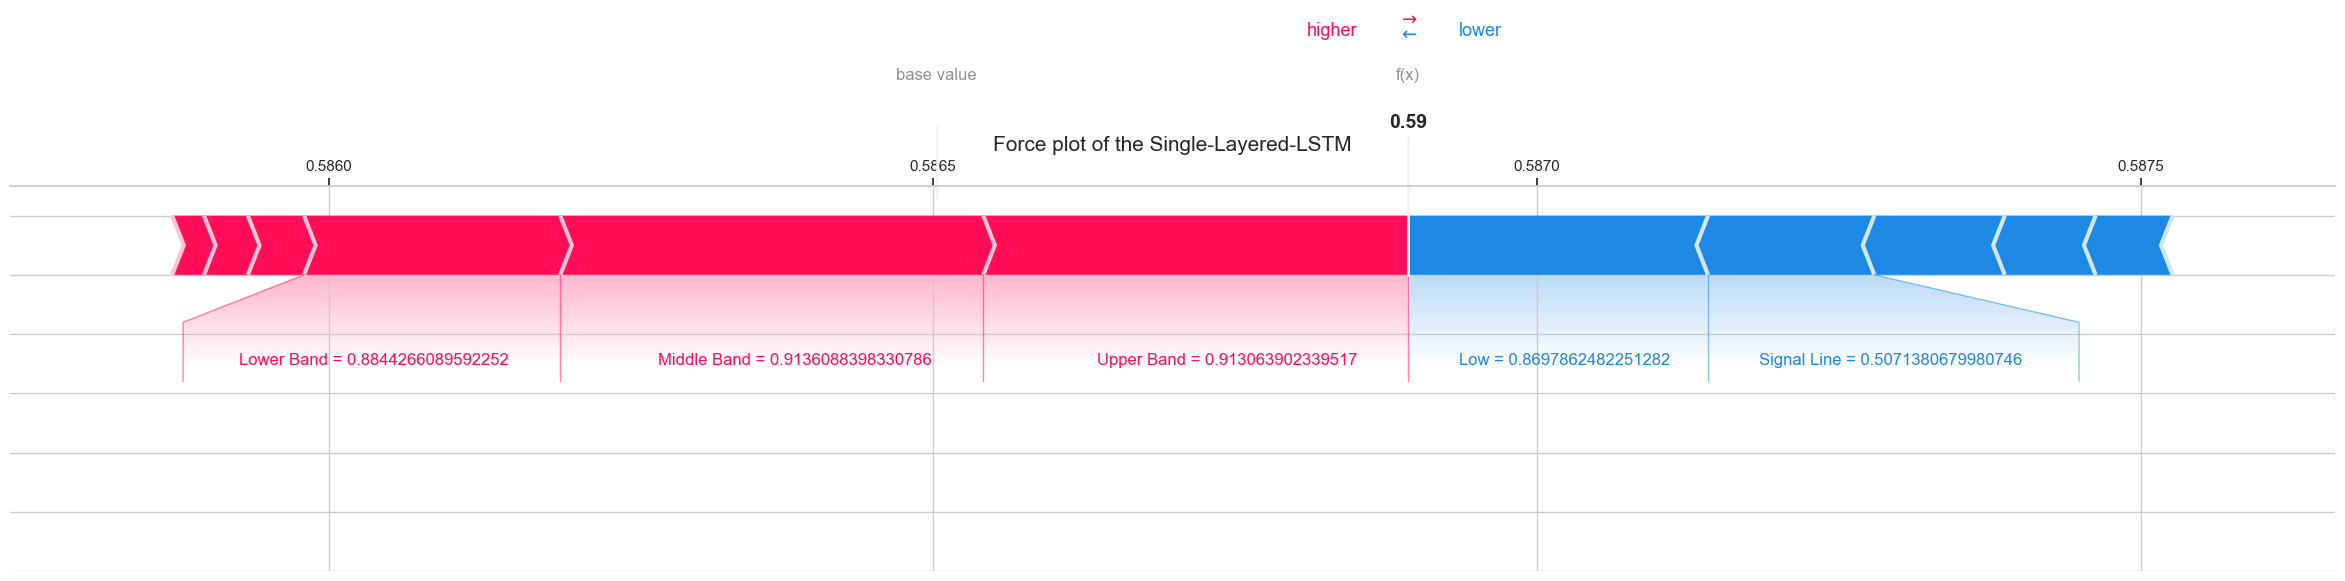

In [122]:
#Obtain Force Plot
expected_value_single = explainer_stock_single.expected_value[0]

instance_index = 0  

shap.force_plot(expected_value_single, shap_values_single_2D[instance_index], x_test_single_2d.iloc[instance_index],
                link='logit', matplotlib=True, show = False,figsize=(30,5))

plt.title("Force plot of the Single-Layered-LSTM", fontsize=15)
plt.show()

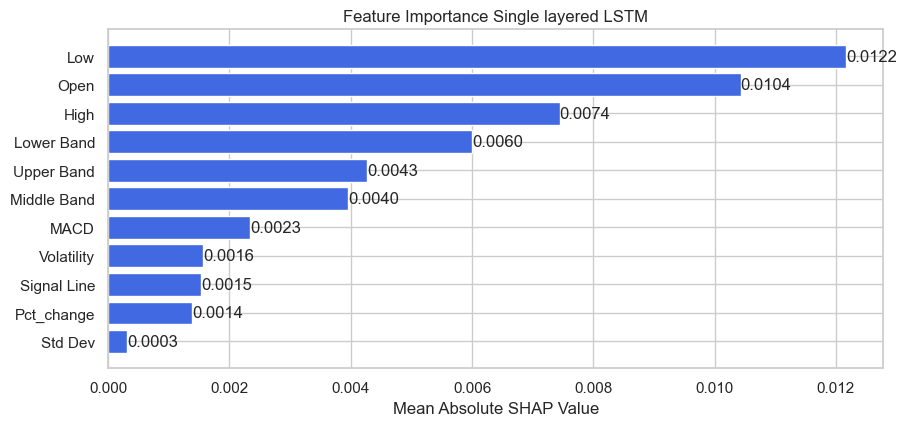

In [123]:
# Compute the mean absolute SHAP values for each feature
mean_shap_values_sin = np.abs(shap_values_single_2D).mean(axis=0)

# Sorting the features based on their mean absolute SHAP values
sorted_indices_sin = np.argsort(mean_shap_values_sin)[::-1]
sorted_features_sin = x_test_single_2d.columns[sorted_indices_sin]
sorted_shap_values_sin = mean_shap_values_sin[sorted_indices_sin]

# Create the bar plot
plt.figure(figsize=(10, len(sorted_features_sin) * 0.4))
plt.barh(sorted_features_sin, sorted_shap_values_sin, color='royalblue')
plt.xlabel('Mean Absolute SHAP Value')
plt.title('Feature Importance Single layered LSTM')

# Annotate each bar with its exact value
for index, value in enumerate(sorted_shap_values_sin):
    plt.text(value, index, f'{value:.4f}', va='center')

plt.gca().invert_yaxis()  # To display the most important feature at the top
plt.show()

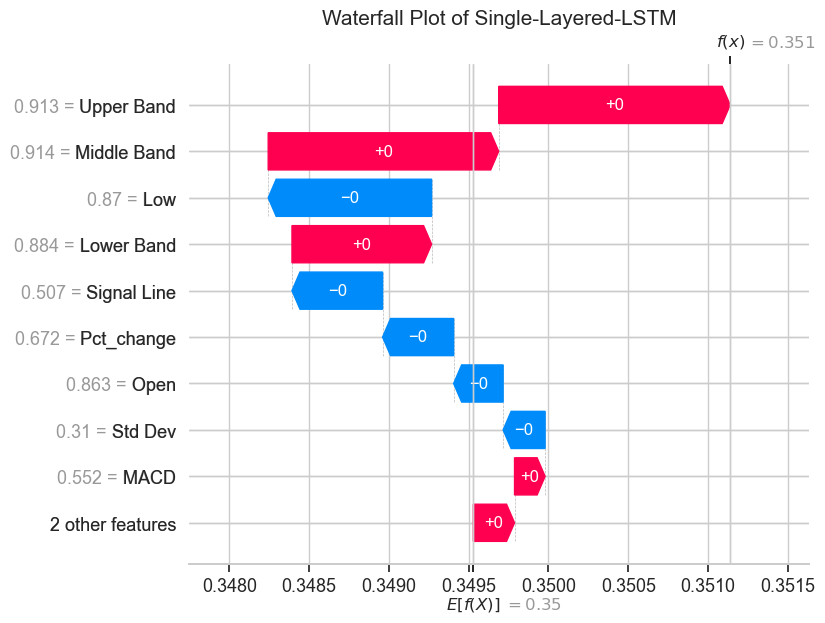

In [132]:
# Instance index you want to explain
instance_index_single = 0

# Extract SHAP values and features for the selected instance
shap_values_instance_single = shap_values_single_2D[instance_index_single]
features_instance_single = x_test_single_2d.iloc[instance_index_single]

# Create an Explanation object
explanation_single = shap.Explanation(values=shap_values_instance_single,
                                      base_values=expected_value_single, data=features_instance_single)

# Use the shap.plots.waterfall function with the Explanation object
#shap.plots.waterfall(explanation_single, show=False)
shap.plots.waterfall(explanation_single, show=False, max_display=10)

# Add a title using Matplotlib
plt.title("Waterfall Plot of Single-Layered-LSTM", fontsize=15)

# Show the plot
plt.show()

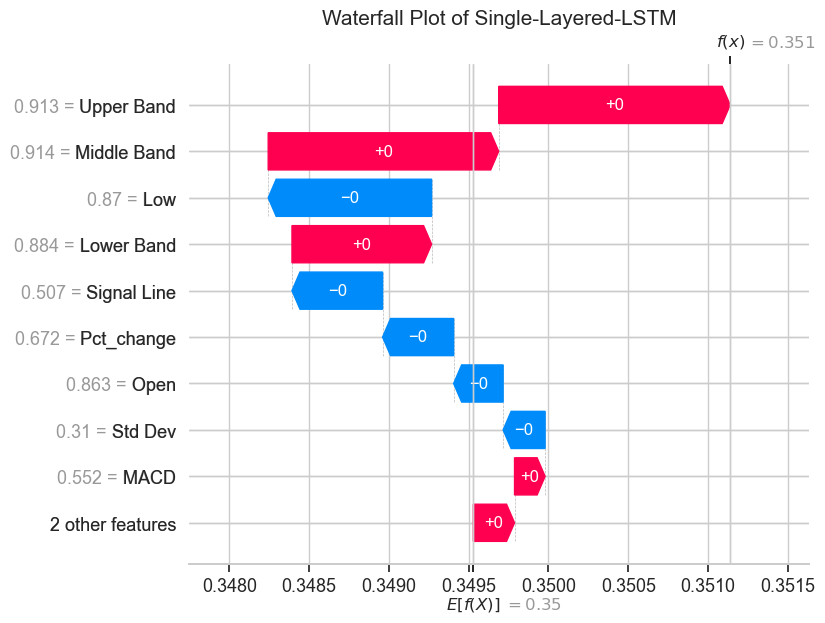

In [137]:
#fig = plt.subplots(figsize=(6,6),dpi=150)
#ax_3= shap.plots._waterfall.waterfall_legacy(explainercat.expected_value, shap_values_cat_test[15],
                                             #feature_names = X_test.columns,max_display = 20)

# Assuming you have calculated shap_values_single_2D and x_test_single_2d as you've shown in your code

# Instance index you want to explain
instance_index_single = 0

# Extract SHAP values and features for the selected instance
shap_values_instance_single = shap_values_single_2D[instance_index_single]
features_instance_single = x_test_single_2d.iloc[instance_index_single]

# Create an Explanation object
expected_value_single = explainer_stock_single.expected_value[0]
explanation_single = shap.Explanation(values=shap_values_instance_single, 
                                      base_values=expected_value_single, data=features_instance_single)

# Use the shap.waterfall_plot function with the Explanation object
shap.waterfall_plot(explanation_single, show=False)

# Add the title
plt.title("Waterfall Plot of Single-Layered-LSTM", fontsize=15)

# Show the plot
plt.show()


In [138]:
# Print SHAP values for debugging
print("SHAP Values:", shap_values_instance_single)

# Print features for debugging
print("Features:", features_instance_single)

SHAP Values: [-0.00031005  0.00014991 -0.0010237  -0.0004452   0.00019151 -0.00056761
  0.00010852  0.00144404 -0.000263    0.00145038  0.0008747 ]
Features: Open           0.863342
High           0.882033
Low            0.869786
Pct_change     0.672340
MACD           0.552071
Signal Line    0.507138
Volatility     0.213921
Middle Band    0.913609
Std Dev        0.309962
Upper Band     0.913064
Lower Band     0.884427
Name: 0, dtype: float64


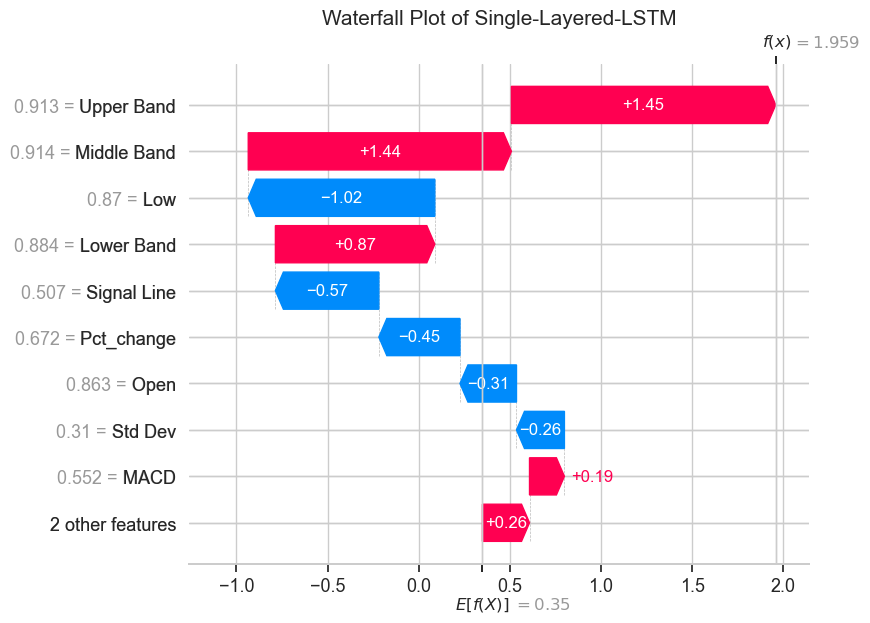

In [145]:
# Instance index you want to explain
instance_index_single = 0

# Extract SHAP values and features for the selected instance
shap_values_instance_single = shap_values_single_2D[instance_index_single]
features_instance_single = x_test_single_2d.iloc[instance_index_single]

# Scale or round the SHAP values
shap_values_instance_single_scaled = shap_values_instance_single * 1000
shap_values_instance_single_rounded = np.round(shap_values_instance_single, 4)

# Create an Explanation object
expected_value_single = explainer_stock_single.expected_value[0]
explanation_single = shap.Explanation(values=shap_values_instance_single_scaled, 
                                      base_values=expected_value_single, data=features_instance_single)

# Use the shap.waterfall_plot function with the Explanation object
shap.waterfall_plot(explanation_single, show=False)

# Add the title
plt.title("Waterfall Plot of Single-Layered-LSTM", fontsize=15)

# Show the plot
plt.show()


# Testing with PCA data

In [148]:
df_pca = yf.download('^GSPC', start='2012-01-01', end='2022-12-31')
#df = pd.read_csv("/Users/parkjs9416/Documents/Dissertation/Dissertation_project_code_and_data/Dataset/sp500_10year_data.csv")
df_pca

[*********************100%***********************]  1 of 1 completed


Open         High          Low        Close    Adj Close  \
Date                                                                          
2012-01-03  1258.859985  1284.619995  1258.859985  1277.060059  1277.060059   
2012-01-04  1277.030029  1278.729980  1268.099976  1277.300049  1277.300049   
2012-01-05  1277.300049  1283.050049  1265.260010  1281.060059  1281.060059   
2012-01-06  1280.930054  1281.839966  1273.339966  1277.810059  1277.810059   
2012-01-09  1277.829956  1281.989990  1274.550049  1280.699951  1280.699951   
...                 ...          ...          ...          ...          ...   
2022-12-23  3815.110107  3845.800049  3797.010010  3844.820068  3844.820068   
2022-12-27  3843.340088  3846.649902  3813.219971  3829.250000  3829.250000   
2022-12-28  3829.560059  3848.320068  3780.780029  3783.219971  3783.219971   
2022-12-29  3805.449951  3858.189941  3805.449951  3849.280029  3849.280029   
2022-12-30  3829.060059  3839.850098  3800.340088  3839.500000  3839.500000   

                Volume  
Date                    
2012-01-03  3943710000  
2012-01-04  3592580000  
2012-01-05  4315950000  
2012-01-06  3656830000  
2012-01-09  3371600000  
...                ...  
2022-12-23  2819280000  
2022-12-27  3030300000  
2022-12-28  3083520000  
2022-12-29  3003680000  
2022-12-30  2979870000  

[2768 rows x 6 columns]

In [149]:
df_pca_reset = df_pca.reset_index()

In [150]:
#Making the percentage changes in each day
df_pca['Pct_change'] = df_pca['Close'].pct_change()
# data['Pct_change'] = np.log(1+data['Pct_change'])
df_pca['Pct_change'] = np.log1p(df_pca['Pct_change'])
# Choose the desired time periods for the moving averages
short_period = 12  # Short-term EMA period
long_period = 26  # Long-term EMA period
signal_period = 9  # Signal line EMA period

# Calculate the short-term EMA
df_pca['Short EMA'] = df_pca['Close'].ewm(span=short_period, adjust=False).mean()

# Calculate the long-term EMA
df_pca['Long EMA'] = df_pca['Close'].ewm(span=long_period, adjust=False).mean()

# Calculate the MACD line
df_pca['MACD'] = df_pca['Short EMA'] - df_pca['Long EMA']

# Calculate the signal line
df_pca['Signal Line'] = df_pca['MACD'].ewm(span=signal_period, adjust=False).mean()

# Calculate the MACD histogram
df_pca['MACD Histogram'] = df_pca['MACD'] - df_pca['Signal Line']
# Choose the desired time period for the moving average and standard deviation
window = 20  # Number of Trading days in a month
num_std = 2  
# 2 standard deviations above and below the middle band provides 
#a range that encompasses a large portion of typical price movements

# Calculate the logarithmic returns
df_pca['Log Returns'] = np.log(df_pca['Close'] / df_pca['Close'].shift(1))

# Calculate the volatility
df_pca['Volatility'] = df_pca['Log Returns'].rolling(window=20).std() * np.sqrt(252)

# Calculate the middle band (simple moving average)
df_pca['Middle Band'] = df_pca['Close'].rolling(window=window).mean()

# Calculate the standard deviation of the closing prices
df_pca['Std Dev'] = df_pca['Close'].rolling(window=window).std()

# Calculate the upper band and lower band
df_pca['Upper Band'] = df_pca['Middle Band'] + (num_std * df_pca['Std Dev'])
df_pca['Lower Band'] = df_pca['Middle Band'] - (num_std * df_pca['Std Dev'])

#Making Next day's close price column in each date.
df_pca['Next_day'] = df_pca['Close'].shift(-1)


# Display the updated DataFrame with the Bollinger Bands columns
df_pca

Open         High          Low        Close    Adj Close  \
Date                                                                          
2012-01-03  1258.859985  1284.619995  1258.859985  1277.060059  1277.060059   
2012-01-04  1277.030029  1278.729980  1268.099976  1277.300049  1277.300049   
2012-01-05  1277.300049  1283.050049  1265.260010  1281.060059  1281.060059   
2012-01-06  1280.930054  1281.839966  1273.339966  1277.810059  1277.810059   
2012-01-09  1277.829956  1281.989990  1274.550049  1280.699951  1280.699951   
...                 ...          ...          ...          ...          ...   
2022-12-23  3815.110107  3845.800049  3797.010010  3844.820068  3844.820068   
2022-12-27  3843.340088  3846.649902  3813.219971  3829.250000  3829.250000   
2022-12-28  3829.560059  3848.320068  3780.780029  3783.219971  3783.219971   
2022-12-29  3805.449951  3858.189941  3805.449951  3849.280029  3849.280029   
2022-12-30  3829.060059  3839.850098  3800.340088  3839.500000  3839.500000   

                Volume  Pct_change    Short EMA     Long EMA       MACD  \
Date                                                                      
2012-01-03  3943710000         NaN  1277.060059  1277.060059   0.000000   
2012-01-04  3592580000    0.000188  1277.096980  1277.077836   0.019145   
2012-01-05  4315950000    0.002939  1277.706685  1277.372815   0.333869   
2012-01-06  3656830000   -0.002540  1277.722588  1277.405204   0.317385   
2012-01-09  3371600000    0.002259  1278.180644  1277.649259   0.531385   
...                ...         ...          ...          ...        ...   
2022-12-23  2819280000    0.005851  3888.259239  3910.292282 -22.033043   
2022-12-27  3030300000   -0.004058  3879.180894  3904.289150 -25.108255   
2022-12-28  3083520000   -0.012093  3864.417675  3895.321062 -30.903387   
2022-12-29  3003680000    0.017311  3862.088807  3891.910615 -29.821809   
2022-12-30  2979870000   -0.002544  3858.613606  3888.028348 -29.414742   

            Signal Line  MACD Histogram  Log Returns  Volatility  Middle Band  \
Date                                                                            
2012-01-03     0.000000        0.000000          NaN         NaN          NaN   
2012-01-04     0.003829        0.015316     0.000188         NaN          NaN   
2012-01-05     0.069837        0.264032     0.002939         NaN          NaN   
2012-01-06     0.119347        0.198038    -0.002540         NaN          NaN   
2012-01-09     0.201754        0.329631     0.002259         NaN          NaN   
...                 ...             ...          ...         ...          ...   
2022-12-23    -1.100197      -20.932846     0.005851    0.209846  3943.021497   
2022-12-27    -5.901809      -19.206447    -0.004058    0.204098  3936.287000   
2022-12-28   -10.902124      -20.001263    -0.012093    0.207383  3927.566504   
2022-12-29   -14.686061      -15.135747     0.017311    0.183737  3916.025000   
2022-12-30   -17.631797      -11.782945    -0.002544    0.183586  3904.171497   

              Std Dev   Upper Band   Lower Band     Next_day  
Date                                                          
2012-01-03        NaN          NaN          NaN  1277.300049  
2012-01-04        NaN          NaN          NaN  1281.060059  
2012-01-05        NaN          NaN          NaN  1277.810059  
2012-01-06        NaN          NaN          NaN  1280.699951  
2012-01-09        NaN          NaN          NaN  1292.079956  
...               ...          ...          ...          ...  
2022-12-23  85.123720  4113.268936  3772.774057  3829.250000  
2022-12-27  88.637110  4113.561220  3759.012779  3783.219971  
2022-12-28  94.792645  4117.151794  3737.981214  3849.280029  
2022-12-29  89.125092  4094.275185  3737.774815  3839.500000  
2022-12-30  82.140318  4068.452133  3739.890860          NaN  

[2768 rows x 19 columns]

In [151]:
df_pca.isnull().sum()

Open               0
High               0
Low                0
Close              0
Adj Close          0
Volume             0
Pct_change         1
Short EMA          0
Long EMA           0
MACD               0
Signal Line        0
MACD Histogram     0
Log Returns        1
Volatility        20
Middle Band       19
Std Dev           19
Upper Band        19
Lower Band        19
Next_day           1
dtype: int64

In [152]:
df_pca=df_pca.dropna()

# Making PCA dataset

In [153]:
scaler = MinMaxScaler()

scale_cols = ['Open', 'High', 'Low', 'Pct_change', 'MACD','Signal Line','Volatility','Middle Band', 'Std Dev',
       'Upper Band', 'Lower Band', 'Next_day']

scaled_df_pca = scaler.fit_transform(df_pca[scale_cols])

scaled_df_pca = pd.DataFrame(scaled_df_pca, columns=scale_cols)

print(scaled_df_pca)

          Open      High       Low  Pct_change      MACD  Signal Line  \
0     0.009819  0.013566  0.013011    0.628119  0.750154     0.741354   
1     0.013162  0.013190  0.015606    0.592387  0.751075     0.742216   
2     0.013721  0.017757  0.016927    0.654067  0.756117     0.744091   
3     0.018856  0.017480  0.020146    0.585400  0.759508     0.746388   
4     0.018859  0.018860  0.019691    0.596652  0.762363     0.748896   
...        ...       ...       ...         ...       ...          ...   
2742  0.730271  0.726996  0.710941    0.520371  0.660330     0.722837   
2743  0.719454  0.724887  0.720198    0.614272  0.652259     0.704182   
2744  0.727458  0.725127  0.724811    0.568680  0.642929     0.687065   
2745  0.723551  0.725599  0.715578    0.531707  0.625347     0.669241   
2746  0.716715  0.728391  0.722600    0.667000  0.628628     0.655752   

      Volatility  Middle Band   Std Dev  Upper Band  Lower Band  Next_day  
0       0.044128     0.000000  0.035595    0.00

In [154]:
from sklearn.decomposition import PCA

In [155]:
scaled_df_pca

Open      High       Low  Pct_change      MACD  Signal Line  \
0     0.009819  0.013566  0.013011    0.628119  0.750154     0.741354   
1     0.013162  0.013190  0.015606    0.592387  0.751075     0.742216   
2     0.013721  0.017757  0.016927    0.654067  0.756117     0.744091   
3     0.018856  0.017480  0.020146    0.585400  0.759508     0.746388   
4     0.018859  0.018860  0.019691    0.596652  0.762363     0.748896   
...        ...       ...       ...         ...       ...          ...   
2742  0.730271  0.726996  0.710941    0.520371  0.660330     0.722837   
2743  0.719454  0.724887  0.720198    0.614272  0.652259     0.704182   
2744  0.727458  0.725127  0.724811    0.568680  0.642929     0.687065   
2745  0.723551  0.725599  0.715578    0.531707  0.625347     0.669241   
2746  0.716715  0.728391  0.722600    0.667000  0.628628     0.655752   

      Volatility  Middle Band   Std Dev  Upper Band  Lower Band  Next_day  
0       0.044128     0.000000  0.035595    0.000000    0.000019  0.013500  
1       0.043925     0.000707  0.034172    0.000432    0.000999  0.019002  
2       0.057141     0.001642  0.038261    0.002005    0.001216  0.018840  
3       0.055776     0.002616  0.038851    0.003029    0.002106  0.019613  
4       0.055792     0.003588  0.039090    0.003991    0.003056  0.020440  
...          ...          ...       ...         ...         ...       ...  
2742    0.184929     0.776092  0.259401    0.774076    0.752978  0.729506  
2743    0.187087     0.773436  0.263931    0.772315    0.749445  0.725080  
2744    0.181012     0.771463  0.275584    0.772396    0.745324  0.711998  
2745    0.184483     0.768909  0.296001    0.773395    0.739025  0.730773  
2746    0.159491     0.765527  0.277202    0.767034    0.738964  0.727994  

[2747 rows x 12 columns]

In [156]:
pca = PCA()
X_pca = pca.fit_transform(scaled_df_pca)
# Calculate the cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

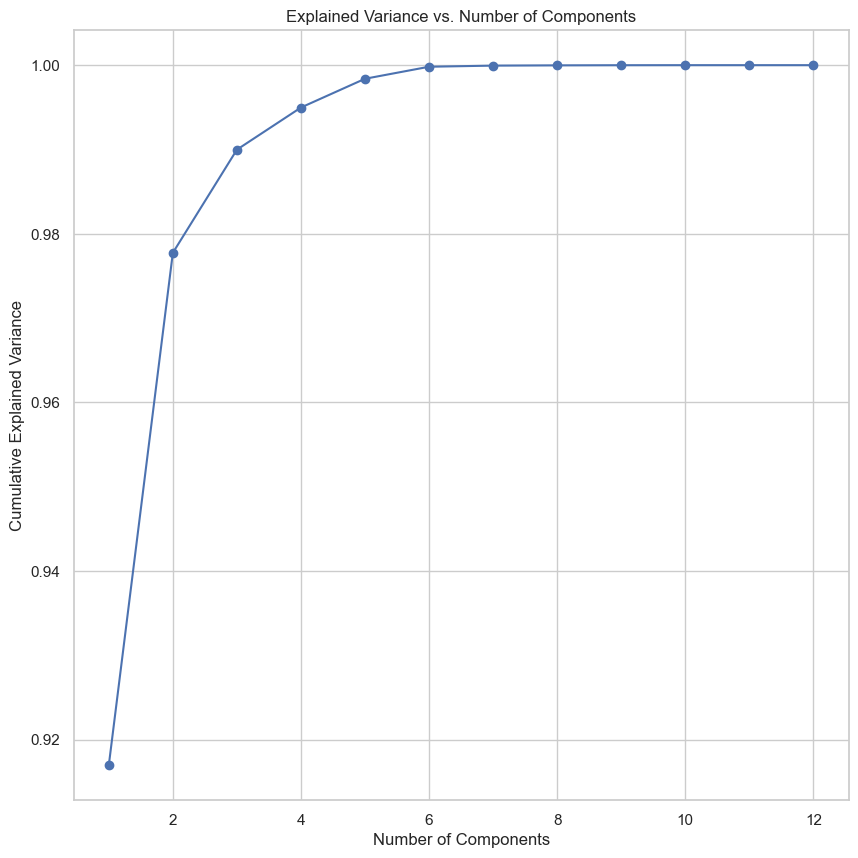

In [157]:
# Plot the cumulative explained variance against the number of components
plt.rcParams["figure.figsize"] = (10,10)
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.grid(True)
plt.show()

In [158]:
n_components = 6
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(scaled_df_pca)

In [159]:
features = df_pca.columns[:-1]

In [160]:
features = df.columns[:-1]

In [161]:
# Access the principal components
principal_components = pca.components_

# Access the explained variance of each principal component
explained_variances = pca.explained_variance_ratio_

# Print the explained variance of each principal component
for i, explained_variance in enumerate(explained_variances):
    print(f"Principal Component {i+1}: {explained_variance:.4f}")
    
# Print the loadings of the original features on each principal component
for i, pc in enumerate(principal_components):
    print(f"Principal Component {i+1} Loadings:")
    for feature, loading in zip(features, pc):
        print(f"{feature}: {loading:.4f}")

Principal Component 1: 0.9170
Principal Component 2: 0.0608
Principal Component 3: 0.0122
Principal Component 4: 0.0050
Principal Component 5: 0.0034
Principal Component 6: 0.0014
Principal Component 1 Loadings:
Open: 0.3725
High: 0.3742
Low: 0.3708
Pct_change: -0.0010
MACD: 0.0077
Signal Line: 0.0102
Volatility: 0.0320
Middle Band: 0.3842
Std Dev: 0.0995
Upper Band: 0.3813
Lower Band: 0.3748
Principal Component 2 Loadings:
Open: -0.0457
High: -0.0343
Low: -0.0576
Pct_change: -0.0040
MACD: -0.4662
Signal Line: -0.5254
Volatility: 0.4990
Middle Band: 0.0127
Std Dev: 0.4844
Upper Band: 0.0933
Lower Band: -0.0744
Principal Component 3 Loadings:
Open: 0.0155
High: 0.0174
Low: 0.0132
Pct_change: 0.0125
MACD: 0.5150
Signal Line: 0.4699
Volatility: 0.4513
Middle Band: -0.0843
Std Dev: 0.5193
Upper Band: 0.0071
Lower Band: -0.1799
Principal Component 4 Loadings:
Open: -0.0020
High: -0.0505
Low: -0.0751
Pct_change: -0.9450
MACD: -0.0920
Signal Line: 0.1260
Volatility: -0.1524
Middle Band: 0.066

In [162]:
X_pca_df = pd.DataFrame(X_pca)
X_pca_df

0         1         2         3         4         5
0    -0.999232 -0.031656  0.009893 -0.026973 -0.047367 -0.005822
1    -0.994404 -0.033743  0.009418  0.005975 -0.036051 -0.013036
2    -0.990193 -0.028858  0.021751 -0.053992 -0.045988 -0.002093
3    -0.985669 -0.032170  0.023302  0.011046 -0.027640 -0.014679
4    -0.983855 -0.034767  0.026005  0.000568 -0.030795 -0.012270
...        ...       ...       ...       ...       ...       ...
2742  0.963534  0.095811 -0.019510  0.079923 -0.002890  0.049493
2743  0.957649  0.112566 -0.027229 -0.010582 -0.029627  0.056229
2744  0.956044  0.128932 -0.036420  0.034740 -0.027787  0.038547
2745  0.957246  0.158657 -0.040704  0.070197 -0.028562  0.024725
2746  0.950642  0.141402 -0.064455 -0.060041 -0.068122  0.030857

[2747 rows x 6 columns]

From this, PCA transformation has been done, based on Elbow plot, it shows that 6 of PCA components can be sufficient amount 
# Making as a sequence data and split test and train

In [163]:
# Split x_pca into input sequences and target values
lookback = 10 #Using past 10 days'daily data of below columns'data to predict the 'Next_day' price
data_columns = [ 'Open', 'High', 'Low', 'Pct_change', 'MACD','Signal Line','Volatility' ,'Middle Band', 'Std Dev',
                'Upper Band', 'Lower Band']
target_columns = ['Next_day']

X_p = []
y_p = []
for i in range(len(X_pca) - lookback):
    X_p.append(X_pca[i:i+lookback])
    y_p.append(df_pca['Next_day'].values[i+lookback])

# Convert to numpy arrays
X_p = np.array(X_p)
y_p = np.array(y_p)

In [164]:
# Scale the input sequences (X)
scaler = MinMaxScaler()
X_p = scaler.fit_transform(X_p.reshape(X_p.shape[0], -1))

# Scale the target variable (y)
y_scaler = MinMaxScaler()
y_p = y_scaler.fit_transform(y_p.reshape(-1, 1))

In [165]:
# Create a TimeSeriesSplit object
tscv = TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=200)
for train_index, test_index in tscv.split(X_p, y_p):
    X_p_train, X_p_test = X_p[train_index], X_p[test_index]
    y_p_train, y_p_test = y_p[train_index], y_p[test_index]

In [166]:
X_p_train = X_p_train.reshape((X_p_train.shape[0], lookback, -1))
X_p_test = X_p_test.reshape((X_p_test.shape[0], lookback, -1))

In [167]:
print(X_p_train.shape, X_p_test.shape)
print(y_p_train.shape, y_p_test.shape)

(2537, 10, 6) (200, 10, 6)
(2537, 1) (200, 1)


From this result, it shows that Splitting the dataset has been finished to make the dataset to build the PCA-Stacked-LSTM model.

# Building PCA-Stacked LSTM

In [168]:
def build_stacked_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape=input_shape))  
    model.add(LSTM(64, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [169]:
input_shape = (X_p_train.shape[1], X_p_train.shape[2])  # Assuming X_p_train has the correct shape
stacked_lstm_model = build_stacked_lstm_model(input_shape)

from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min')
# Train the model
#
history_pb = stacked_lstm_model.fit(X_p_train, y_p_train, epochs=50, batch_size=32, 
                    validation_data=(X_p_test, y_p_test), callbacks=[early_stopping])


Train on 2537 samples, validate on 200 samples
Epoch 1/50
  32/2537 [..............................] - ETA: 17s - loss: 0.0820

2024-01-28 10:42:11.365072: W tensorflow/c/c_api.cc:304] Operation '{name:'dense_5/kernel/Assign' id:3688 op device:{requested: '', assigned: ''} def:{{{node dense_5/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_5/kernel, dense_5/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


2537/2537 [==============================] - 1s 306us/sample - loss: 0.0069 - val_loss: 0.0020
Epoch 2/50
 512/2537 [=====>........................] - ETA: 0s - loss: 4.1085e-04

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
2024-01-28 10:42:12.010931: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_2/mul' id:3716 op device:{requested: '', assigned: ''} def:{{{node loss_2/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_2/mul/x, loss_2/dense_5_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


2537/2537 [==============================] - 1s 240us/sample - loss: 3.6754e-04 - val_loss: 0.0024
Epoch 3/50
2537/2537 [==============================] - 1s 234us/sample - loss: 3.5237e-04 - val_loss: 0.0016
Epoch 4/50
2537/2537 [==============================] - 1s 260us/sample - loss: 3.1777e-04 - val_loss: 0.0014
Epoch 5/50
2537/2537 [==============================] - 1s 242us/sample - loss: 3.0386e-04 - val_loss: 0.0014
Epoch 6/50
2537/2537 [==============================] - 1s 237us/sample - loss: 2.9486e-04 - val_loss: 0.0014
Epoch 7/50
2537/2537 [==============================] - 1s 213us/sample - loss: 2.7123e-04 - val_loss: 0.0011
Epoch 8/50
2537/2537 [==============================] - 1s 226us/sample - loss: 2.3112e-04 - val_loss: 0.0019
Epoch 9/50
2537/2537 [==============================] - 1s 218us/sample - loss: 3.0250e-04 - val_loss: 0.0013
Epoch 10/50
2537/2537 [==============================] - 1s 222us/sample - loss: 3.0999e-04 - val_loss: 0.0011
Epoch 11/50
2537/253

In [170]:
stacked_lstm_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 10, 128)           69120     
                                                                 
 lstm_3 (LSTM)               (None, 64)                49408     
                                                                 
 dense_4 (Dense)             (None, 25)                1625      
                                                                 
 dense_5 (Dense)             (None, 1)                 26        
                                                                 
Total params: 120179 (469.45 KB)
Trainable params: 120179 (469.45 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [171]:
stacked_pred = stacked_lstm_model.predict(X_p_test)

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
2024-01-28 10:42:36.581936: W tensorflow/c/c_api.cc:304] Operation '{name:'dense_5/BiasAdd' id:3698 op device:{requested: '', assigned: ''} def:{{{node dense_5/BiasAdd}} = BiasAdd[T=DT_FLOAT, _has_manual_control_dependencies=true, data_format="NHWC"](dense_5/MatMul, dense_5/BiasAdd/ReadVariableOp)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


In [172]:
y_pca_pred_original = y_scaler.inverse_transform(stacked_pred)
y_pca_test_original = y_scaler.inverse_transform(y_p_test)

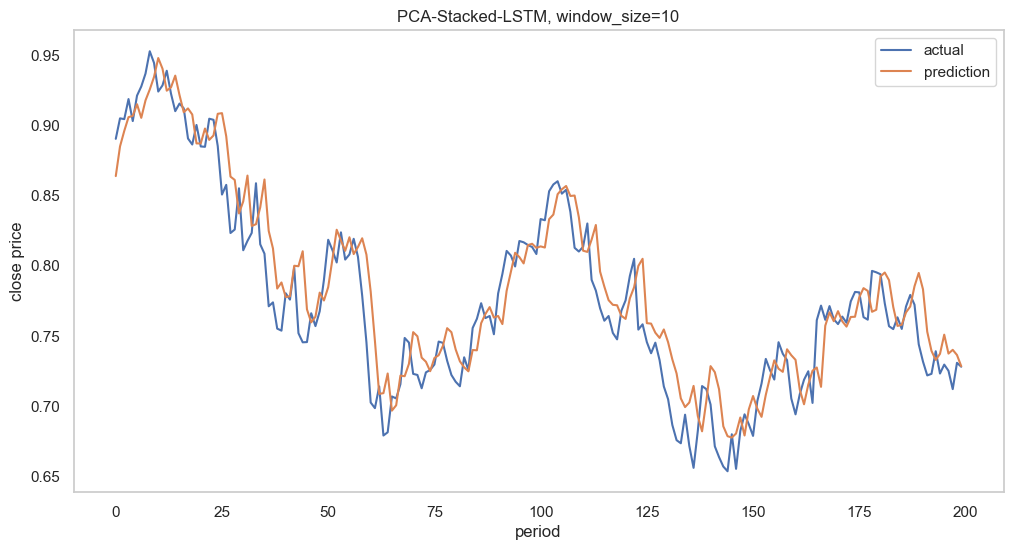

In [173]:
#stacked_pred = stacked_lstm_model.predict(X_p_test)
plt.figure(figsize=(12, 6))
plt.title('PCA-Stacked-LSTM, window_size=10')
plt.ylabel('close price')
plt.xlabel('period')
plt.plot(y_p_test, label='actual')
plt.plot(stacked_pred, label='prediction')
plt.grid()
plt.legend(loc='best')

plt.show()
#Graph with scaled X and y

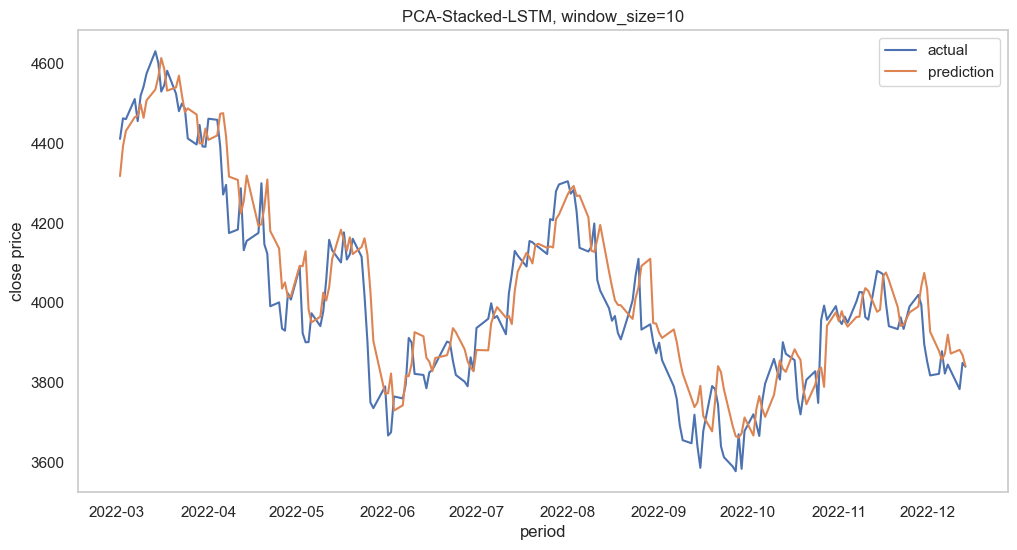

In [174]:
#Real values of prediction
plt.figure(figsize=(12, 6))
plt.title('PCA-Stacked-LSTM, window_size=10')
plt.ylabel('close price')
plt.xlabel('period')
plt.plot(date_values_bi,y_pca_test_original, label='actual')
plt.plot(date_values_bi,y_pca_pred_original, label='prediction')
plt.grid()
plt.legend(loc='best')

plt.show()

In [175]:
# Calculate error metrics
real_rmse_stacked = np.sqrt(mean_squared_error(y_pca_test_original, y_pca_pred_original))
real_mae_stacked = mean_absolute_error(y_pca_test_original, y_pca_pred_original)
real_mape_stacked = mean_absolute_percentage_error(y_pca_test_original, y_pca_pred_original)

# Print each value
print("RMSE of PCA-Stacked-LSTM :", real_rmse_stacked)
print("MAE of PCA-Stacked-LSTM :", real_mae_stacked)
print("MAPE of PCA-Stacked-LSTM :", real_mape_stacked)

RMSE of PCA-Stacked-LSTM : 88.95113761633498
MAE of PCA-Stacked-LSTM : 70.54792602539061
MAPE of PCA-Stacked-LSTM : 0.017824867522710022


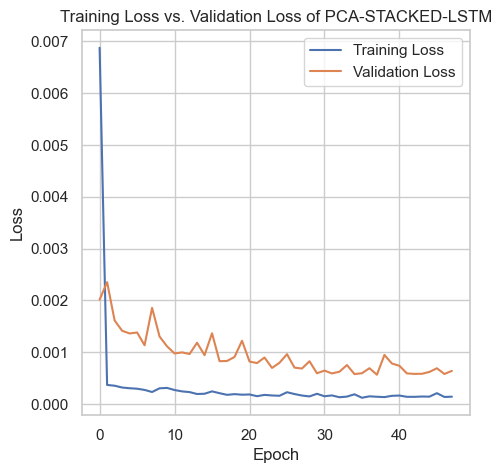

In [176]:
# Plot the training loss and validation loss over the epochs
plt.figure(figsize=(5, 5))
plt.plot(history_pb.history['loss'])
plt.plot(history_pb.history['val_loss'])
plt.title('Training Loss vs. Validation Loss of PCA-STACKED-LSTM')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.show()

# SHAP of PCA LSTM

In [177]:
# Use the training data for deep explainer => can use fewer instances
explainer_stock_pca = shap.DeepExplainer(stacked_lstm_model, X_p_train)
shap_values_stock_pca = explainer_stock_pca.shap_values(X_p_test)

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


In [178]:
# Use the training data for deep explainer => can use fewer instances
shap_values_stock_pca[0][0].shape

(10, 6)

In [179]:
shap_values_2D_pca = shap_values_stock_pca[0].reshape(-1,6)
X_p_test_2D = X_p_test.reshape(-1,6)

shap_values_2D_pca.shape, X_p_test_2D.shape

((2000, 6), (2000, 6))

In [180]:
features = ['Principal_Component_' + str(i) for i in range(1, X_p_test.shape[-1]+1)]
features

['Principal_Component_1',
 'Principal_Component_2',
 'Principal_Component_3',
 'Principal_Component_4',
 'Principal_Component_5',
 'Principal_Component_6']

In [181]:
X_p_test_2D = pd.DataFrame(data=X_p_test_2D, columns = features)

In [182]:
X_p_test_2D

Principal_Component_1  Principal_Component_2  Principal_Component_3  \
0                  0.897798               0.299937               0.084855   
1                  0.898818               0.288016               0.071270   
2                  0.884723               0.285156               0.063802   
3                  0.878037               0.306831               0.073719   
4                  0.872529               0.324483               0.072428   
...                     ...                    ...                    ...   
1995               0.756672               0.187791               0.327659   
1996               0.752812               0.203745               0.309933   
1997               0.750563               0.212699               0.297633   
1998               0.749950               0.221444               0.282990   
1999               0.750409               0.237327               0.276165   

      Principal_Component_4  Principal_Component_5  Principal_Component_6  
0                  0.313719               0.320271               0.332090  
1                  0.410752               0.394766               0.260044  
2                  0.430630               0.374485               0.295342  
3                  0.529722               0.407040               0.298116  
4                  0.436099               0.326234               0.359386  
...                     ...                    ...                    ...  
1995               0.349826               0.318430               0.594015  
1996               0.477042               0.363593               0.520089  
1997               0.387994               0.321704               0.540191  
1998               0.432586               0.324586               0.487426  
1999               0.467473               0.323372               0.446184  

[2000 rows x 6 columns]

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


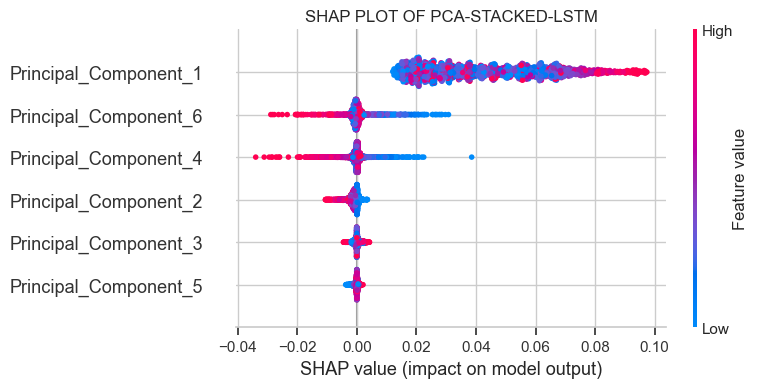

In [183]:
shap.summary_plot(shap_values_2D_pca, X_p_test_2D, show = False)
plt.title("SHAP PLOT OF PCA-STACKED-LSTM", loc='center')
plt.show()

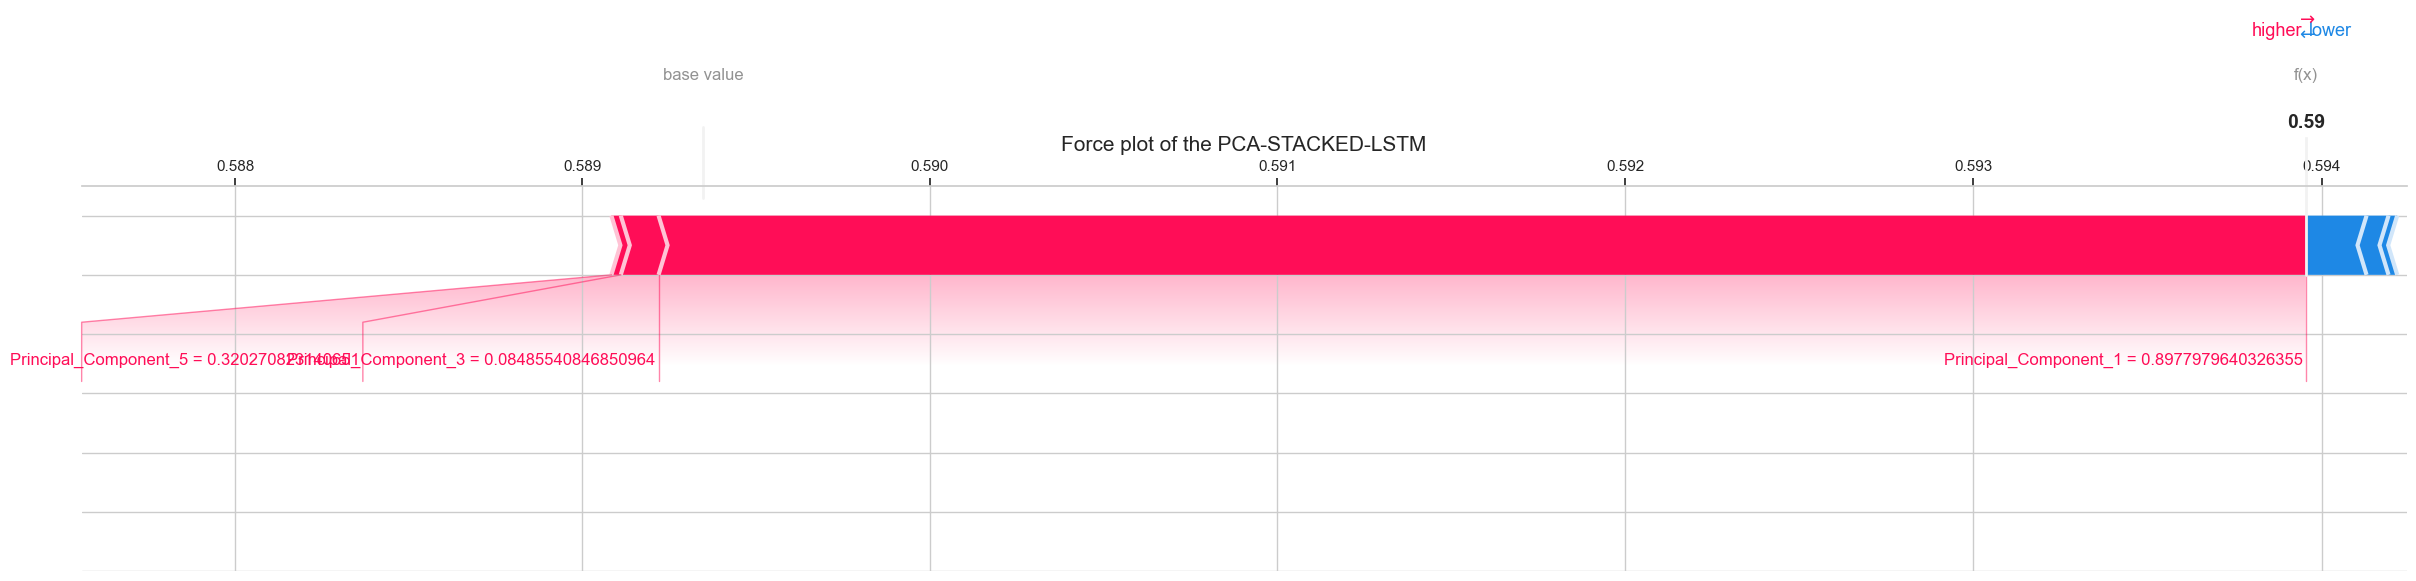

In [184]:
#Force_plot of the PCA-LSTM
expected_value_stock_pca = explainer_stock_pca.expected_value[0]

instance_index = 0  
shap.force_plot(expected_value_stock_pca, shap_values_2D_pca[instance_index], X_p_test_2D.iloc[instance_index],
                link='logit', matplotlib=True,show = False,figsize=(30,5))

plt.title("Force plot of the PCA-STACKED-LSTM",fontsize=15)
plt.show()


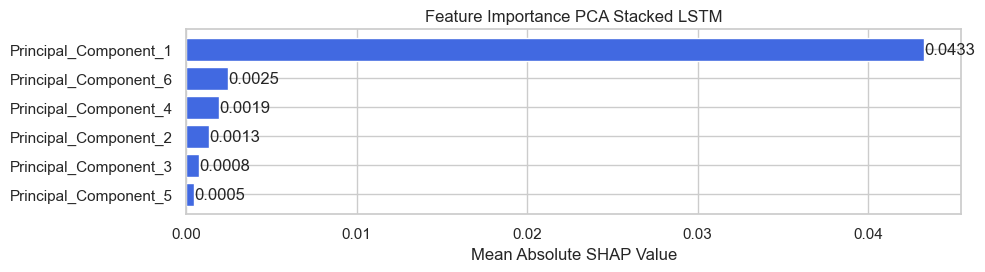

In [185]:
# Compute the mean absolute SHAP values for each feature
mean_shap_values_pc = np.abs(shap_values_2D_pca).mean(axis=0)

# Sorting the features based on their mean absolute SHAP values
sorted_indices_pc = np.argsort(mean_shap_values_pc)[::-1]
sorted_features_pc = X_p_test_2D.columns[sorted_indices_pc]
sorted_shap_values_pc = mean_shap_values_pc[sorted_indices_pc]

# Create the bar plot
plt.figure(figsize=(10, len(sorted_features_pc) * 0.4))
plt.barh(sorted_features_pc, sorted_shap_values_pc, color='royalblue')
plt.xlabel('Mean Absolute SHAP Value')
plt.title('Feature Importance PCA Stacked LSTM')

# Annotate each bar with its exact value
for index, value in enumerate(sorted_shap_values_pc):
    plt.text(value, index, f'{value:.4f}', va='center')

plt.gca().invert_yaxis()  # To display the most important feature at the top
plt.show()

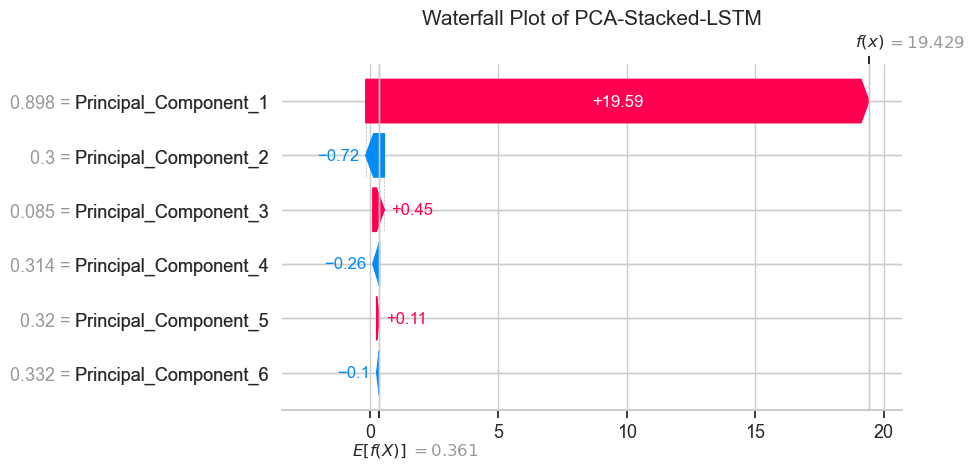

In [205]:
# Instance index you want to explain
instance_index_pca = 0

# Extract SHAP values and features for the selected instance
shap_values_instance_pca = shap_values_2D_pca[instance_index_pca]
features_instance_pca = X_p_test_2D.iloc[instance_index_pca]

# Scale or round the SHAP values
shap_values_instance_pca_scaled = shap_values_instance_pca * 1000
shap_values_instance_pca_rounded = np.round(shap_values_instance_pca, 4)

# Create an Explanation object
expected_value_pca = explainer_stock_pca.expected_value[0]
explanation_pca = shap.Explanation(values=shap_values_instance_pca_scaled, 
                                      base_values=expected_value_pca, data=features_instance_pca)

# Use the shap.waterfall_plot function with the Explanation object
shap.waterfall_plot(explanation_pca, show=False)

# Add the title
plt.title("Waterfall Plot of PCA-Stacked-LSTM", fontsize=15)

# Show the plot
plt.show()


# Regular Stacked LSTM Model

In [188]:
def build_stacked_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape=input_shape))  
    model.add(LSTM(64, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [189]:
input_shape = (X_train.shape[1], X_train.shape[2])  # Assuming X_p_train has the correct shape
normal_stacked_lstm_model = build_stacked_lstm_model(input_shape)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min')
# Train the model
history_RS = normal_stacked_lstm_model.fit(X_train, y_train, epochs=50, batch_size=32, 
                    validation_data=(X_test, y_test), callbacks=[early_stopping])
#RS=Regular Stacked

Train on 2537 samples, validate on 200 samples
Epoch 1/50
  32/2537 [..............................] - ETA: 19s - loss: 0.1700

2024-01-28 11:07:00.526555: W tensorflow/c/c_api.cc:304] Operation '{name:'training_6/Adam/lstm_5/lstm_cell/recurrent_kernel/v/Assign' id:6571 op device:{requested: '', assigned: ''} def:{{{node training_6/Adam/lstm_5/lstm_cell/recurrent_kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_6/Adam/lstm_5/lstm_cell/recurrent_kernel/v, training_6/Adam/lstm_5/lstm_cell/recurrent_kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


2537/2537 [==============================] - 1s 327us/sample - loss: 0.0055 - val_loss: 0.0019
Epoch 2/50
 320/2537 [==>...........................] - ETA: 0s - loss: 4.2997e-04

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
2024-01-28 11:07:01.200145: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_3/mul' id:5845 op device:{requested: '', assigned: ''} def:{{{node loss_3/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_3/mul/x, loss_3/dense_7_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


2537/2537 [==============================] - 1s 207us/sample - loss: 3.6232e-04 - val_loss: 0.0017
Epoch 3/50
2537/2537 [==============================] - 1s 217us/sample - loss: 3.4518e-04 - val_loss: 0.0017
Epoch 4/50
2537/2537 [==============================] - 1s 200us/sample - loss: 3.0336e-04 - val_loss: 0.0014
Epoch 5/50
2537/2537 [==============================] - 1s 204us/sample - loss: 3.5193e-04 - val_loss: 0.0016
Epoch 6/50
2537/2537 [==============================] - 1s 204us/sample - loss: 2.8915e-04 - val_loss: 0.0014
Epoch 7/50
2537/2537 [==============================] - 1s 206us/sample - loss: 2.7585e-04 - val_loss: 0.0013
Epoch 8/50
2537/2537 [==============================] - 1s 198us/sample - loss: 2.8363e-04 - val_loss: 0.0021
Epoch 9/50
2537/2537 [==============================] - 1s 198us/sample - loss: 2.8406e-04 - val_loss: 0.0012
Epoch 10/50
2537/2537 [==============================] - 1s 212us/sample - loss: 2.4284e-04 - val_loss: 0.0012
Epoch 11/50
2537/253

In [190]:
normal_stacked_lstm_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 10, 128)           71680     
                                                                 
 lstm_5 (LSTM)               (None, 64)                49408     
                                                                 
 dense_6 (Dense)             (None, 25)                1625      
                                                                 
 dense_7 (Dense)             (None, 1)                 26        
                                                                 
Total params: 122739 (479.45 KB)
Trainable params: 122739 (479.45 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [191]:
normal_stacked_pred = normal_stacked_lstm_model.predict(X_test)

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
2024-01-28 11:07:26.829324: W tensorflow/c/c_api.cc:304] Operation '{name:'dense_7/BiasAdd' id:5827 op device:{requested: '', assigned: ''} def:{{{node dense_7/BiasAdd}} = BiasAdd[T=DT_FLOAT, _has_manual_control_dependencies=true, data_format="NHWC"](dense_7/MatMul, dense_7/BiasAdd/ReadVariableOp)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


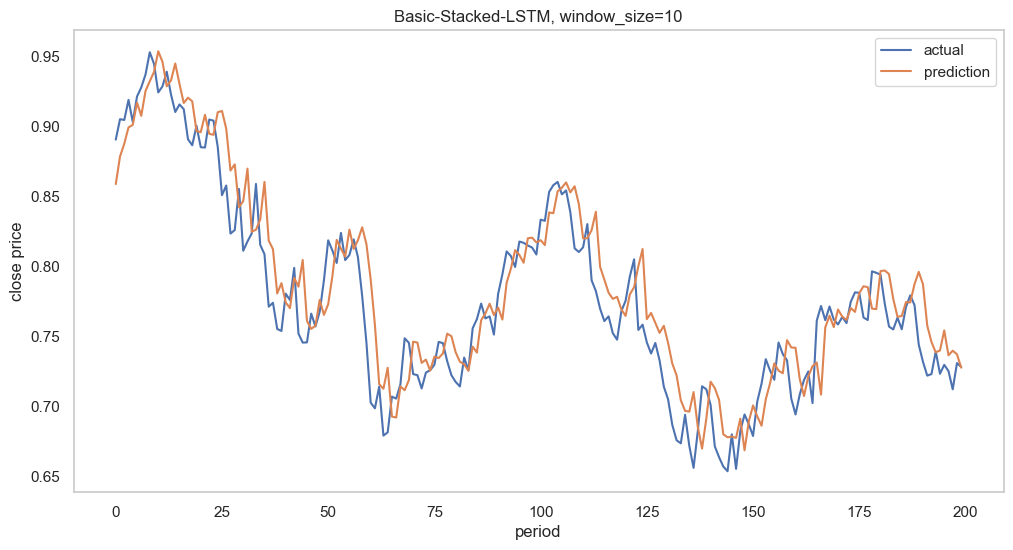

In [192]:
#stacked_pred = stacked_lstm_model.predict(X_p_test)
plt.figure(figsize=(12, 6))
plt.title('Basic-Stacked-LSTM, window_size=10')
plt.ylabel('close price')
plt.xlabel('period')
plt.plot(y_test, label='actual')
plt.plot(normal_stacked_pred, label='prediction')
plt.grid()
plt.legend(loc='best')

plt.show()

In [193]:
y_nstacked_pred_original = y_scaler.inverse_transform(normal_stacked_pred)
y_nstacked_test_original = y_scaler.inverse_transform(y_test)

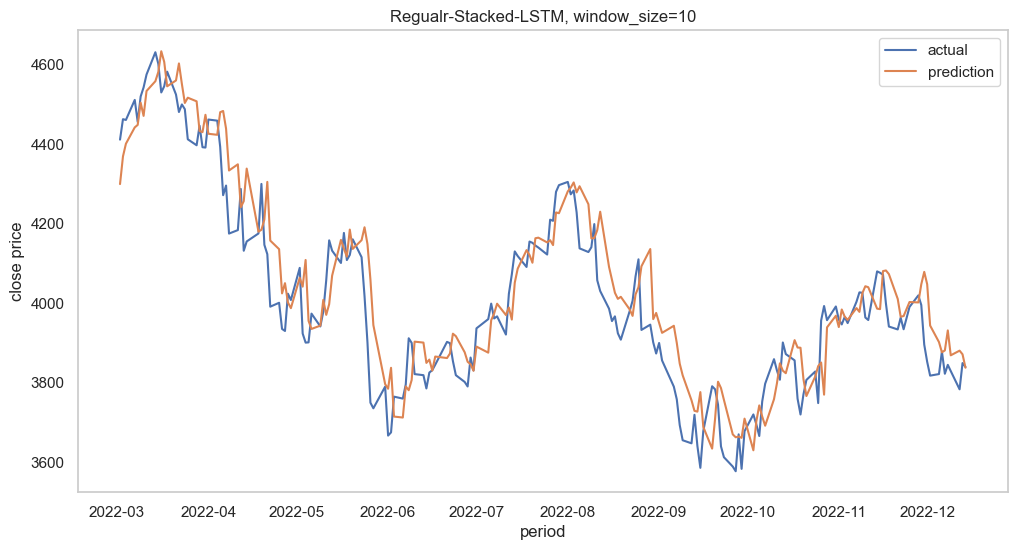

In [194]:
#Real values of prediction
plt.figure(figsize=(12, 6))
plt.title('Regualr-Stacked-LSTM, window_size=10')
plt.ylabel('close price')
plt.xlabel('period')
plt.plot(date_values_bi,y_nstacked_test_original, label='actual')
plt.plot(date_values_bi,y_nstacked_pred_original, label='prediction')
plt.grid()
plt.legend(loc='best')

plt.show()

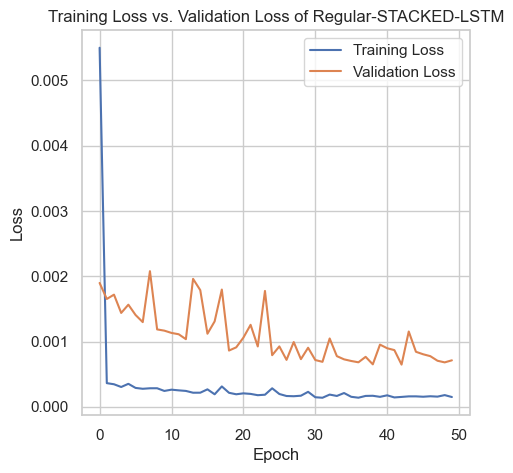

In [195]:
# Plot the training loss and validation loss over the epochs
plt.figure(figsize=(5, 5))
plt.plot(history_RS.history['loss'])
plt.plot(history_RS.history['val_loss'])
plt.title('Training Loss vs. Validation Loss of Regular-STACKED-LSTM')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.show()

In [196]:
# Calculate error metrics
real_rmse_rstacked = np.sqrt(mean_squared_error(y_nstacked_test_original, y_nstacked_pred_original))
real_mae_rstacked = mean_absolute_error(y_nstacked_test_original, y_nstacked_pred_original)
real_mape_rstacked = mean_absolute_percentage_error(y_nstacked_test_original, y_nstacked_pred_original)

# Print each value
print("RMSE of Regular-Stacked-LSTM :", real_rmse_rstacked)
print("MAE of Regular-Stacked-LSTM :", real_mae_rstacked)
print("MAPE of Regular-Stacked-LSTM :", real_mape_rstacked)

RMSE of Regular-Stacked-LSTM : 93.88194353247167
MAE of Regular-Stacked-LSTM : 74.33520385742186
MAPE of Regular-Stacked-LSTM : 0.01874240356739934


# SHAP of Regular Stacked LSTM

In [197]:
# Use the training data for deep explainer
explainer_stock_RS = shap.DeepExplainer(normal_stacked_lstm_model, X_train)
shap_values_stock_RS = explainer_stock_RS.shap_values(X_test)

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


In [198]:
shap_values_stock_RS[0][0].shape

(10, 11)

In [199]:
shap_values_RS_2D = shap_values_stock_RS[0].reshape(-1,11)
X_test_RS_2D = X_test.reshape(-1,11)

shap_values_RS_2D.shape, X_test_RS_2D.shape

((2000, 11), (2000, 11))

In [200]:
X_test_RS_2D = pd.DataFrame(data=X_test_RS_2D, columns = actual_column_names)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


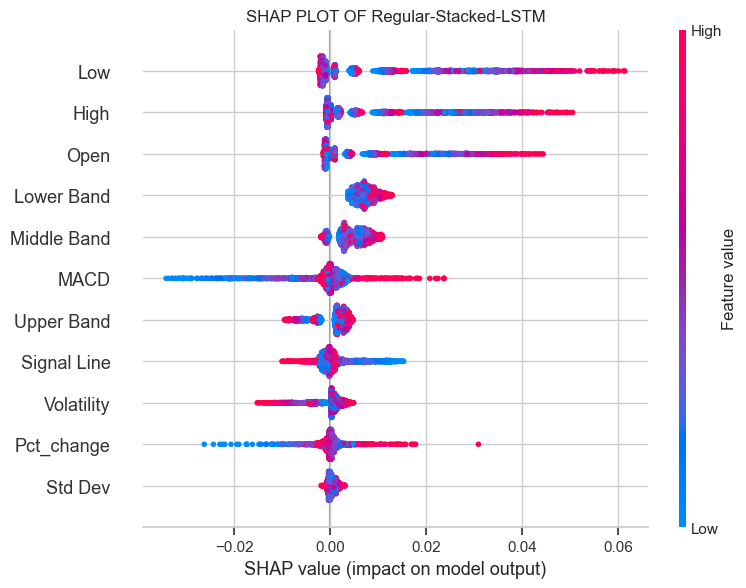

In [201]:
shap.summary_plot(shap_values_RS_2D, X_test_RS_2D, show = False)
plt.title("SHAP PLOT OF Regular-Stacked-LSTM", loc='center')
plt.show()

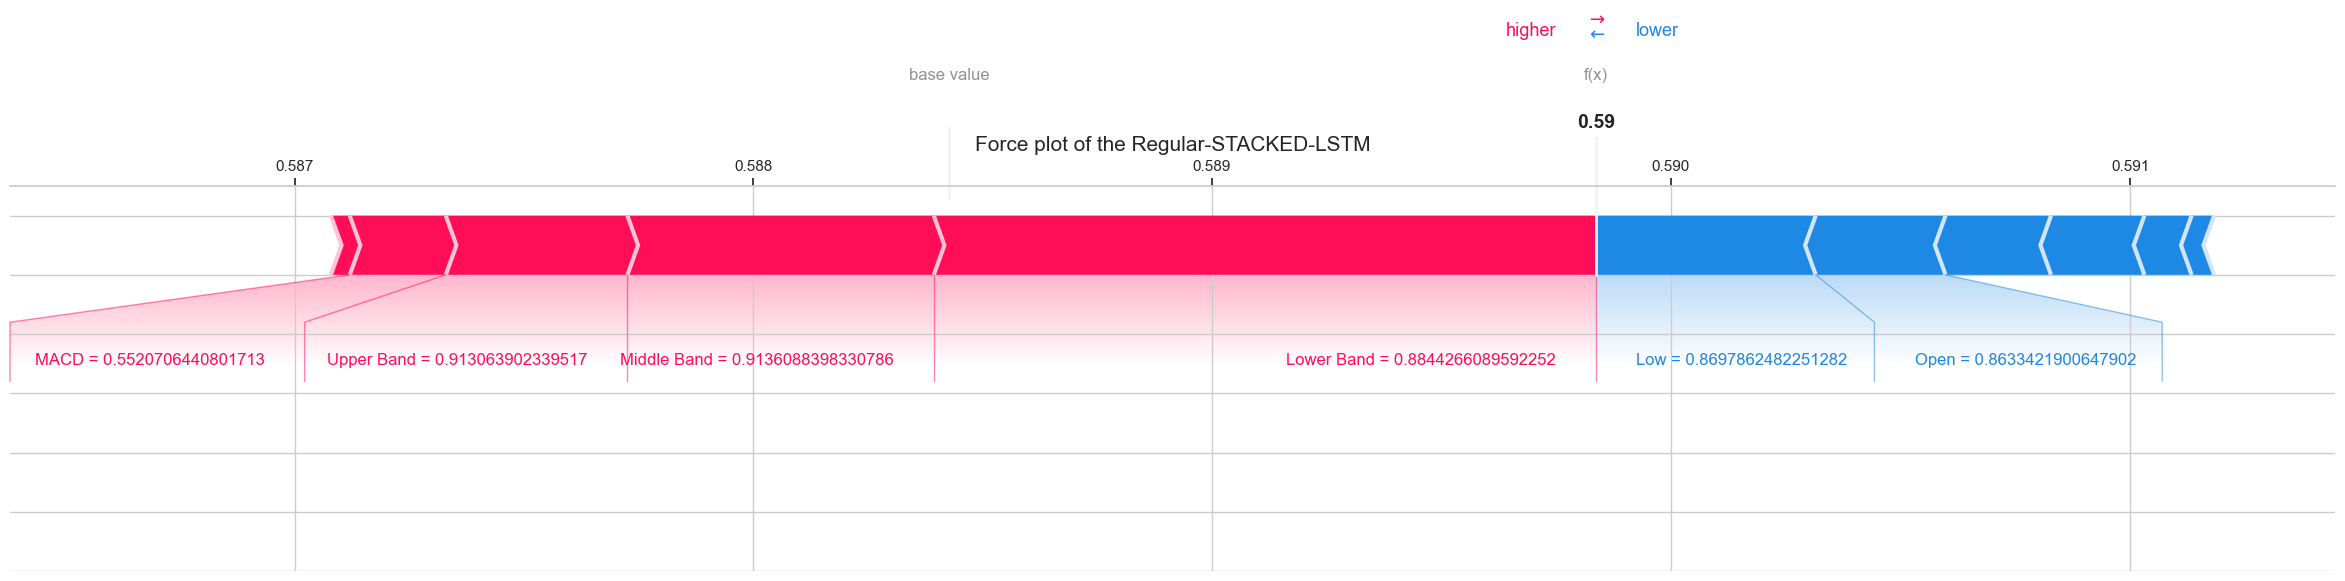

In [202]:
#Force_plot of the PCA-LSTM
expected_value_stock_RS = explainer_stock_RS.expected_value[0]

instance_index = 0  
shap.force_plot(expected_value_stock_RS, shap_values_RS_2D[instance_index], X_test_RS_2D.iloc[instance_index],
                link='logit', matplotlib=True,show = False,figsize=(30,5))

plt.title("Force plot of the Regular-STACKED-LSTM",fontsize=15)
plt.show()

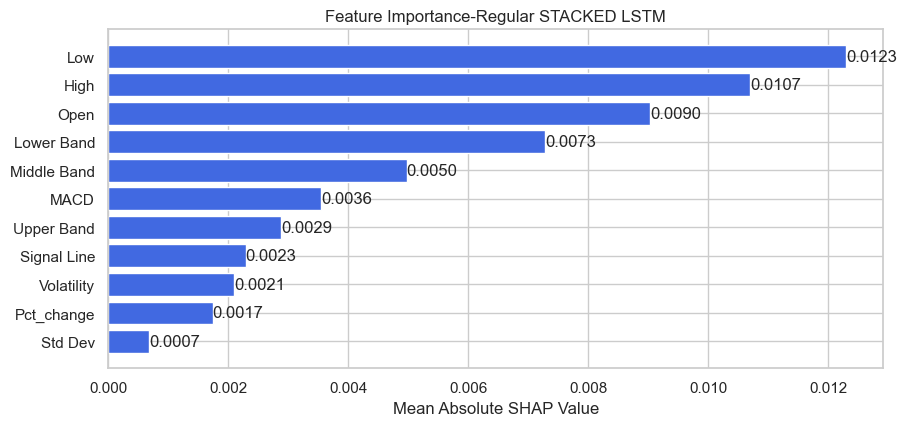

In [203]:
# Compute the mean absolute SHAP values for each feature
mean_shap_values_rs = np.abs(shap_values_RS_2D).mean(axis=0)

# Sort the features based on their mean absolute SHAP values
sorted_indices_rs = np.argsort(mean_shap_values_rs)[::-1]
sorted_features_rs = X_test_RS_2D.columns[sorted_indices_rs]
sorted_shap_values_rs = mean_shap_values_rs[sorted_indices_rs]

# Create the bar plot
plt.figure(figsize=(10, len(sorted_features_rs) * 0.4))
plt.barh(sorted_features_rs, sorted_shap_values_rs, color='royalblue')
plt.xlabel('Mean Absolute SHAP Value')
plt.title('Feature Importance-Regular STACKED LSTM')

# Annotate each bar with its exact value
for index, value in enumerate(sorted_shap_values_rs):
    plt.text(value, index, f'{value:.4f}', va='center')

plt.gca().invert_yaxis()  # To display the most important feature at the top
plt.show()

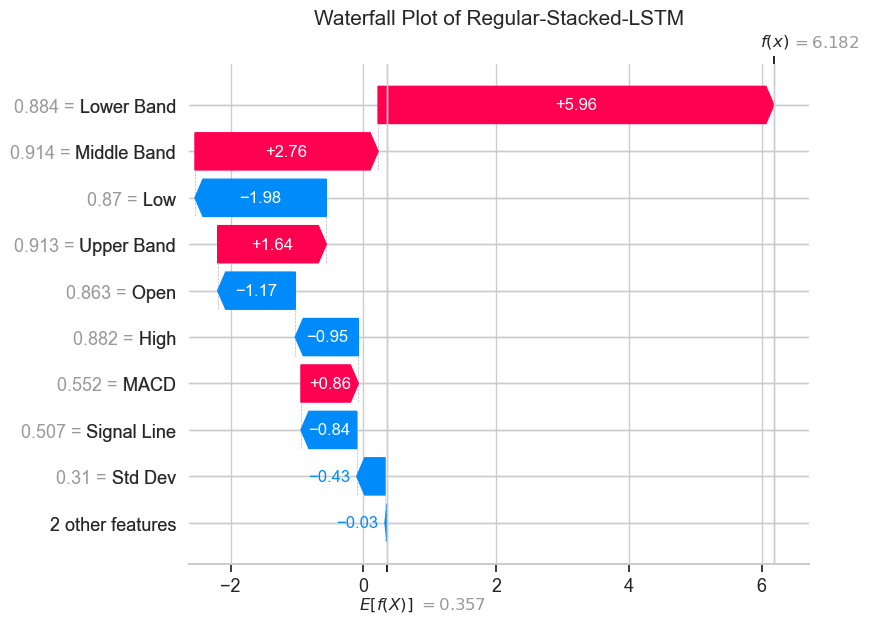

In [206]:
# Instance index you want to explain
instance_index_RS = 0

# Extract SHAP values and features for the selected instance
shap_values_instance_RS = shap_values_RS_2D[instance_index_RS]
features_instance_RS = X_test_RS_2D.iloc[instance_index_RS]

# Scale or round the SHAP values
shap_values_instance_RS_scaled = shap_values_instance_RS * 1000
shap_values_instance_RS_rounded = np.round(shap_values_instance_RS, 4)

# Create an Explanation object
expected_value_RS = explainer_stock_RS.expected_value[0]
explanation_RS = shap.Explanation(values=shap_values_instance_RS_scaled, 
                                      base_values=expected_value_RS, data=features_instance_RS)

# Use the shap.waterfall_plot function with the Explanation object
shap.waterfall_plot(explanation_RS, show=False)

# Add the title
plt.title("Waterfall Plot of Regular-Stacked-LSTM", fontsize=15)

# Show the plot
plt.show()


# Normal GRU Model

In [207]:
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers.schedules import ExponentialDecay

lr_schedule = ExponentialDecay(
    initial_learning_rate=0.1,
    decay_steps=10000,
    decay_rate=0.96,
    staircase=True)


# Importing libraries
from keras.models import Sequential
from keras.layers import Dense, GRU
from keras.optimizers import Adam
from keras.layers import Dropout

# The GRU architecture
GRU_model = Sequential()

# First GRU layer with Dropout regularisation
GRU_model.add(GRU(units=64, return_sequences=True, input_shape=(X_train.shape[1], 11), activation='tanh'))
GRU_model.add(Dropout(0.3))

# Second GRU layer
GRU_model.add(GRU(units=64, return_sequences=True, activation='tanh'))
GRU_model.add(Dropout(0.3))

# Third GRU layer
GRU_model.add(GRU(units=64, return_sequences=True, activation='tanh'))
GRU_model.add(Dropout(0.3))

# Fourth GRU layer
GRU_model.add(GRU(units=64, activation='tanh'))
GRU_model.add(Dropout(0.3))

# The output layer
GRU_model.add(Dense(units=1))

# Compiling the RNN
#GRU_model.compile(optimizer=SGD(learning_rate=0.001, decay=1e-7, momentum=0.9, nesterov=False), loss='mean_squared_error')
GRU_model.compile(optimizer=SGD(learning_rate=lr_schedule, momentum=0.9, nesterov=False), loss='mean_squared_error')

from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min')

# Fitting to the training set
gru_history = GRU_model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1,
                    validation_data=(X_test, y_test), callbacks=[early_stopping])

Train on 2537 samples, validate on 200 samples
Epoch 1/50


2024-01-28 11:15:53.666490: W tensorflow/c/c_api.cc:304] Operation '{name:'training_8/SGD/gru_3/gru_cell/bias/momentum/Assign' id:9937 op device:{requested: '', assigned: ''} def:{{{node training_8/SGD/gru_3/gru_cell/bias/momentum/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_8/SGD/gru_3/gru_cell/bias/momentum, training_8/SGD/gru_3/gru_cell/bias/momentum/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


2537/2537 [==============================] - 1s 455us/sample - loss: 0.0162 - val_loss: 0.0037
Epoch 2/50
 256/2537 [==>...........................] - ETA: 0s - loss: 0.0044

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
2024-01-28 11:15:54.593412: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_4/mul' id:8357 op device:{requested: '', assigned: ''} def:{{{node loss_4/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_4/mul/x, loss_4/dense_8_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


2537/2537 [==============================] - 1s 234us/sample - loss: 0.0029 - val_loss: 0.0023
Epoch 3/50
2537/2537 [==============================] - 1s 234us/sample - loss: 0.0020 - val_loss: 0.0022
Epoch 4/50
2537/2537 [==============================] - 1s 274us/sample - loss: 0.0018 - val_loss: 0.0033
Epoch 5/50
2537/2537 [==============================] - 1s 237us/sample - loss: 0.0020 - val_loss: 0.0018
Epoch 6/50
2537/2537 [==============================] - 1s 238us/sample - loss: 0.0018 - val_loss: 0.0019
Epoch 7/50
2537/2537 [==============================] - 1s 232us/sample - loss: 0.0017 - val_loss: 0.0043
Epoch 8/50
2537/2537 [==============================] - 1s 233us/sample - loss: 0.0017 - val_loss: 0.0016
Epoch 9/50
2537/2537 [==============================] - 1s 231us/sample - loss: 0.0015 - val_loss: 0.0015
Epoch 10/50
2537/2537 [==============================] - 1s 225us/sample - loss: 0.0016 - val_loss: 0.0027
Epoch 11/50
2537/2537 [==============================] -

In [208]:
GRU_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 10, 64)            14784     
                                                                 
 dropout (Dropout)           (None, 10, 64)            0         
                                                                 
 gru_1 (GRU)                 (None, 10, 64)            24960     
                                                                 
 dropout_1 (Dropout)         (None, 10, 64)            0         
                                                                 
 gru_2 (GRU)                 (None, 10, 64)            24960     
                                                                 
 dropout_2 (Dropout)         (None, 10, 64)            0         
                                                                 
 gru_3 (GRU)                 (None, 64)               

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
2024-01-28 11:16:09.670883: W tensorflow/c/c_api.cc:304] Operation '{name:'dense_8/BiasAdd' id:8320 op device:{requested: '', assigned: ''} def:{{{node dense_8/BiasAdd}} = BiasAdd[T=DT_FLOAT, _has_manual_control_dependencies=true, data_format="NHWC"](dense_8/MatMul, dense_8/BiasAdd/ReadVariableOp)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


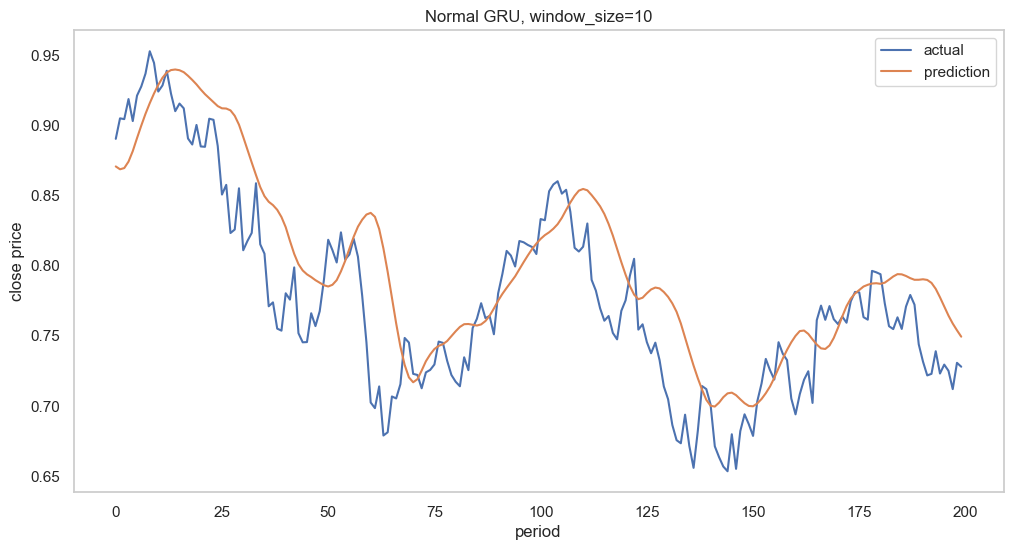

In [209]:
gru_pred = GRU_model.predict(X_test)
plt.figure(figsize=(12, 6))
plt.title('Normal GRU, window_size=10')
plt.ylabel('close price')
plt.xlabel('period')
plt.plot(y_test, label='actual')
plt.plot(gru_pred, label='prediction')
plt.grid()
plt.legend(loc='best')

plt.show()


In [210]:
y_pred_gru_original = y_scaler.inverse_transform(gru_pred)
y_test_gru_original = y_scaler.inverse_transform(y_test)

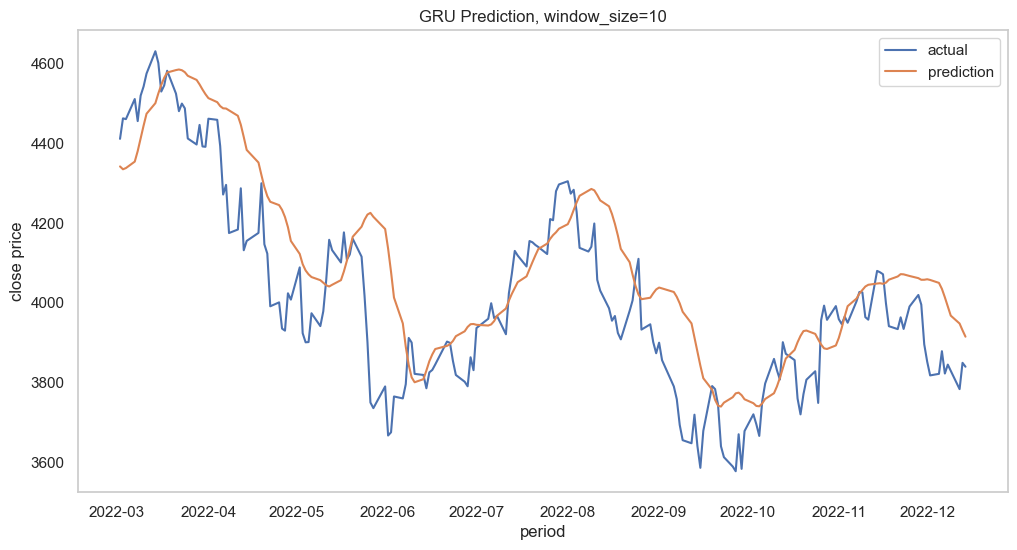

In [211]:
plt.figure(figsize=(12, 6))
plt.title('GRU Prediction, window_size=10')
plt.ylabel('close price')
plt.xlabel('period')
plt.plot(date_values_bi,y_test_gru_original, label='actual')
plt.plot(date_values_bi,y_pred_gru_original, label='prediction')
plt.grid()
plt.legend(loc='best')

plt.show()

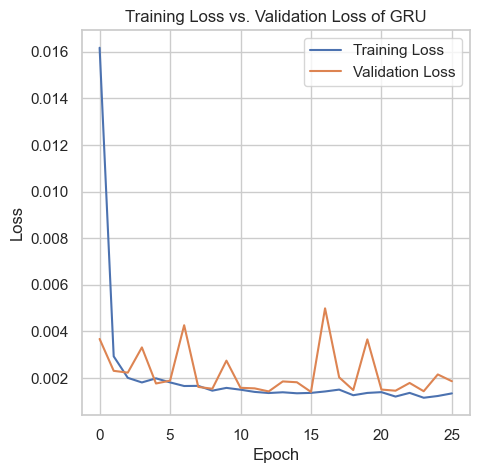

In [212]:
# Plot the training loss and validation loss over the epochs
plt.figure(figsize=(5, 5))
plt.plot(gru_history.history['loss'])
plt.plot(gru_history.history['val_loss'])
plt.title('Training Loss vs. Validation Loss of GRU')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.show()

In [213]:
# Calculate metrics with the real number value
real_rmse_gru = np.sqrt(mean_squared_error(y_test_gru_original, y_pred_gru_original))
real_mae_gru = mean_absolute_error(y_test_gru_original, y_pred_gru_original)
real_mape_gru = mean_absolute_percentage_error(y_test_gru_original, y_pred_gru_original)
#Print each value
print("RMSE of GRU:", real_rmse_gru)
print("MAE of GRU:",real_mae_gru)
print("MAPE of GRU:", real_mape_gru)

RMSE of GRU: 151.81894976792898
MAE of GRU: 117.80548828124998
MAPE of GRU: 0.02987730846064958


# SHAP GRU 

In [214]:
# Use the training data for deep explainer
explainer_stock_gru = shap.DeepExplainer(GRU_model, X_train)
shap_values_stock_gru = explainer_stock_gru.shap_values(X_test)

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


In [215]:
shap_values_stock_gru[0][0].shape

(10, 11)

In [216]:
shap_values_stock_gru_2D = shap_values_stock_gru[0].reshape(-1,11)
X_test_gru_2D = X_test.reshape(-1,11)

shap_values_stock_gru_2D.shape, X_test_gru_2D.shape

((2000, 11), (2000, 11))

In [217]:
X_test_gru_2D = pd.DataFrame(data=X_test_gru_2D, columns = actual_column_names)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


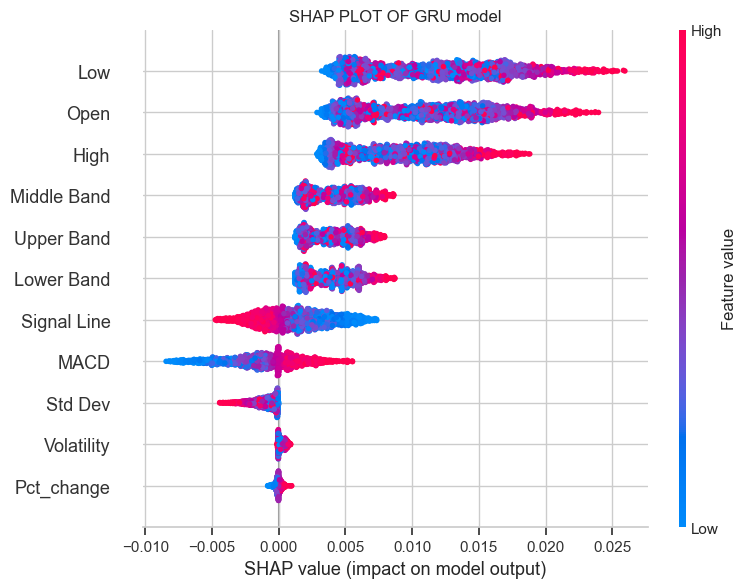

In [218]:
shap.summary_plot(shap_values_stock_gru_2D, X_test_gru_2D, show = False)
plt.title("SHAP PLOT OF GRU model", loc='center')
plt.show()

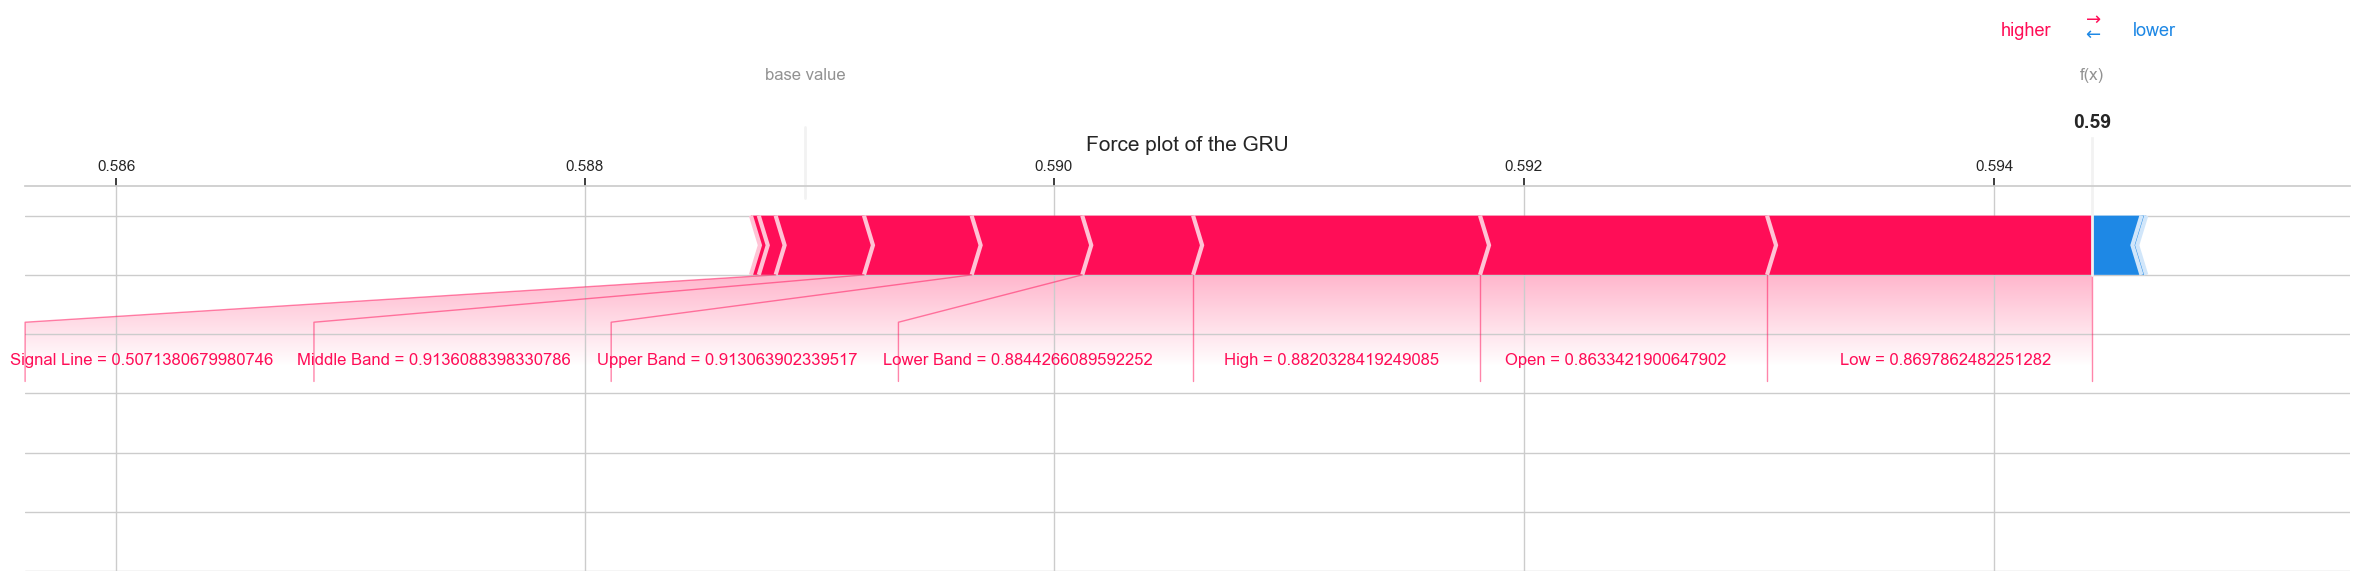

In [219]:
#Force_plot of the GRU
expected_value_stock_GRU = explainer_stock_gru.expected_value[0]

instance_index = 0  
shap.force_plot(expected_value_stock_GRU, shap_values_stock_gru_2D[instance_index], X_test_gru_2D.iloc[instance_index],
                link='logit', matplotlib=True,show = False,figsize=(30,5))

plt.title("Force plot of the GRU",fontsize=15)
plt.show()

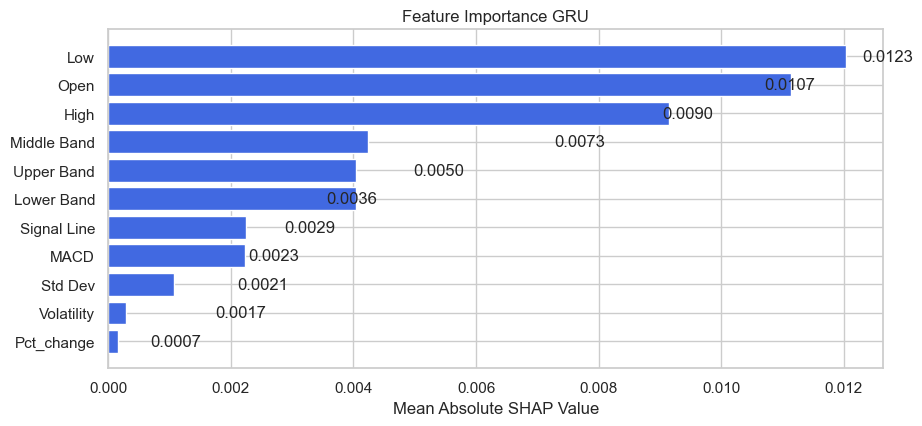

In [220]:
# Compute the mean absolute SHAP values for each feature
mean_shap_values_gru = np.abs(shap_values_stock_gru_2D).mean(axis=0)

# Sort the features based on their mean absolute SHAP values
sorted_indices_gru = np.argsort(mean_shap_values_gru)[::-1]
sorted_features_gru = X_test_gru_2D.columns[sorted_indices_gru]
sorted_shap_values_gru = mean_shap_values_gru[sorted_indices_gru]

# Create the bar plot
plt.figure(figsize=(10, len(sorted_features_gru) * 0.4))
plt.barh(sorted_features_gru, sorted_shap_values_gru, color='royalblue')
plt.xlabel('Mean Absolute SHAP Value')
plt.title('Feature Importance GRU')

# Annotate each bar with its exact value
for index, value in enumerate(sorted_shap_values_rs):
    plt.text(value, index, f'{value:.4f}', va='center')

plt.gca().invert_yaxis()  # To display the most important feature at the top
plt.show()

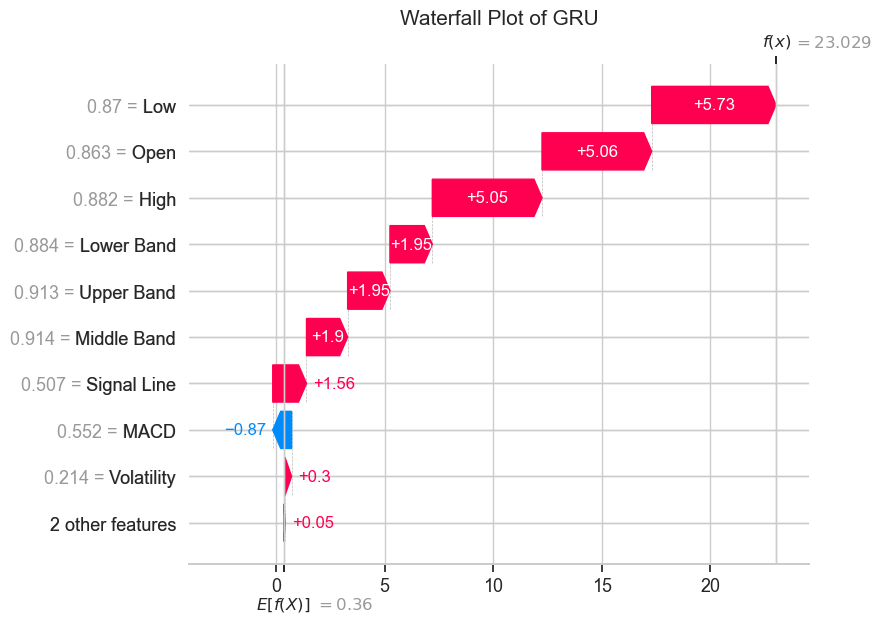

In [272]:
# Instance index you want to explain
instance_index_gru = 0

# Extract SHAP values and features for the selected instance
shap_values_instance_gru = shap_values_stock_gru_2D[instance_index_gru]
features_instance_gru = X_test_gru_2D.iloc[instance_index_gru]

# Scale or round the SHAP values
shap_values_instance_gru_scaled = shap_values_instance_gru * 1000
shap_values_instance_gru_rounded = np.round(shap_values_instance_gru, 4)

# Create an Explanation object
expected_value_gru = explainer_stock_gru.expected_value[0]
explanation_gru = shap.Explanation(values=shap_values_instance_gru_scaled, 
                                      base_values=expected_value_gru, data=features_instance_gru)

# Use the shap.waterfall_plot function with the Explanation object
shap.waterfall_plot(explanation_gru, show=False)

# Add the title
plt.title("Waterfall Plot of GRU", fontsize=15)

# Show the plot
plt.show()


# Machine Learning model, Voting Regressor with TPOT

In [222]:
import pandas as pd
from sklearn.metrics import precision_score,accuracy_score
import matplotlib.pyplot as plt
import pandas_datareader as web
import datetime as dt
from sklearn.preprocessing import MinMaxScaler,StandardScaler
import yfinance as yf
import numpy as np
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingRegressor,VotingRegressor,RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ExpSineSquared, Sum,Product,Matern
from xgboost import XGBRegressor
import shap
from sklearn.model_selection import TimeSeriesSplit
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [223]:
dfm = yf.download('^GSPC', start='2012-01-01', end='2022-12-31')
dfm

[*********************100%***********************]  1 of 1 completed


Open         High          Low        Close    Adj Close  \
Date                                                                          
2012-01-03  1258.859985  1284.619995  1258.859985  1277.060059  1277.060059   
2012-01-04  1277.030029  1278.729980  1268.099976  1277.300049  1277.300049   
2012-01-05  1277.300049  1283.050049  1265.260010  1281.060059  1281.060059   
2012-01-06  1280.930054  1281.839966  1273.339966  1277.810059  1277.810059   
2012-01-09  1277.829956  1281.989990  1274.550049  1280.699951  1280.699951   
...                 ...          ...          ...          ...          ...   
2022-12-23  3815.110107  3845.800049  3797.010010  3844.820068  3844.820068   
2022-12-27  3843.340088  3846.649902  3813.219971  3829.250000  3829.250000   
2022-12-28  3829.560059  3848.320068  3780.780029  3783.219971  3783.219971   
2022-12-29  3805.449951  3858.189941  3805.449951  3849.280029  3849.280029   
2022-12-30  3829.060059  3839.850098  3800.340088  3839.500000  3839.500000   

                Volume  
Date                    
2012-01-03  3943710000  
2012-01-04  3592580000  
2012-01-05  4315950000  
2012-01-06  3656830000  
2012-01-09  3371600000  
...                ...  
2022-12-23  2819280000  
2022-12-27  3030300000  
2022-12-28  3083520000  
2022-12-29  3003680000  
2022-12-30  2979870000  

[2768 rows x 6 columns]

In [224]:
dfm_reset = dfm.reset_index()

In [225]:
# Making the percentage changes in each day
dfm['Pct_change'] = dfm['Close'].pct_change()
dfm['Pct_change'] = np.log1p(dfm['Pct_change'])

# Choose the desired time periods for the moving averages
short_period = 12  # Short-term EMA period
long_period = 26  # Long-term EMA period
signal_period = 9  # Signal line EMA period

# Calculate the short-term EMA
dfm['Short EMA'] = dfm['Close'].ewm(span=short_period, adjust=False).mean()

# Calculate the long-term EMA
dfm['Long EMA'] = dfm['Close'].ewm(span=long_period, adjust=False).mean()

# Calculate the MACD line
dfm['MACD'] = dfm['Short EMA'] - dfm['Long EMA']

# Calculate the signal line
dfm['Signal Line'] = dfm['MACD'].ewm(span=signal_period, adjust=False).mean()

# Calculate the MACD histogram
dfm['MACD Histogram'] = dfm['MACD'] - dfm['Signal Line']

# Calculate the logarithmic returns
dfm['Log Returns'] = np.log(dfm['Close'] / dfm['Close'].shift(1))

# Calculate the volatility
dfm['Volatility'] = dfm['Log Returns'].rolling(window=20).std() * np.sqrt(252)

# desired tDme period for the moving average and standard deviation
window = 20  # Number of Trading days in a month
num_std = 2
# 2 standard deviations above and below the middle band provides
# a range that encompasses a large portion of typical price movements

# Calculate the middle band (simple moving average)
dfm['Middle Band'] = dfm['Close'].rolling(window=window).mean()

# Calculate the standard deviation of the closing prices
dfm['Std Dev'] = dfm['Close'].rolling(window=window).std()

# Calculate the upper band and lower band
dfm['Upper Band'] = dfm['Middle Band'] + (num_std * dfm['Std Dev'])
dfm['Lower Band'] = dfm['Middle Band'] - (num_std * dfm['Std Dev'])

# Making Next day's close price column in each date.
dfm['Next_day'] = dfm['Close'].shift(-1)


In [226]:
dfm

Open         High          Low        Close    Adj Close  \
Date                                                                          
2012-01-03  1258.859985  1284.619995  1258.859985  1277.060059  1277.060059   
2012-01-04  1277.030029  1278.729980  1268.099976  1277.300049  1277.300049   
2012-01-05  1277.300049  1283.050049  1265.260010  1281.060059  1281.060059   
2012-01-06  1280.930054  1281.839966  1273.339966  1277.810059  1277.810059   
2012-01-09  1277.829956  1281.989990  1274.550049  1280.699951  1280.699951   
...                 ...          ...          ...          ...          ...   
2022-12-23  3815.110107  3845.800049  3797.010010  3844.820068  3844.820068   
2022-12-27  3843.340088  3846.649902  3813.219971  3829.250000  3829.250000   
2022-12-28  3829.560059  3848.320068  3780.780029  3783.219971  3783.219971   
2022-12-29  3805.449951  3858.189941  3805.449951  3849.280029  3849.280029   
2022-12-30  3829.060059  3839.850098  3800.340088  3839.500000  3839.500000   

                Volume  Pct_change    Short EMA     Long EMA       MACD  \
Date                                                                      
2012-01-03  3943710000         NaN  1277.060059  1277.060059   0.000000   
2012-01-04  3592580000    0.000188  1277.096980  1277.077836   0.019145   
2012-01-05  4315950000    0.002939  1277.706685  1277.372815   0.333869   
2012-01-06  3656830000   -0.002540  1277.722588  1277.405204   0.317385   
2012-01-09  3371600000    0.002259  1278.180644  1277.649259   0.531385   
...                ...         ...          ...          ...        ...   
2022-12-23  2819280000    0.005851  3888.259239  3910.292282 -22.033043   
2022-12-27  3030300000   -0.004058  3879.180894  3904.289150 -25.108255   
2022-12-28  3083520000   -0.012093  3864.417675  3895.321062 -30.903387   
2022-12-29  3003680000    0.017311  3862.088807  3891.910615 -29.821809   
2022-12-30  2979870000   -0.002544  3858.613606  3888.028348 -29.414742   

            Signal Line  MACD Histogram  Log Returns  Volatility  Middle Band  \
Date                                                                            
2012-01-03     0.000000        0.000000          NaN         NaN          NaN   
2012-01-04     0.003829        0.015316     0.000188         NaN          NaN   
2012-01-05     0.069837        0.264032     0.002939         NaN          NaN   
2012-01-06     0.119347        0.198038    -0.002540         NaN          NaN   
2012-01-09     0.201754        0.329631     0.002259         NaN          NaN   
...                 ...             ...          ...         ...          ...   
2022-12-23    -1.100197      -20.932846     0.005851    0.209846  3943.021497   
2022-12-27    -5.901809      -19.206447    -0.004058    0.204098  3936.287000   
2022-12-28   -10.902124      -20.001263    -0.012093    0.207383  3927.566504   
2022-12-29   -14.686061      -15.135747     0.017311    0.183737  3916.025000   
2022-12-30   -17.631797      -11.782945    -0.002544    0.183586  3904.171497   

              Std Dev   Upper Band   Lower Band     Next_day  
Date                                                          
2012-01-03        NaN          NaN          NaN  1277.300049  
2012-01-04        NaN          NaN          NaN  1281.060059  
2012-01-05        NaN          NaN          NaN  1277.810059  
2012-01-06        NaN          NaN          NaN  1280.699951  
2012-01-09        NaN          NaN          NaN  1292.079956  
...               ...          ...          ...          ...  
2022-12-23  85.123720  4113.268936  3772.774057  3829.250000  
2022-12-27  88.637110  4113.561220  3759.012779  3783.219971  
2022-12-28  94.792645  4117.151794  3737.981214  3849.280029  
2022-12-29  89.125092  4094.275185  3737.774815  3839.500000  
2022-12-30  82.140318  4068.452133  3739.890860          NaN  

[2768 rows x 19 columns]

In [227]:
dfm.isnull().sum()

Open               0
High               0
Low                0
Close              0
Adj Close          0
Volume             0
Pct_change         1
Short EMA          0
Long EMA           0
MACD               0
Signal Line        0
MACD Histogram     0
Log Returns        1
Volatility        20
Middle Band       19
Std Dev           19
Upper Band        19
Lower Band        19
Next_day           1
dtype: int64

In [228]:
dfm = dfm.dropna()

# Drop unimportant features for VR

In [229]:
dfm = dfm.drop(["Adj Close","Volume","Close",'Short EMA','Log Returns', 'Long EMA', 'MACD Histogram'],axis = 1)

In [230]:
features_v = dfm.columns[:-1]
#features_v = dfm.columns

In [231]:
scaler = MinMaxScaler()

scale_cols = ['Open', 'High', 'Low', 'Pct_change', 'MACD','Signal Line','Volatility','Middle Band', 'Std Dev',
       'Upper Band', 'Lower Band']

scaled_df_v = scaler.fit_transform(dfm[scale_cols])

scaled_df_v = pd.DataFrame(scaled_df_v, columns=scale_cols)

print(scaled_df_v)

          Open      High       Low  Pct_change      MACD  Signal Line  \
0     0.009819  0.013566  0.013011    0.628119  0.750154     0.741354   
1     0.013162  0.013190  0.015606    0.592387  0.751075     0.742216   
2     0.013721  0.017757  0.016927    0.654067  0.756117     0.744091   
3     0.018856  0.017480  0.020146    0.585400  0.759508     0.746388   
4     0.018859  0.018860  0.019691    0.596652  0.762363     0.748896   
...        ...       ...       ...         ...       ...          ...   
2742  0.730271  0.726996  0.710941    0.520371  0.660330     0.722837   
2743  0.719454  0.724887  0.720198    0.614272  0.652259     0.704182   
2744  0.727458  0.725127  0.724811    0.568680  0.642929     0.687065   
2745  0.723551  0.725599  0.715578    0.531707  0.625347     0.669241   
2746  0.716715  0.728391  0.722600    0.667000  0.628628     0.655752   

      Volatility  Middle Band   Std Dev  Upper Band  Lower Band  
0       0.044128     0.000000  0.035595    0.000000    0.

In [232]:
# PCA
n_components_v = 11
pca_v = PCA(n_components=n_components_v)
X_pca_v = pca_v.fit_transform(scaled_df_v)

In [233]:
X_pca_v.shape

(2747, 11)

In [234]:
X_pca_df_v = pd.DataFrame(X_pca_v)
X_pca_df_v

0         1         2         3         4         5         6   \
0    -0.928003 -0.030207  0.009794 -0.027528 -0.047028 -0.005542  0.000850   
1    -0.925008 -0.032123  0.009292  0.006296 -0.036750 -0.011075 -0.000816   
2    -0.920412 -0.027302  0.021590 -0.054506 -0.045136 -0.002243  0.000894   
3    -0.915837 -0.030696  0.023221  0.011192 -0.028254 -0.013516 -0.000949   
4    -0.914221 -0.033286  0.025915  0.000575 -0.031156 -0.011352  0.000568   
...        ...       ...       ...       ...       ...       ...       ...   
2742  0.899806  0.093816 -0.019187  0.078577 -0.003469  0.051297 -0.000909   
2743  0.895248  0.110519 -0.026977 -0.013097 -0.028077  0.055198 -0.000280   
2744  0.898811  0.126239 -0.035943  0.031310 -0.026617  0.035614 -0.005842   
2745  0.892612  0.156932 -0.040508  0.069493 -0.029695  0.027893 -0.006043   
2746  0.886559  0.139700 -0.064372 -0.062269 -0.066309  0.030177 -0.002471   

            7         8             9             10  
0     0.002829  0.000513  5.893354e-15  5.461466e-16  
1     0.000826  0.000205 -6.582984e-18 -2.350048e-16  
2     0.003397 -0.000611  2.138976e-17  1.182399e-16  
3     0.000776 -0.000489 -7.855788e-17  8.072458e-17  
4     0.001899 -0.000514  8.090977e-17  1.935053e-16  
...        ...       ...           ...           ...  
2742  0.003591 -0.005620  9.630889e-17 -5.006943e-17  
2743 -0.004754 -0.000129 -2.924070e-17 -1.883800e-16  
2744 -0.006312 -0.002665  3.573804e-17 -5.156075e-17  
2745 -0.000323 -0.000119  1.165996e-16  8.446770e-17  
2746 -0.002099  0.002055 -5.196836e-17 -9.628057e-17  

[2747 rows x 11 columns]

## Split into X and y for ML Model

In [235]:
X_v = X_pca_v
# For the target variable, assume you still want to predict 'Next_day'
y_v = dfm['Next_day'].values

# Convert to numpy arrays
X_v = np.array(X_v)
y_v = np.array(y_v)

X_v.shape, y_v.shape

((2747, 11), (2747,))

In [236]:
# Access the principal components
principal_components = pca_v.components_

# Access the explained variance of each principal component
explained_variances = pca_v.explained_variance_ratio_

# Print the explained variance of each principal component
for i, explained_variance in enumerate(explained_variances):
    print(f"Principal Component {i+1}: {explained_variance:.4f}")

# Print the loadings of the original features on each principal component
features_v = scaled_df_v.columns  # Assuming features_v are the columns of scaled_df_v
for i, pc in enumerate(principal_components):
    print(f"Principal Component {i+1} Loadings:")
    for feature, loading in zip(features_v, pc):
        print(f"{feature}: {loading:.4f}")

Principal Component 1: 0.9053
Principal Component 2: 0.0695
Principal Component 3: 0.0140
Principal Component 4: 0.0057
Principal Component 5: 0.0039
Principal Component 6: 0.0016
Principal Component 7: 0.0000
Principal Component 8: 0.0000
Principal Component 9: 0.0000
Principal Component 10: 0.0000
Principal Component 11: 0.0000
Principal Component 1 Loadings:
Open: 0.4013
High: 0.4032
Low: 0.3994
Pct_change: -0.0013
MACD: 0.0075
Signal Line: 0.0103
Volatility: 0.0351
Middle Band: 0.4142
Std Dev: 0.1080
Upper Band: 0.4112
Lower Band: 0.4039
Principal Component 2 Loadings:
Open: -0.0534
High: -0.0421
Low: -0.0652
Pct_change: -0.0036
MACD: -0.4666
Signal Line: -0.5264
Volatility: 0.4991
Middle Band: 0.0047
Std Dev: 0.4828
Upper Band: 0.0854
Lower Band: -0.0824
Principal Component 3 Loadings:
Open: 0.0176
High: 0.0195
Low: 0.0152
Pct_change: 0.0116
MACD: 0.5152
Signal Line: 0.4709
Volatility: 0.4508
Middle Band: -0.0818
Std Dev: 0.5199
Upper Band: 0.0095
Lower Band: -0.1775
Principal Com

In [237]:
# Scale the input sequences (X)
scaler = MinMaxScaler()
X_v = scaler.fit_transform(X_v.reshape(X_v.shape[0], -1))

# Scale the target variable (y)
y_scaler = MinMaxScaler()
y_v = y_scaler.fit_transform(y_v.reshape(-1, 1))


In [238]:
y_v

array([[0.01349999],
       [0.0190023 ],
       [0.01884028],
       ...,
       [0.7119982 ],
       [0.73077316],
       [0.72799357]])

In [239]:
tscv = TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=200)
for train_index, test_index in tscv.split(X, y):
    X_vtrain, X_vtest = X_v[train_index], X_v[test_index]
    y_vtrain, y_vtest = y_v[train_index], y_v[test_index]

In [240]:
print(X_vtrain.shape, X_vtest.shape,y_vtrain.shape, y_vtest.shape)

(2537, 11) (200, 11) (2537, 1) (200, 1)


In [241]:
y_train

array([[0.02273683],
       [0.02364345],
       [0.02392197],
       ...,
       [0.82280897],
       [0.84820042],
       [0.87531684]])

In [242]:
X_vtrain_2d = X_train.reshape((X_train.shape[0], -1))
X_vtest_2d = X_test.reshape((X_test.shape[0], -1))
# Fit the PCA on your training data and apply the dimensionality reduction
X_vtrain_pca = pca_v.fit_transform(X_vtrain_2d)

# Apply the same transformation to your test data
X_vtest_pca = pca_v.transform(X_vtest_2d)

# Voting Regressor Ensemble

In [243]:
from tpot.config import regressor_config_dict
from tpot import TPOTRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.ensemble import VotingRegressor

In [244]:
cv_split = TimeSeriesSplit(n_splits=10, test_size=200)

models = [
     (GaussianProcessRegressor(), {
        "kernel": [DotProduct(),WhiteKernel()],
        "n_restarts_optimizer": [2,5],
        "alpha": [1e-10, 1e-5, 1e-1]
    })
]

vr_estimators = {}
for model, parameters in models:
    grid_search = GridSearchCV(estimator=model, cv=cv_split, param_grid=parameters)
    grid_search.fit(X_vtrain_pca, y_train)
    vr_estimators.update([(model.__class__.__name__, grid_search.best_estimator_)])

In [245]:
# Define the TPOT configurations for each model
tpot_config = {
    'xgboost.XGBRegressor': {
        "max_depth": [3, 10,20],
        "learning_rate": [0.01, 0.1],
        "n_estimators": [100, 300],
        "colsample_bytree": [0.5, 1]
    },
    'lightgbm.LGBMRegressor': {
        "max_depth": [3, 10,20],
        "num_leaves": [10,30,50],
        "learning_rate": [0.01, 0.1],
        "n_estimators": [100, 300],
        "colsample_bytree": [0.5, 1]
    },
    'sklearn.svm.SVR': {
        "epsilon": [0.1, 0.2, 0.5],
        "kernel": ['linear', 'poly', 'rbf'],
        "gamma": ['scale', 'auto']
    }

}

best_models = {}

# Loop through the model configurations and find the best model for each
for model_name, config in tpot_config.items():
    tpot = TPOTRegressor(generations=2, population_size=10, verbosity=2, config_dict={model_name: config})
    tpot.fit(X_vtrain_pca, y_train)

    # Get the best model from TPOT
    best_model = tpot.fitted_pipeline_

    # Store the best model in the dictionary
    best_models[model_name] = best_model

Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Optimization Progress:   0%|          | 0/30 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -0.014945310737192918

Generation 2 - Current best internal CV score: -0.014945310737192918

Best pipeline: XGBRegressor(input_matrix, colsample_bytree=0.5, learning_rate=0.1, max_depth=3, n_estimators=300)


Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Optimization Progress:   0%|          | 0/30 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -0.01398287958896669

Best pipeline: LGBMRegressor(CombineDFs(input_matrix, input_matrix), colsample_bytree=0.5, learning_rate=0.1, max_depth=3, n_estimators=300, num_leaves=10)


Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Optimization Progress:   0%|          | 0/30 [00:00<?, ?pipeline/s]


Best pipeline: SVR(CombineDFs(input_matrix, input_matrix), epsilon=0.1, gamma=auto, kernel=linear)


In [246]:
vr_estimators.update(best_models)

In [247]:
vr_estimators = [(model_name, model) for model_name, model in vr_estimators.items()]
vr = VotingRegressor(estimators=vr_estimators)
vr.fit(X_vtrain_pca, y_train)

VotingRegressor(estimators=[('GaussianProcessRegressor',
                             GaussianProcessRegressor(kernel=DotProduct(sigma_0=1),
                                                      n_restarts_optimizer=5)),
                            ('xgboost.XGBRegressor',
                             Pipeline(steps=[('xgbregressor',
                                              XGBRegressor(base_score=None,
                                                           booster=None,
                                                           callbacks=None,
                                                           colsample_bylevel=None,
                                                           colsample_bynode=None,
                                                           colsample_bytree=0.5,
                                                           early_stopping_rounds=None,
                                                           enable_ca...
                                              LGBMRegressor(colsample_bytree=0.5,
                                                            max_depth=3,
                                                            n_estimators=300,
                                                            num_leaves=10))])),
                            ('sklearn.svm.SVR',
                             Pipeline(steps=[('featureunion',
                                              FeatureUnion(transformer_list=[('functiontransformer-1',
                                                                              FunctionTransformer(func=<function copy at 0x102fc96c0>)),
                                                                             ('functiontransformer-2',
                                                                              FunctionTransformer(func=<function copy at 0x102fc96c0>))])),
                                             ('svr',
                                              SVR(gamma='auto',
                                                  kernel='linear'))]))])

In [248]:
y_pred_reg = vr.predict(X_vtest_pca)

In [249]:
y_pred_inv = y_scaler.inverse_transform(y_pred_reg.reshape(-1,1))
#y_test_originalv = y_scaler.inverse_transform(y_vtest)
y_test_originalv = y_scaler.inverse_transform(y_test)

In [253]:
# Calculate metrics
rmse_vr = np.sqrt(mean_squared_error(y_test_originalv, y_pred_inv))
mae_vr = mean_absolute_error(y_test_originalv, y_pred_inv)
mape_vr = mean_absolute_percentage_error(y_test_originalv, y_pred_inv)

print("RMSE of Voting Regressor:", rmse_vr)
print("MAE of Voting Regressor:", mae_vr)
print("MAPE of Voting Regressor:", mape_vr)

RMSE of Voting Regressor: 122.70262903895193
MAE of Voting Regressor: 95.66841088649872
MAPE of Voting Regressor: 0.024074432488411318


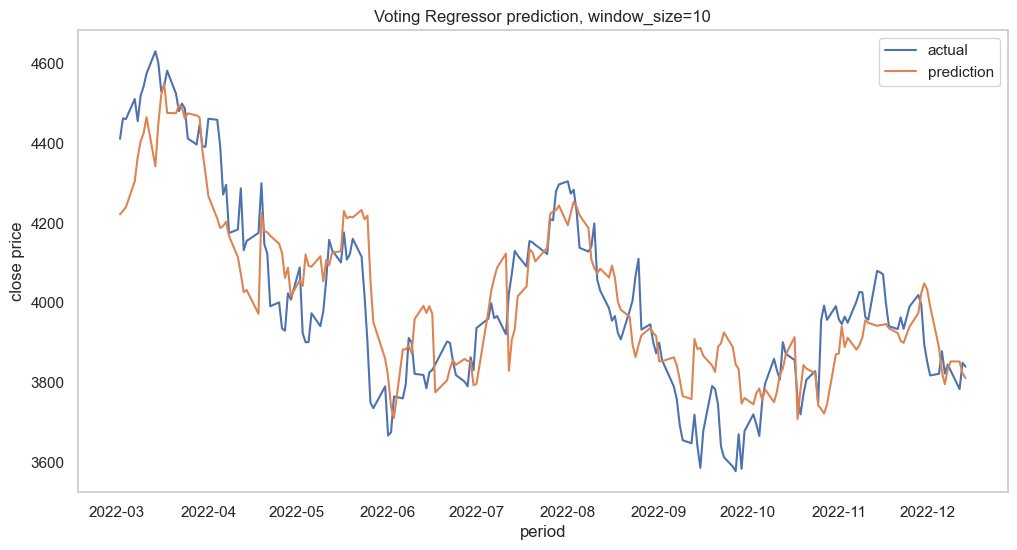

In [254]:
plt.figure(figsize=(12, 6))
plt.title('Voting Regressor prediction, window_size=10')
plt.ylabel('close price')
plt.xlabel('period')
plt.plot(date_values_bi,y_test_originalv, label='actual')
plt.plot(date_values_bi,y_pred_inv, label='prediction')
plt.grid()
plt.legend(loc='best')

plt.show()

In [255]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    return plt

# SHAP of Voting Regressor

In [256]:
features_vt = ['Principal_Component_' + str(i) for i in range(1, X_vtest_pca.shape[-1]+1)]
features_vt

['Principal_Component_1',
 'Principal_Component_2',
 'Principal_Component_3',
 'Principal_Component_4',
 'Principal_Component_5',
 'Principal_Component_6',
 'Principal_Component_7',
 'Principal_Component_8',
 'Principal_Component_9',
 'Principal_Component_10',
 'Principal_Component_11']

In [257]:
explainer = shap.KernelExplainer(vr.predict, shap.sample(X_pca_v, 10))  # Using 100 background samples for better performance
x_vtest_2d = np.reshape(X_vtest_pca, (X_vtest_pca.shape[0], X_vtest_pca.shape[1]))
shap_values_vr = explainer.shap_values(x_vtest_2d)


  0%|          | 0/200 [00:00<?, ?it/s]

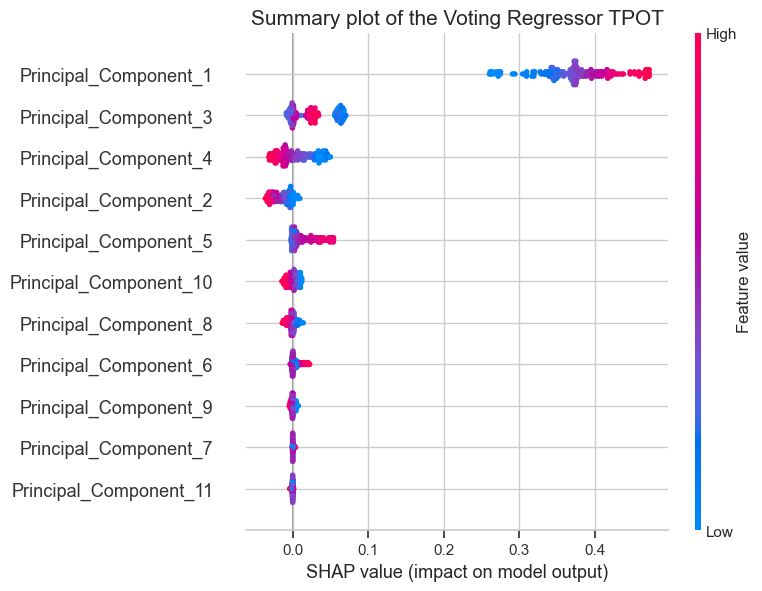

In [258]:
# Plot the SHAP values
#shap.summary_plot(shap_values_vr, x_vtest_2d,feature_names=actual_column_names)
shap.summary_plot(shap_values_vr, x_vtest_2d,feature_names=features_vt,show = False)
plt.title("Summary plot of the Voting Regressor TPOT",fontsize=15)
plt.show()
#shap.summary_plot(shap_values_vr, x_vtest_2d,feature_names=features_vt,title='Summary plot of Voting Regressor')


In [259]:
x_vtest_2d

array([[ 4.00994804e+00,  1.08361587e+00, -6.66026273e-01, ...,
         2.30343416e-02, -7.89516150e-02,  1.47411336e-03],
       [ 3.98974544e+00,  1.08520368e+00, -6.72106505e-01, ...,
         4.69953528e-02, -6.81047400e-02, -2.27189940e-02],
       [ 3.97379492e+00,  1.08138087e+00, -6.58593363e-01, ...,
        -7.75981519e-02, -7.62396626e-02,  5.27711729e-02],
       ...,
       [ 3.18414419e+00,  1.39502492e-01, -2.60726964e-02, ...,
         2.58171437e-02, -1.09226283e-01, -2.44137703e-02],
       [ 3.16549078e+00,  2.16804530e-01, -6.31699783e-02, ...,
        -2.79948126e-02, -8.66496842e-02,  5.89857557e-02],
       [ 3.13335830e+00,  3.02535428e-01, -9.73901872e-02, ...,
        -1.21699585e-01,  3.46390523e-02, -4.34626938e-02]])

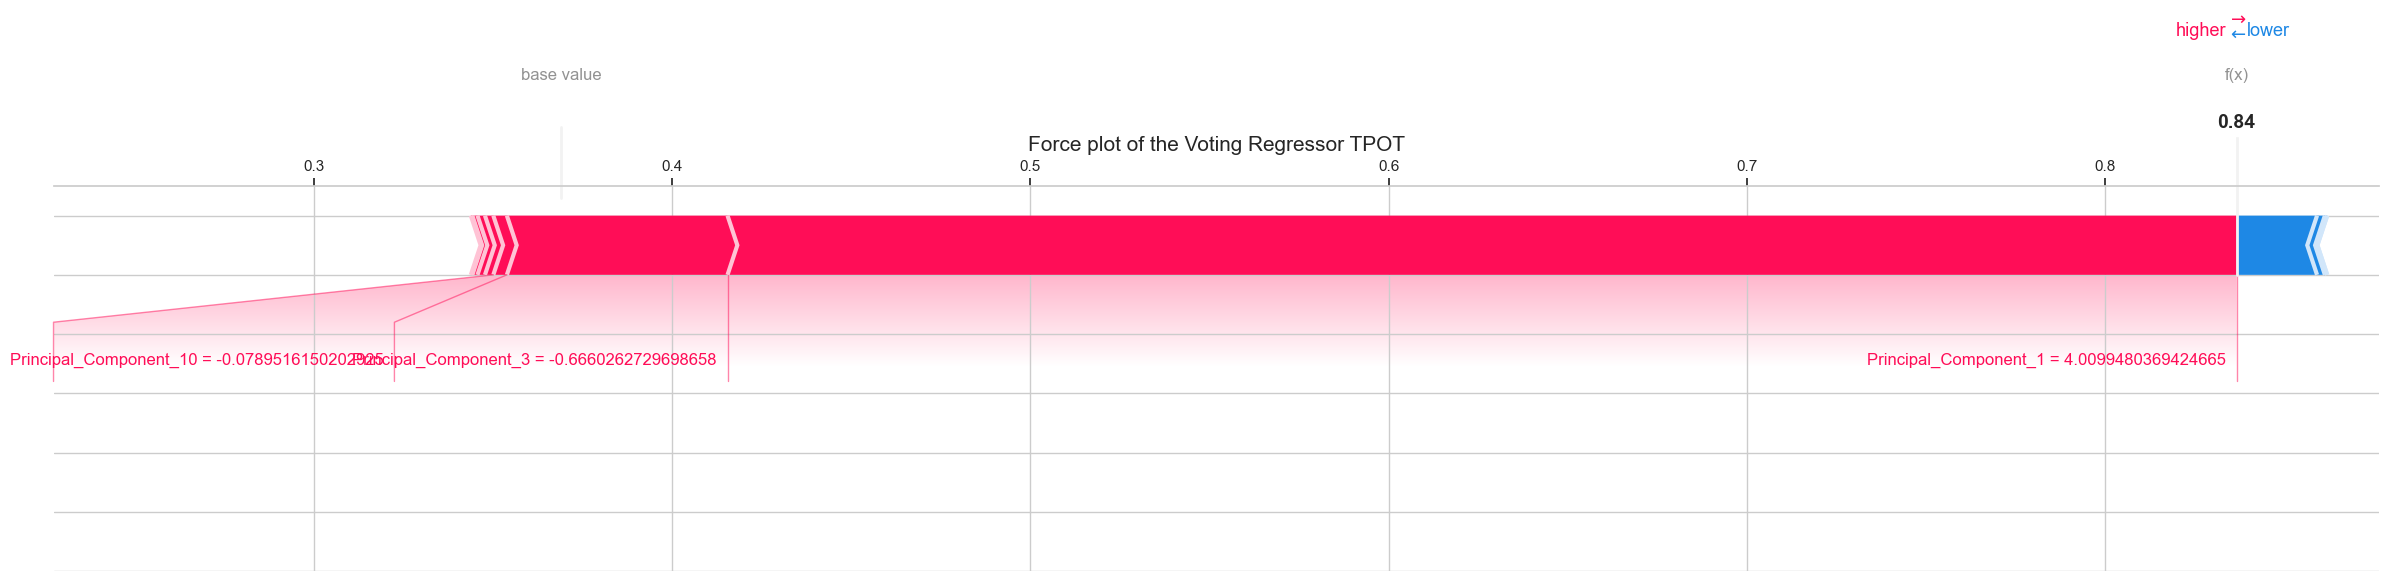

In [260]:
#Force_plot of the Voting Regressor
expected_value_vr = explainer.expected_value

instance_index = 0 

shap.force_plot(expected_value_vr, shap_values_vr[instance_index], x_vtest_2d[instance_index],
                feature_names=features_vt,matplotlib=True,show = False,figsize=(30,5))

plt.title("Force plot of the Voting Regressor TPOT",fontsize=15)
plt.show()

In [261]:
X.shape

(2737, 110)

In [262]:
x_vtest_2d_df = pd.DataFrame(x_vtest_2d, columns = features_vt)

In [263]:
x_vtest_2d_df

Principal_Component_1  Principal_Component_2  Principal_Component_3  \
0                 4.009948               1.083616              -0.666026   
1                 3.989745               1.085204              -0.672107   
2                 3.973795               1.081381              -0.658593   
3                 3.973405               1.070878              -0.624697   
4                 3.984103               1.039933              -0.575886   
..                     ...                    ...                    ...   
195               3.222121               0.004437               0.064835   
196               3.203719               0.064855               0.008920   
197               3.184144               0.139502              -0.026073   
198               3.165491               0.216805              -0.063170   
199               3.133358               0.302535              -0.097390   

     Principal_Component_4  Principal_Component_5  Principal_Component_6  \
0                -0.048638               0.082352              -0.057463   
1                -0.077341               0.078793              -0.083834   
2                -0.144503               0.094746              -0.096618   
3                -0.229001               0.120292              -0.086029   
4                -0.306357               0.151091              -0.032181   
..                     ...                    ...                    ...   
195               0.185477              -0.277550               0.052605   
196               0.241110              -0.253369               0.055032   
197               0.264550              -0.237788               0.055254   
198               0.282341              -0.209084               0.036828   
199               0.285707              -0.165447               0.031213   

     Principal_Component_7  Principal_Component_8  Principal_Component_9  \
0                 0.115639               0.071645               0.023034   
1                -0.017469              -0.029700               0.046995   
2                 0.026022               0.000988              -0.077598   
3                 0.014455              -0.116849              -0.017219   
4                -0.079092              -0.065708              -0.084786   
..                     ...                    ...                    ...   
195               0.056056               0.052717               0.109027   
196              -0.068478               0.088646               0.028470   
197               0.085925               0.008303               0.025817   
198              -0.068754              -0.026603              -0.027995   
199               0.043529              -0.027186              -0.121700   

     Principal_Component_10  Principal_Component_11  
0                 -0.078952                0.001474  
1                 -0.068105               -0.022719  
2                 -0.076240                0.052771  
3                 -0.080868               -0.025356  
4                 -0.100916               -0.065583  
..                      ...                     ...  
195                0.009973                0.052322  
196               -0.052645               -0.085282  
197               -0.109226               -0.024414  
198               -0.086650                0.058986  
199                0.034639               -0.043463  

[200 rows x 11 columns]

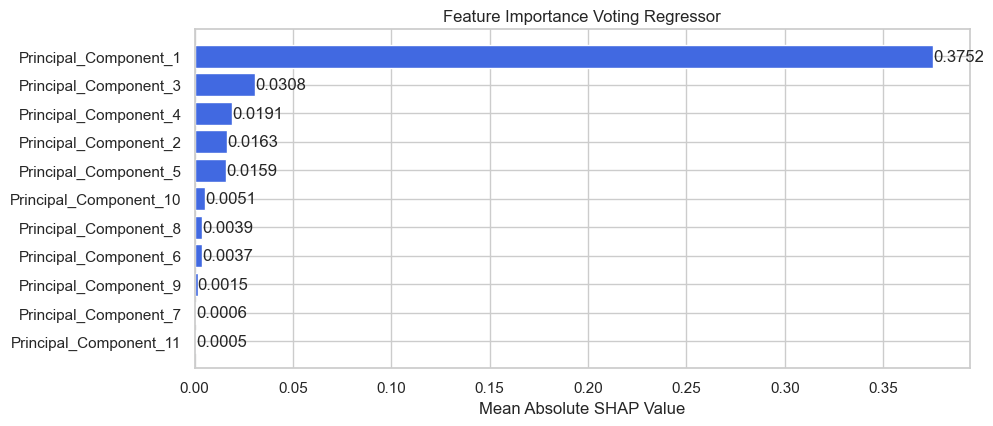

In [264]:
# Compute the mean absolute SHAP values for each feature
mean_shap_values_vr = np.abs(shap_values_vr).mean(axis=0)

# Sort the features based on their mean absolute SHAP values
sorted_indices_vr = np.argsort(mean_shap_values_vr)[::-1]

# If x_vtest_2d is a DataFrame, you can get the column names directly.
# Otherwise, replace `x_vtest_2d.columns` with appropriate column names.
sorted_features_vr = x_vtest_2d_df.columns[sorted_indices_vr]
sorted_shap_values_vr = mean_shap_values_vr[sorted_indices_vr]

# Create the bar plot
plt.figure(figsize=(10, len(sorted_features_vr) * 0.4))
plt.barh(sorted_features_vr, sorted_shap_values_vr, color='royalblue')
plt.xlabel('Mean Absolute SHAP Value')
plt.title('Feature Importance Voting Regressor')

# Annotate each bar with its exact value
for index, value in enumerate(sorted_shap_values_vr):
    plt.text(value, index, f'{value:.4f}', va='center')

plt.gca().invert_yaxis()  # To display the most important feature at the top
plt.show()


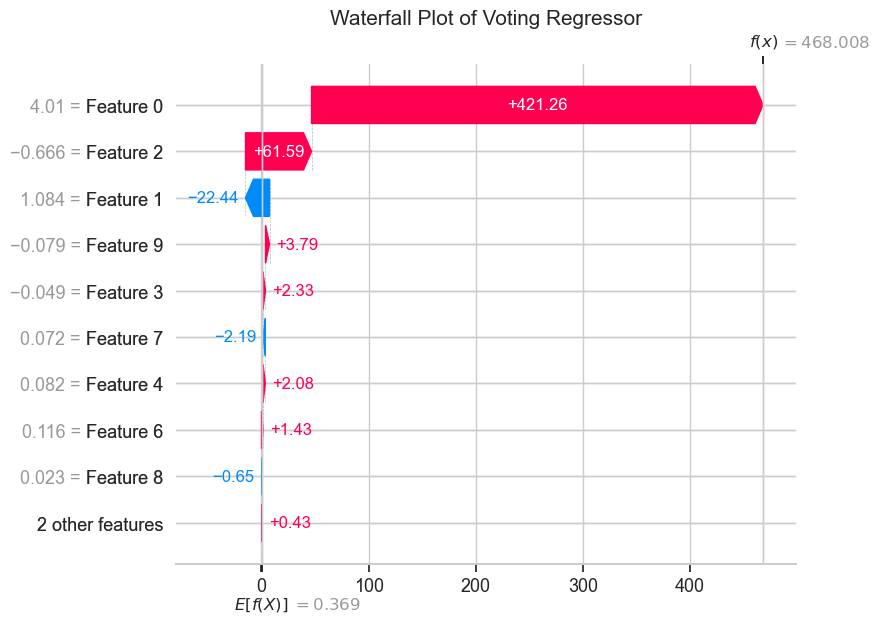

In [271]:
# Instance index you want to explain
instance_index_vt = 0

# Extract SHAP values and features for the selected instance
shap_values_instance_vt = shap_values_vr[instance_index_vt]
features_instance_vt = x_vtest_2d[instance_index_vt, :]  # Index directly into the numpy array

# Scale or round the SHAP values
shap_values_instance_vt_scaled = shap_values_instance_vt * 1000
shap_values_instance_vt_rounded = np.round(shap_values_instance_vt, 4)

# Create an Explanation object
expected_value_vt = explainer.expected_value  # No need to index if it's a single float
explanation_vt = shap.Explanation(values=shap_values_instance_vt_scaled, 
                                  base_values=expected_value_vt, data=features_instance_vt)

# Use the shap.waterfall_plot function with the Explanation object
shap.waterfall_plot(explanation_vt, show=False)

# Add the title
plt.title("Waterfall Plot of Voting Regressor", fontsize=15)

# Show the plot
plt.show()


# Summary of whole model

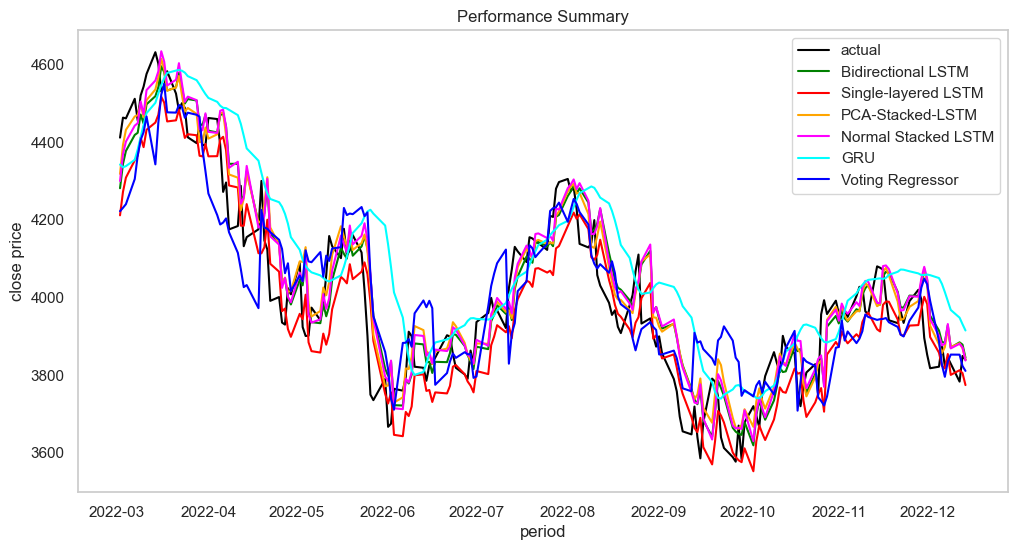

In [273]:
plt.figure(figsize=(12, 6))
plt.title('Performance Summary')
plt.ylabel('close price')
plt.xlabel('period')

plt.plot(date_values_bi,y_test_original, label='actual', color='black')
plt.plot(date_values_bi,y_pred_original, label='Bidirectional LSTM', color='green')
plt.plot(date_values_bi,y_single_pred_original, label='Single-layered LSTM', color='red')
plt.plot(date_values_bi,y_pca_pred_original, label='PCA-Stacked-LSTM', color='orange')
plt.plot(date_values_bi,y_nstacked_pred_original, label='Normal Stacked LSTM', color='magenta')
plt.plot(date_values_bi,y_pred_gru_original, label='GRU', color='cyan')
plt.plot(date_values_bi,y_pred_inv, label='Voting Regressor',color = 'blue')

plt.grid()
plt.legend(loc='best')

plt.show()


In [274]:
#Performance Evaluations
#1. Bidirectional-LSTM
real_rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
real_mae = mean_absolute_error(y_test_original, y_pred_original)
real_mape = mean_absolute_percentage_error(y_test_original, y_pred_original)

print("RMSE of Bidirectional-LSTM:", real_rmse)
print("MAE of Bidirectional-LSTM:",real_mae)
print("MAPE of Bidirectional-LSTM:", real_mape)


#2. Single-Layered LSTM
real_rmse_single = np.sqrt(mean_squared_error(y_single_test_original, y_single_pred_original))
real_mae_single = mean_absolute_error(y_single_test_original, y_single_pred_original)
real_mape_single = mean_absolute_percentage_error(y_single_test_original, y_single_pred_original)

print("RMSE of Single-Layered-LSTM :", real_rmse_single)
print("MAE of Single-Layered-LSTM :", real_mae_single)
print("MAPE of Single-Layered-LSTM :", real_mape_single)



#3. PCA-Stacked-LSTM
real_rmse_stacked = np.sqrt(mean_squared_error(y_pca_test_original, y_pca_pred_original))
real_mae_stacked = mean_absolute_error(y_pca_test_original, y_pca_pred_original)
real_mape_stacked = mean_absolute_percentage_error(y_pca_test_original, y_pca_pred_original)

print("RMSE of PCA-Stacked-LSTM :", real_rmse_stacked)
print("MAE of PCA-Stacked-LSTM :", real_mae_stacked)
print("MAPE of PCA-Stacked-LSTM :", real_mape_stacked)



#4. Regular Stacked LSTM
real_rmse_rstacked = np.sqrt(mean_squared_error(y_nstacked_test_original, y_nstacked_pred_original))
real_mae_rstacked = mean_absolute_error(y_nstacked_test_original, y_nstacked_pred_original)
real_mape_rstacked = mean_absolute_percentage_error(y_nstacked_test_original, y_nstacked_pred_original)

print("RMSE of Regular-Stacked-LSTM :", real_rmse_rstacked)
print("MAE of Regular-Stacked-LSTM :", real_mae_rstacked)
print("MAPE of Regular-Stacked-LSTM :", real_mape_rstacked)


#5. GRU
# Calculate metrics with the real number value
real_rmse_gru = np.sqrt(mean_squared_error(y_test_gru_original, y_pred_gru_original))
real_mae_gru = mean_absolute_error(y_test_gru_original, y_pred_gru_original)
real_mape_gru = mean_absolute_percentage_error(y_test_gru_original, y_pred_gru_original)

print("RMSE of GRU:", real_rmse_gru)
print("MAE of GRU:",real_mae_gru)
print("MAPE of GRU:", real_mape_gru)

#6. Voting Regressor
rmse_vr = np.sqrt(mean_squared_error(y_test_originalv, y_pred_inv))
mae_vr = mean_absolute_error(y_test_originalv, y_pred_inv)
mape_vr = mean_absolute_percentage_error(y_test_originalv, y_pred_inv)

print("RMSE of Voting Regressor:", rmse_vr)
print("MAE of Voting Regressor:", mae_vr)
print("MAPE of Voting Regressor:", mape_vr)

RMSE of Bidirectional-LSTM: 93.86219096003198
MAE of Bidirectional-LSTM: 75.43440795898437
MAPE of Bidirectional-LSTM: 0.018973989614554976
RMSE of Single-Layered-LSTM : 101.43010432286614
MAE of Single-Layered-LSTM : 84.4316845703125
MAPE of Single-Layered-LSTM : 0.020961128515828792
RMSE of PCA-Stacked-LSTM : 88.95113761633498
MAE of PCA-Stacked-LSTM : 70.54792602539061
MAPE of PCA-Stacked-LSTM : 0.017824867522710022
RMSE of Regular-Stacked-LSTM : 93.88194353247167
MAE of Regular-Stacked-LSTM : 74.33520385742186
MAPE of Regular-Stacked-LSTM : 0.01874240356739934
RMSE of GRU: 151.81894976792898
MAE of GRU: 117.80548828124998
MAPE of GRU: 0.02987730846064958
RMSE of Voting Regressor: 122.70262903895193
MAE of Voting Regressor: 95.66841088649872
MAPE of Voting Regressor: 0.024074432488411318


In [275]:
# Define the evaluation metrics and results
models = [
    "Bidirectional-LSTM", 
    "Single-Layered-LSTM", 
    "PCA-Stacked-LSTM", 
    "Regular-Stacked-LSTM", 
    "GRU", 
    "Voting Regressor"
]

 

rmse_values = [
    real_rmse, 
    real_rmse_single, 
    real_rmse_stacked, 
    real_rmse_rstacked, 
    real_rmse_gru, 
    rmse_vr
]

 

mae_values = [
    real_mae, 
    real_mae_single, 
    real_mae_stacked, 
    real_mae_rstacked, 
    real_mae_gru, 
    mae_vr
]

 

mape_values = [
    real_mape, 
    real_mape_single, 
    real_mape_stacked, 
    real_mape_rstacked, 
    real_mape_gru, 
    mape_vr
]

 

# Create a DataFrame
results_df = pd.DataFrame({
    "Model": models,
    "RMSE": rmse_values,
    "MAE": mae_values,
    "MAPE": mape_values
})

 

# Display the DataFrame
print(results_df)

                  Model        RMSE         MAE      MAPE
0    Bidirectional-LSTM   93.862191   75.434408  0.018974
1   Single-Layered-LSTM  101.430104   84.431685  0.020961
2      PCA-Stacked-LSTM   88.951138   70.547926  0.017825
3  Regular-Stacked-LSTM   93.881944   74.335204  0.018742
4                   GRU  151.818950  117.805488  0.029877
5      Voting Regressor  122.702629   95.668411  0.024074


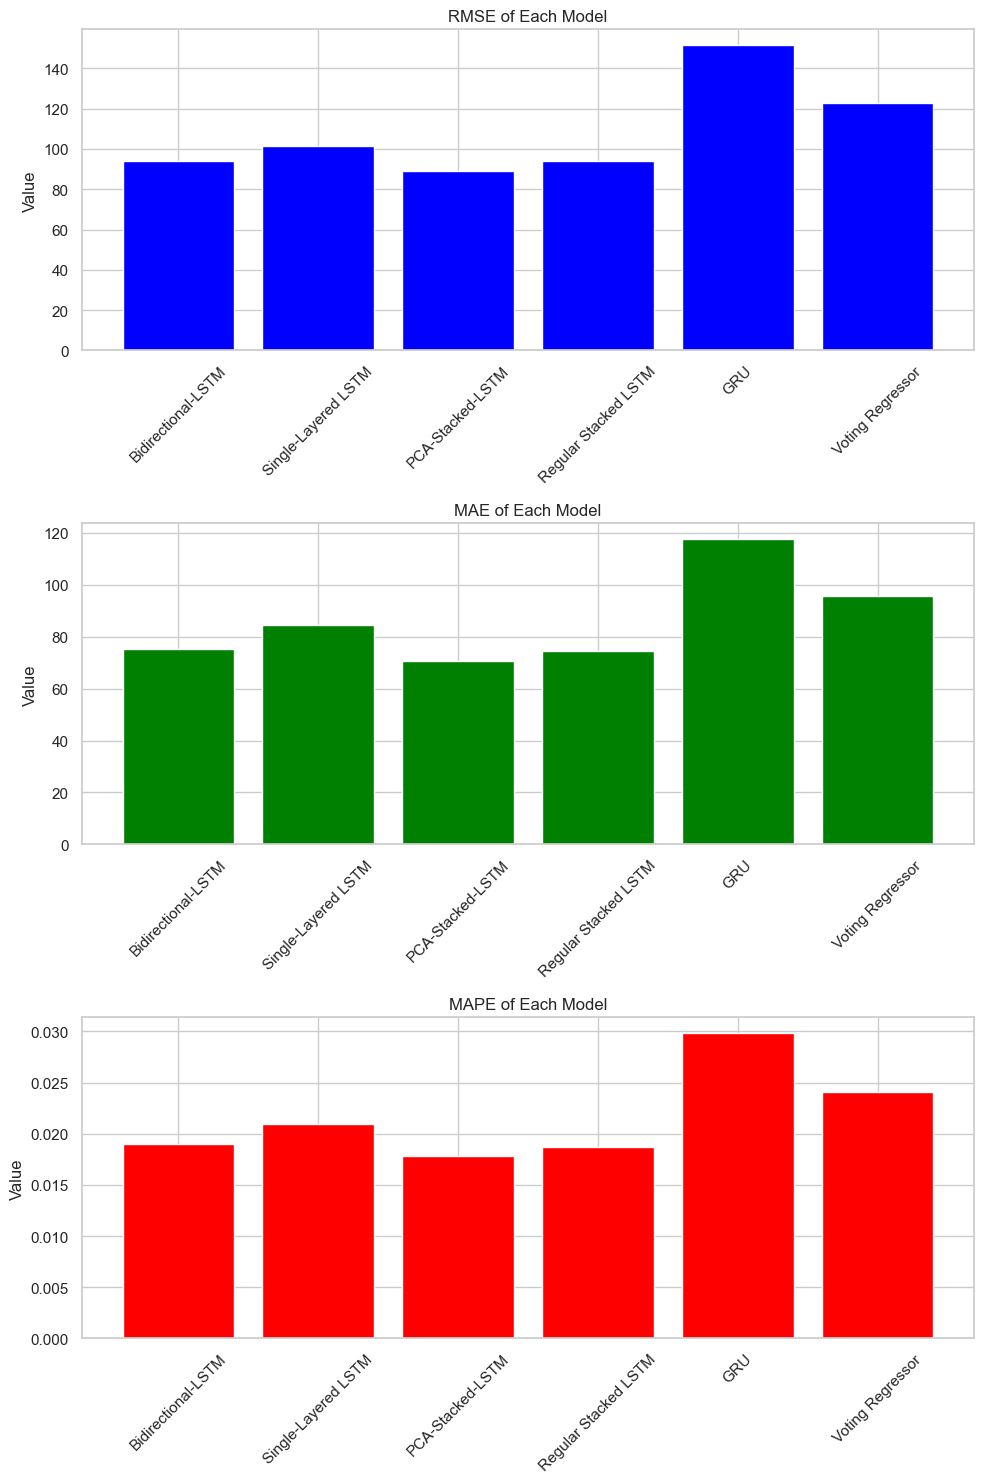

In [276]:
import matplotlib.pyplot as plt

# Model names
models = ['Bidirectional-LSTM', 'Single-Layered LSTM', 'PCA-Stacked-LSTM', 'Regular Stacked LSTM', 'GRU', 'Voting Regressor']

# RMSE values
rmse_values = [real_rmse, real_rmse_single, real_rmse_stacked, real_rmse_rstacked, real_rmse_gru, rmse_vr]

# MAE values
mae_values = [real_mae, real_mae_single, real_mae_stacked, real_mae_rstacked, real_mae_gru, mae_vr]

# MAPE values
mape_values = [real_mape, real_mape_single, real_mape_stacked, real_mape_rstacked, real_mape_gru, mape_vr]

# Create subplots
fig, axs = plt.subplots(3, figsize=(10, 15))

# Create RMSE bar chart
axs[0].bar(models, rmse_values, color='blue')
axs[0].set_title('RMSE of Each Model')
axs[0].set_ylabel('Value')

# Create MAE bar chart
axs[1].bar(models, mae_values, color='green')
axs[1].set_title('MAE of Each Model')
axs[1].set_ylabel('Value')

# Create MAPE bar chart
axs[2].bar(models, mape_values, color='red')
axs[2].set_title('MAPE of Each Model')
axs[2].set_ylabel('Value')

# Rotate x-axis labels for readability
for ax in axs:
    plt.sca(ax)
    plt.xticks(rotation=45)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

# Testing with unseen data

In [223]:
df_unseen = yf.download('^KS11', start='2010-01-01', end='2023-06-30')
#df = pd.read_csv("/Users/parkjs9416/Documents/Dissertation/Dissertation_project_code_and_data/Dataset/sp500_10year_data.csv")
df_unseen

[*********************100%***********************]  1 of 1 completed


Open         High          Low        Close    Adj Close  \
Date                                                                          
2010-01-04  1681.709961  1696.140015  1681.709961  1696.140015  1696.140015   
2010-01-05  1701.619995  1702.390015  1686.449951  1690.619995  1690.619995   
2010-01-06  1697.880005  1706.890015  1696.099976  1705.319946  1705.319946   
2010-01-07  1702.920044  1707.900024  1683.449951  1683.449951  1683.449951   
2010-01-08  1694.060059  1695.260010  1668.839966  1695.260010  1695.260010   
...                 ...          ...          ...          ...          ...   
2023-06-23  2599.040039  2600.810059  2568.070068  2570.100098  2570.100098   
2023-06-26  2568.649902  2585.310059  2562.030029  2582.199951  2582.199951   
2023-06-27  2581.020020  2582.000000  2568.520020  2581.389893  2581.389893   
2023-06-28  2590.520020  2590.520020  2559.459961  2564.189941  2564.189941   
2023-06-29  2564.020020  2577.689941  2550.020020  2550.020020  2550.020020   

            Volume  
Date                
2010-01-04  296500  
2010-01-05  408900  
2010-01-06  426000  
2010-01-07  462400  
2010-01-08  380000  
...            ...  
2023-06-23  526500  
2023-06-26  479200  
2023-06-27  535400  
2023-06-28  484200  
2023-06-29  602500  

[3325 rows x 6 columns]

In [224]:
#Making the percentage changes in each day
df_unseen['Pct_change'] = df_unseen['Close'].pct_change()
# data['Pct_change'] = np.log(1+data['Pct_change'])
df_unseen['Pct_change'] = np.log1p(df_unseen['Pct_change'])
# Choose the desired time periods for the moving averages
short_period = 12  # Short-term EMA period
long_period = 26  # Long-term EMA period
signal_period = 9  # Signal line EMA period

# Calculate the short-term EMA
df_unseen['Short EMA'] = df_unseen['Close'].ewm(span=short_period, adjust=False).mean()

# Calculate the long-term EMA
df_unseen['Long EMA'] = df_unseen['Close'].ewm(span=long_period, adjust=False).mean()

# Calculate the MACD line
df_unseen['MACD'] = df_unseen['Short EMA'] - df_unseen['Long EMA']

# Calculate the signal line
df_unseen['Signal Line'] = df_unseen['MACD'].ewm(span=signal_period, adjust=False).mean()

# Calculate the MACD histogram
df_unseen['MACD Histogram'] = df_unseen['MACD'] - df_unseen['Signal Line']
# Choose the desired time period for the moving average and standard deviation
window = 20  # Number of Trading days in a month
num_std = 2  
# 2 standard deviations above and below the middle band provides 
#a range that encompasses a large portion of typical price movements

# Calculate the logarithmic returns
df_unseen['Log Returns'] = np.log(df_unseen['Close'] / df_unseen['Close'].shift(1))

# Calculate the volatility
df_unseen['Volatility'] = df_unseen['Log Returns'].rolling(window=20).std() * np.sqrt(252)

# Calculate the middle band (simple moving average)
df_unseen['Middle Band'] = df_unseen['Close'].rolling(window=window).mean()

# Calculate the standard deviation of the closing prices
df_unseen['Std Dev'] = df_unseen['Close'].rolling(window=window).std()

# Calculate the upper band and lower band
df_unseen['Upper Band'] = df_unseen['Middle Band'] + (num_std * df_unseen['Std Dev'])
df_unseen['Lower Band'] = df_unseen['Middle Band'] - (num_std * df_unseen['Std Dev'])

#Making Next day's close price column in each date.
df_unseen['Next_day'] = df_unseen['Close'].shift(-1)


# Display the updated DataFrame with the Bollinger Bands columns
df_unseen

Open         High          Low        Close    Adj Close  \
Date                                                                          
2010-01-04  1681.709961  1696.140015  1681.709961  1696.140015  1696.140015   
2010-01-05  1701.619995  1702.390015  1686.449951  1690.619995  1690.619995   
2010-01-06  1697.880005  1706.890015  1696.099976  1705.319946  1705.319946   
2010-01-07  1702.920044  1707.900024  1683.449951  1683.449951  1683.449951   
2010-01-08  1694.060059  1695.260010  1668.839966  1695.260010  1695.260010   
...                 ...          ...          ...          ...          ...   
2023-06-23  2599.040039  2600.810059  2568.070068  2570.100098  2570.100098   
2023-06-26  2568.649902  2585.310059  2562.030029  2582.199951  2582.199951   
2023-06-27  2581.020020  2582.000000  2568.520020  2581.389893  2581.389893   
2023-06-28  2590.520020  2590.520020  2559.459961  2564.189941  2564.189941   
2023-06-29  2564.020020  2577.689941  2550.020020  2550.020020  2550.020020   

            Volume  Pct_change    Short EMA     Long EMA       MACD  \
Date                                                                  
2010-01-04  296500         NaN  1696.140015  1696.140015   0.000000   
2010-01-05  408900   -0.003260  1695.290781  1695.731124  -0.440343   
2010-01-06  426000    0.008657  1696.833729  1696.441407   0.392322   
2010-01-07  462400   -0.012908  1694.774687  1695.479077  -0.704391   
2010-01-08  380000    0.006991  1694.849352  1695.462850  -0.613498   
...            ...         ...          ...          ...        ...   
2023-06-23  526500   -0.009141  2597.695773  2583.547578  14.148195   
2023-06-26  479200    0.004697  2595.311800  2583.447753  11.864047   
2023-06-27  535400   -0.000314  2593.169968  2583.295319   9.874649   
2023-06-28  484200   -0.006685  2588.711502  2581.880106   6.831396   
2023-06-29  602500   -0.005541  2582.758967  2579.520100   3.238867   

            Signal Line  MACD Histogram  Log Returns  Volatility  Middle Band  \
Date                                                                            
2010-01-04     0.000000        0.000000          NaN         NaN          NaN   
2010-01-05    -0.088069       -0.352275    -0.003260         NaN          NaN   
2010-01-06     0.008009        0.384313     0.008657         NaN          NaN   
2010-01-07    -0.134471       -0.569920    -0.012908         NaN          NaN   
2010-01-08    -0.230276       -0.383222     0.006991         NaN          NaN   
...                 ...             ...          ...         ...          ...   
2023-06-23    22.141049       -7.992855    -0.009141    0.105260  2600.562012   
2023-06-26    20.085649       -8.221602     0.004697    0.104726  2601.937512   
2023-06-27    18.043449       -8.168800    -0.000314    0.104687  2603.066504   
2023-06-28    15.801038       -8.969642    -0.006685    0.100636  2602.000000   
2023-06-29    13.288604      -10.049737    -0.005541    0.101813  2600.644995   

              Std Dev   Upper Band   Lower Band     Next_day  
Date                                                          
2010-01-04        NaN          NaN          NaN  1690.619995  
2010-01-05        NaN          NaN          NaN  1705.319946  
2010-01-06        NaN          NaN          NaN  1683.449951  
2010-01-07        NaN          NaN          NaN  1695.260010  
2010-01-08        NaN          NaN          NaN  1694.119995  
...               ...          ...          ...          ...  
2023-06-23  25.623794  2651.809599  2549.314424  2582.199951  
2023-06-26  23.697741  2649.332994  2554.542030  2581.389893  
2023-06-27  22.012928  2647.092359  2559.040649  2564.189941  
2023-06-28  23.381921  2648.763841  2555.236159  2550.020020  
2023-06-29  25.581407  2651.807809  2549.482182          NaN  

[3325 rows x 19 columns]

In [225]:
df_unseen.isnull().sum()

Open               0
High               0
Low                0
Close              0
Adj Close          0
Volume             0
Pct_change         1
Short EMA          0
Long EMA           0
MACD               0
Signal Line        0
MACD Histogram     0
Log Returns        1
Volatility        20
Middle Band       19
Std Dev           19
Upper Band        19
Lower Band        19
Next_day           1
dtype: int64

In [226]:
df_unseen = df_unseen.dropna()
df_unseen

Open         High          Low        Close    Adj Close  \
Date                                                                          
2010-02-01  1603.869995  1611.989990  1590.800049  1606.439941  1606.439941   
2010-02-02  1618.599976  1618.599976  1591.239990  1595.810059  1595.810059   
2010-02-03  1614.160034  1618.859985  1602.550049  1615.020020  1615.020020   
2010-02-04  1615.479980  1619.369995  1607.869995  1616.420044  1616.420044   
2010-02-05  1567.589966  1575.160034  1560.989990  1567.119995  1567.119995   
...                 ...          ...          ...          ...          ...   
2023-06-22  2575.649902  2597.760010  2575.649902  2593.699951  2593.699951   
2023-06-23  2599.040039  2600.810059  2568.070068  2570.100098  2570.100098   
2023-06-26  2568.649902  2585.310059  2562.030029  2582.199951  2582.199951   
2023-06-27  2581.020020  2582.000000  2568.520020  2581.389893  2581.389893   
2023-06-28  2590.520020  2590.520020  2559.459961  2564.189941  2564.189941   

            Volume  Pct_change    Short EMA     Long EMA       MACD  \
Date                                                                  
2010-02-01  382200    0.002499  1652.925543  1672.368694 -19.443152   
2010-02-02  435000   -0.006639  1644.138545  1666.697684 -22.559139   
2010-02-03  438200    0.011966  1639.658772  1662.869709 -23.210937   
2010-02-04  396800    0.000867  1636.083583  1659.428993 -23.345410   
2010-02-05  460800   -0.030974  1625.473800  1652.591290 -27.117489   
...            ...         ...          ...          ...        ...   
2023-06-22  610200    0.004277  2602.713168  2584.623376  18.089792   
2023-06-23  526500   -0.009141  2597.695773  2583.547578  14.148195   
2023-06-26  479200    0.004697  2595.311800  2583.447753  11.864047   
2023-06-27  535400   -0.000314  2593.169968  2583.295319   9.874649   
2023-06-28  484200   -0.006685  2588.711502  2581.880106   6.831396   

            Signal Line  MACD Histogram  Log Returns  Volatility  Middle Band  \
Date                                                                            
2010-02-01    -9.030022      -10.413130     0.002499    0.177487  1677.672498   
2010-02-02   -11.735845      -10.823294    -0.006639    0.178029  1672.932001   
2010-02-03   -14.030864       -9.180074     0.011966    0.181232  1668.417004   
2010-02-04   -15.893773       -7.451637     0.000867    0.177521  1665.065509   
2010-02-05   -18.138516       -8.978973    -0.030974    0.201465  1658.658508   
...                 ...             ...          ...         ...          ...   
2023-06-22    24.139263       -6.049471     0.004277    0.099520  2600.429504   
2023-06-23    22.141049       -7.992855    -0.009141    0.105260  2600.562012   
2023-06-26    20.085649       -8.221602     0.004697    0.104726  2601.937512   
2023-06-27    18.043449       -8.168800    -0.000314    0.104687  2603.066504   
2023-06-28    15.801038       -8.969642    -0.006685    0.100636  2602.000000   

              Std Dev   Upper Band   Lower Band     Next_day  
Date                                                          
2010-02-01  36.009101  1749.690700  1605.654295  1595.810059  
2010-02-02  40.210517  1753.353034  1592.510967  1615.020020  
2010-02-03  41.433486  1751.283977  1585.550032  1616.420044  
2010-02-04  42.840577  1750.746663  1579.384355  1567.119995  
2010-02-05  47.423961  1753.506429  1563.810587  1552.790039  
...               ...          ...          ...          ...  
2023-06-22  25.795885  2652.021275  2548.837734  2570.100098  
2023-06-23  25.623794  2651.809599  2549.314424  2582.199951  
2023-06-26  23.697741  2649.332994  2554.542030  2581.389893  
2023-06-27  22.012928  2647.092359  2559.040649  2564.189941  
2023-06-28  23.381921  2648.763841  2555.236159  2550.020020  

[3304 rows x 19 columns]

In [227]:
df_unseen.isnull().sum()

Open              0
High              0
Low               0
Close             0
Adj Close         0
Volume            0
Pct_change        0
Short EMA         0
Long EMA          0
MACD              0
Signal Line       0
MACD Histogram    0
Log Returns       0
Volatility        0
Middle Band       0
Std Dev           0
Upper Band        0
Lower Band        0
Next_day          0
dtype: int64

Text(0.5, 1.0, 'Close Price trend with BollingerBand and the EMA')

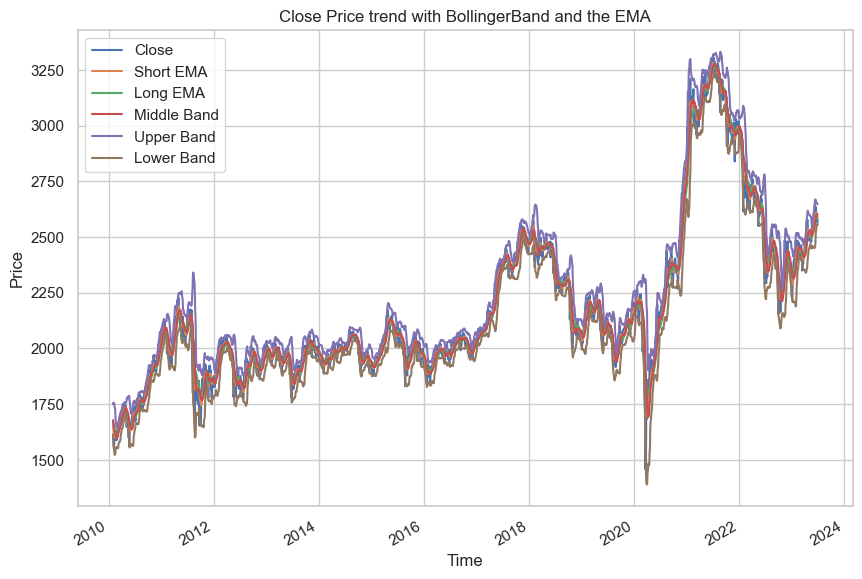

In [266]:
df_unseen[["Close","Short EMA", "Long EMA","Middle Band", 'Upper Band', 'Lower Band']].plot(figsize=(10,7))
plt.legend(loc="best")
plt.xlabel("Time")
plt.ylabel("Price")
plt.title("Close Price trend with BollingerBand and the EMA")

### Preprocessing

In [229]:
scaler = MinMaxScaler()

scale_cols = ['Open', 'High', 'Low', 'Pct_change', 'MACD','Signal Line','Volatility','Middle Band', 'Std Dev',
       'Upper Band', 'Lower Band', 'Next_day']

scaled_df_unseen = scaler.fit_transform(df_unseen[scale_cols])

scaled_df_unseen = pd.DataFrame(scaled_df_unseen, columns=scale_cols)

print(scaled_df_unseen)

          Open      High       Low  Pct_change      MACD  Signal Line  \
0     0.070682  0.052931  0.081557    0.529837  0.491117     0.503324   
1     0.078727  0.056604  0.081794    0.476140  0.480354     0.492118   
2     0.076302  0.056749  0.087887    0.585464  0.478102     0.482613   
3     0.077023  0.057032  0.090754    0.520243  0.477638     0.474898   
4     0.050868  0.032462  0.065495    0.333145  0.464608     0.465601   
...        ...       ...       ...         ...       ...          ...   
3299  0.601417  0.600785  0.612184    0.540284  0.620761     0.640696   
3300  0.614191  0.602480  0.608100    0.461441  0.607147     0.632420   
3301  0.597594  0.593866  0.604846    0.542751  0.599257     0.623907   
3302  0.604350  0.592026  0.608343    0.513308  0.592385     0.615450   
3303  0.609538  0.596761  0.603461    0.475868  0.581873     0.606163   

      Volatility  Middle Band   Std Dev  Upper Band  Lower Band  Next_day  
0       0.197703     0.046829  0.144972    0.06

In [230]:
pca = PCA()
X_pca_unseen = pca.fit_transform(scaled_df_unseen)
# Calculate the cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

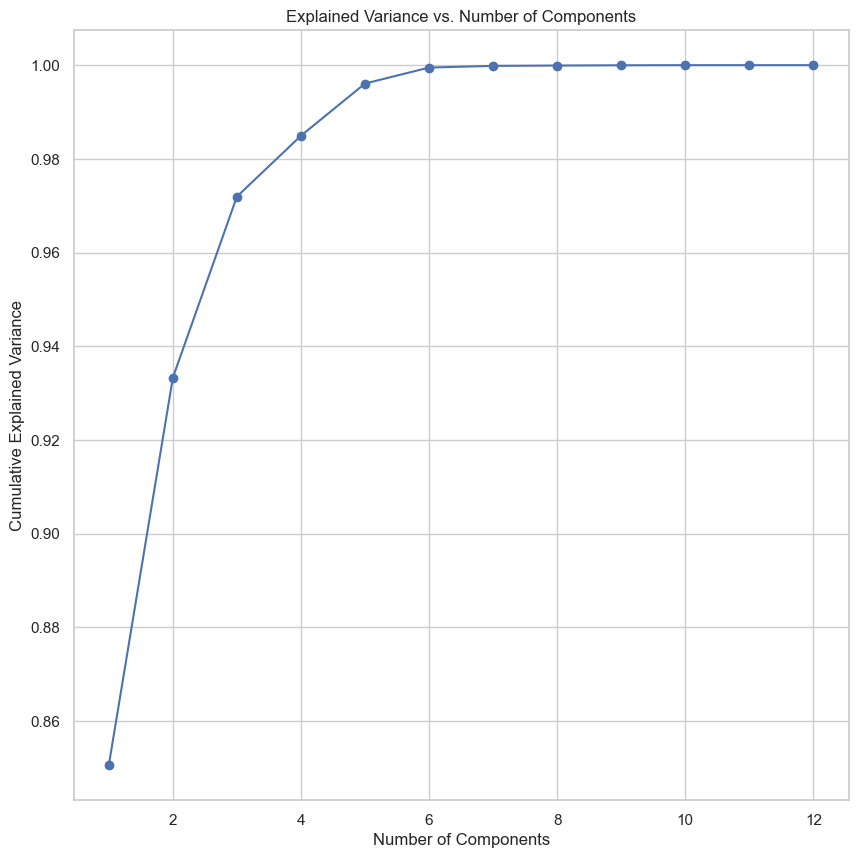

In [233]:
# Plot the cumulative explained variance against the number of components
plt.rcParams["figure.figsize"] = (10,10)
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.grid(True)
plt.show()

In [232]:
n_components = 6
pca = PCA(n_components=n_components)
X_pca_unseen = pca.fit_transform(scaled_df_unseen)

In [234]:
# Access the principal components
principal_components = pca.components_

# Access the explained variance of each principal component
explained_variances = pca.explained_variance_ratio_

# Print the explained variance of each principal component
for i, explained_variance in enumerate(explained_variances):
    print(f"Principal Component {i+1}: {explained_variance:.4f}")
    


Principal Component 1: 0.8506
Principal Component 2: 0.0827
Principal Component 3: 0.0387
Principal Component 4: 0.0130
Principal Component 5: 0.0111
Principal Component 6: 0.0034


In [235]:
X_pca_df_unseen = pd.DataFrame(X_pca_unseen)
X_pca_df_unseen

0         1         2         3         4         5
0    -0.811716  0.071053 -0.022912  0.009769  0.010903  0.052992
1    -0.806031  0.091448 -0.024809  0.051497 -0.017397  0.028587
2    -0.807687  0.101970 -0.020625 -0.019783  0.063824  0.045174
3    -0.817934  0.106871 -0.027308  0.030487  0.021772  0.030146
4    -0.852989  0.152085 -0.026932  0.148847 -0.121243  0.007992
...        ...       ...       ...       ...       ...       ...
3299  0.603406 -0.122615  0.003631 -0.013819  0.008136  0.043488
3300  0.609088 -0.109658 -0.008632  0.030969 -0.052730  0.022357
3301  0.598186 -0.107729 -0.020336 -0.023471  0.004384  0.047337
3302  0.597762 -0.106020 -0.034714 -0.008082 -0.020181  0.039983
3303  0.596203 -0.097276 -0.045801  0.023356 -0.040532  0.029263

[3304 rows x 6 columns]

In [236]:
# Split x_pca into input sequences and target values
lookback = 10 #Using past 10 days'daily data of below columns'data to predict the 'Next_day' price
data_columns = [ 'Open', 'High', 'Low', 'Pct_change', 'MACD','Signal Line','Volatility' ,'Middle Band', 'Std Dev',
                'Upper Band', 'Lower Band']
target_columns = ['Next_day']

X_unseen = []
y_unseen = []
for i in range(len(X_pca_unseen) - lookback):
    X_unseen.append(X_pca_unseen[i:i+lookback])
    y_unseen.append(df_unseen['Next_day'].values[i+lookback])

# Convert to numpy arrays
X_unseen = np.array(X_unseen)
y_unseen = np.array(y_unseen)

In [237]:
# Scale the input sequences (X)
scaler = MinMaxScaler()
#X = scaler.fit_transform(X_pca.reshape(X.shape[0], -1))
X_unseen = scaler.fit_transform(X_unseen.reshape(X_unseen.shape[0], -1))

# Scale the target variable (y)
y_scaler = MinMaxScaler()
y_unseen = y_scaler.fit_transform(y_unseen.reshape(-1, 1))

In [238]:
X_unseen = X_unseen.reshape((X_unseen.shape[0], lookback, -1))

In [239]:
#Predict the KOSPI value
y_pred_unseen = stacked_lstm_model.predict(X_unseen)

In [240]:
# Calculate error metrics
real_rmse_unseen = np.sqrt(mean_squared_error(y_unseen, y_pred_unseen))
real_mse_unseen = mean_squared_error(y_unseen, y_pred_unseen)
real_mae_unseen = mean_absolute_error(y_unseen, y_pred_unseen)
real_mape_unseen = mean_absolute_percentage_error(y_unseen, y_pred_unseen)

# Print each value
print("RMSE (unseen data):", real_rmse_unseen)
print("MSE (unseen data):", real_mse_unseen)
print("MAE (unseen data):", real_mae_unseen)
print("MAPE (unseen data):", real_mape_unseen)

RMSE (unseen data): 0.03978440164892671
MSE (unseen data): 0.001582798614563122
MAE (unseen data): 0.034986137608279275
MAPE (unseen data): 125120453248.50784


In [241]:
y_pred_unseen

array([[0.02030397],
       [0.02370462],
       [0.03272813],
       ...,
       [0.6041729 ],
       [0.60553604],
       [0.6044955 ]], dtype=float32)

In [242]:
y_unseen

array([[0.09189911],
       [0.08852164],
       [0.07375093],
       ...,
       [0.6082313 ],
       [0.5989218 ],
       [0.59125231]])

In [243]:
y_pred_unseen_original = y_scaler.inverse_transform(y_pred_unseen)
y_unseen_original = y_scaler.inverse_transform(y_unseen)

In [244]:
y_pred_unseen_original

array([[1495.1531],
       [1501.4359],
       [1518.1075],
       ...,
       [2573.8916],
       [2576.4102],
       [2574.4878]], dtype=float32)

In [245]:
y_unseen_original

array([[1627.43005371],
       [1621.18994141],
       [1593.90002441],
       ...,
       [2581.38989258],
       [2564.18994141],
       [2550.02001953]])

In [246]:
# Calculate error metrics
real_rmse_unseen = np.sqrt(mean_squared_error(y_unseen_original, y_pred_unseen_original))
real_mae_unseen = mean_absolute_error(y_unseen_original, y_pred_unseen_original)
real_mape_unseen = mean_absolute_percentage_error(y_unseen_original, y_pred_unseen_original)

# Print each value
print("RMSE of PCA-STACKED LSTM with KOSPI:", real_rmse_unseen)
print("MAE of PCA-STACKED LSTM with KOSPI:", real_mae_unseen)
print("MAPE of PCA-STACKED LSTM with KOSPI:", real_mape_unseen)

RMSE of PCA-STACKED LSTM with KOSPI: 73.50447397763958
MAE of PCA-STACKED LSTM with KOSPI: 64.63934770872467
MAPE of PCA-STACKED LSTM with KOSPI: 0.031108606247110364


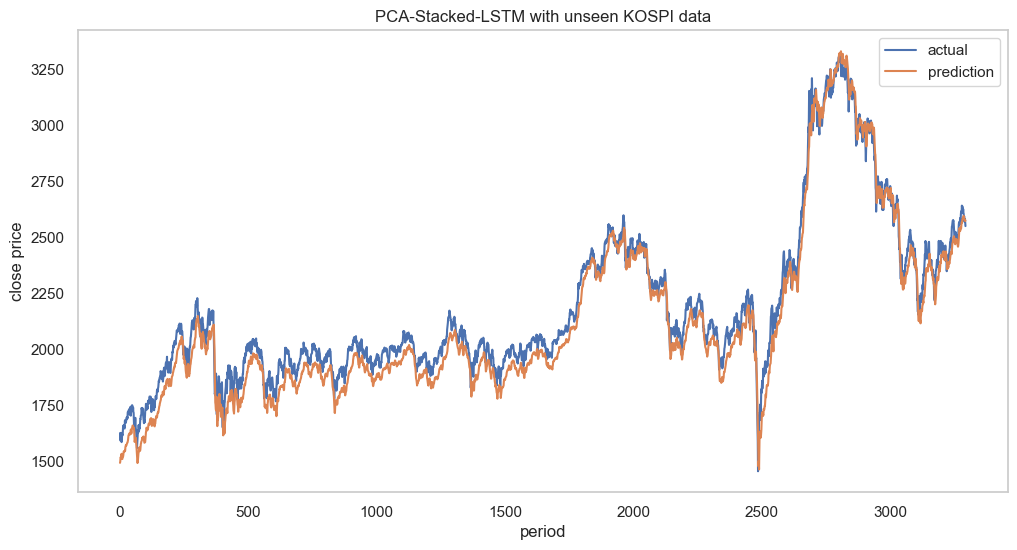

In [247]:
#Real values of prediction
plt.figure(figsize=(12, 6))
plt.title('PCA-Stacked-LSTM with unseen KOSPI data')
plt.ylabel('close price')
plt.xlabel('period')
plt.plot(y_unseen_original, label='actual')
plt.plot(y_pred_unseen_original, label='prediction')
plt.grid()
plt.legend(loc='best')

plt.show()

In [267]:
dates_unseen = df_unseen.index[lookback:].values

In [264]:
df_unseen_reset = df_unseen.reset_index()
date_values_unseen = df_unseen_reset['Date'].iloc[train_index].values

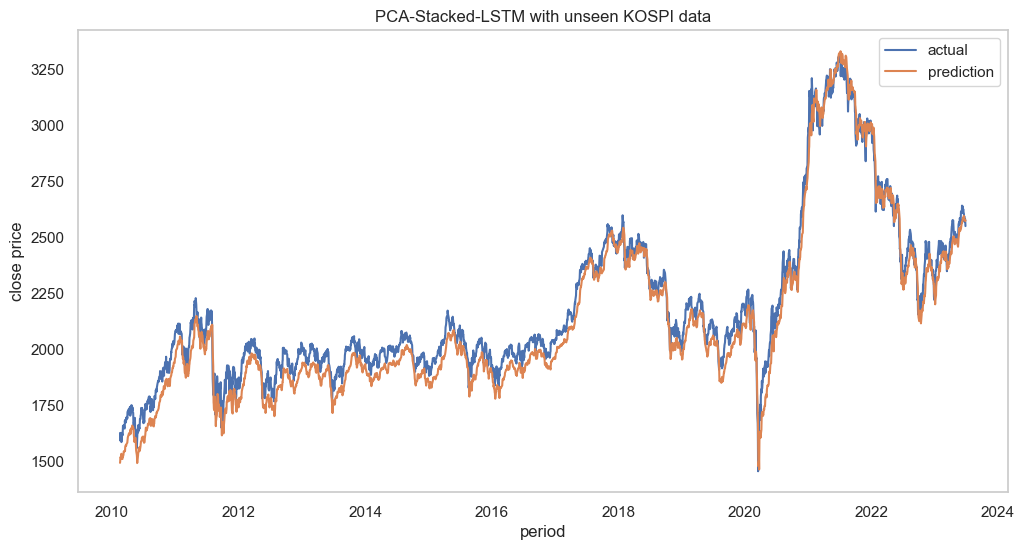

In [268]:
#Real values of prediction
plt.figure(figsize=(12, 6))
plt.title('PCA-Stacked-LSTM with unseen KOSPI data')
plt.ylabel('close price')
plt.xlabel('period')
plt.plot(dates_unseen,y_unseen_original, label='actual')
plt.plot(dates_unseen,y_pred_unseen_original, label='prediction')
plt.grid()
plt.legend(loc='best')

plt.show()